# Intro to the OpenOA `PlantData` and QA Methods

In this example we will be using the ENGIE open data set for the La Haute Borne wind power plant, and demonstrating how to use the quality assurance (QA) methods in OpenOA to help get this data ready for use with the `PlantData` class. This notebook will walk through the creation of the `project_Engie` module, especially the `prepare()` method that returns either the cleaned data or a `PlantData` object.

While we work with `project_ENGIE.py` to standardize the QCing of the La Haute Borne data, it should be noted that the use of an external script to load in data is entirely optional. For instance, a user could do all their work in a single script, set up a template Jupyter Notebook for working with data, or any other means that produces the data that can be read into `PlantData` and the associated metadata (`PlantMetaData`), as determined by the user input data.

## The `PlantData` object

The `PlantData` object is the core data structure for OpenOA, which is used for importing and validating wind power plant operational data for analysis in OpenOA. 

### What's changed in v3?

For users that are well acquainted with OpenOA and its data structures, there are a few changes to the ways the code now operates:
- All data objects such as `PlantData.scada` are pandas `DataFrame`s now, so there is no longer the need to access the data via `PlantData.scada._df`
- Because all data objects are pandas `DataFrame`s, `AssetData` and `ReanalysisData` have been dropped in favor of: `PlantData.asset` and `PlantData.reanalysis`, respectively.
- Reanalysis data is the only data object that diverges, and is now a dictionary of `DataFrame`s, which enables the use of an arbitrary number of reanalysis products to be imported and used
- There are now a number of convenience methods, such as `PlantData.turbine_ids`, `PlantData.tower_ids`, `PlantData.turbine_df()`, and `PlantData.tower_df()` for commonly used data access routines.
- `PlantData` is now accompanied by a `PlantMetaData` object that is powered by dictionaries to help routinely set up mappings between user data formats and OpenOA internal formats that use an IEC-25 schematic.

### `PlantData` and `PlantMetaData` 101

The `PlantData` object, as previously stated, is the central data repository and object for working with operational data in OpenOA. All of the analysis methods are built around this object for both API consistency and to make OpenOA easily extensible to new/more analysis methods. For the OpenOA examples, the metadatafile: `data/plant_meta.yml` will be used (and a JSON reference for those that prefer JSON: `data/plant_meta.json`) to map the La Haute Borne fields to the OpenOA fields. This v3 update allows a user to bring their data directly into a `PlantData` object with a means for the OpenOA to know which data fields are being used 

Below is a demonstration of loading a `PlantMetaData`object directly to show what data are
expected, though there is a `PlantMetaData.load()` that can accept a dictionary or file path input for routinized workflows.

```python
metadata = PlantMetaData(
    latitude,  # float
    longitude,  # float
    scada,  # dictionary of column mappings and data frequency
    meter,  # dictionary of column mappings and data frequency
    tower,  # dictionary of column mappings and data frequency
    status,  # dictionary of column mappings and data frequency
    curtail,  # dictionary of column mappings and data frequency
    asset,  # dictionary of column mappings
    reanalysis,  # dictionary of each product's dictionary of column mappings and data frequency
)
```
For each of the data objects above, there is a corresponding meta data class to help guide users. For instance, the `SCADAMetaData` (below) has pre-set attributes to help guide users outside of the docstrings and standard documentation. The other meta data objects are: `MeterMetaData`, `TowerMetaData`, `StatusMetaData`, `CurtailMetaData`, `AssetMetaData`, and `ReanalysisMetaData` (one is created for each producted provided).

For example, each of the metadata classes allows inputs for the column mappings and timestamp frequency to enable the data validation steps outlined in [Step 5](#Step-5:-Translating-this-work-into-a-data-loading-script-for-PlantData). However to clarify the units and data types exected, each of the metadata classes contains the immutable attributes: `units` and `dtypes`, as shown below for the `SCADAMetaData` class, to signal to users what units each data input should be in, when passed, and what type the data should be able to be converted to, if it's not already in that format. Some examples of acceptable formats would be string-encode floats, or string-encoded timestamps, both of which can be automatically converted in the initialization steps.

In [1]:
from pprint import pprint
from openoa.plant import SCADAMetaData

scada_meta = SCADAMetaData()  # no inputs means use the default, internal mappings
print("Expected units for each column in the SCADA data:")
pprint(scada_meta.units)
print()
print("Expected data types for each column in the SCADA data:")
pprint(scada_meta.dtypes)

Expected units for each column in the SCADA data:
{'energy': 'kWh',
 'id': None,
 'pitch': 'deg',
 'power': 'kW',
 'status': None,
 'temperature': 'C',
 'time': 'datetim64[ns]',
 'wind_direction': 'deg',
 'windspeed': 'm/s'}

Expected data types for each column in the SCADA data:
{'energy': <class 'float'>,
 'id': <class 'str'>,
 'pitch': <class 'float'>,
 'power': <class 'float'>,
 'status': <class 'str'>,
 'temperature': <class 'float'>,
 'time': <class 'numpy.datetime64'>,
 'wind_direction': <class 'float'>,
 'windspeed': <class 'float'>}


Below is a demonstration of loading a `PlantData` object directly, though there are class methods for loading from file or an ENTR warehouse.
```python
plant = PlantData(
    metadata,  # PlantMetaData, dictionary, or file
    analysis_type,  # list of analysis types expected to be performed, "all", or None
    scada,  # None, DataFrame or CSV file path
    meter,  # None, DataFrame or CSV file path
    tower,  # None, DataFrame or CSV file path
    status,  # None, DataFrame or CSV file path
    curtail,  # None, DataFrame or CSV file path
    asset,  # None, DataFrame or CSV file path
    reanalysis,  # None, dictionary of DataFrames or CSV file paths with the name of the product for keys
)
```

On loading, the data will be validated automatically according to the `analysis_type` input(s) provided to ensure columns exist with the expected names, data types are correct, and data frequencies are of a sufficient resolution. However, while all erros in this process are caught, only those of concern to an `analysis_type` are raised, with the exception of "all" raises any error found and `None` ignore all errors.

## Imports

In [2]:
from pprint import pprint

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from openoa import PlantData
from openoa.utils import qa
from openoa.utils import plot

import project_ENGIE

# Avoid clipping data previews unnecessarily
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

## QA'ing ENGIE's open data set

ENGIE provides access to the data of its 'La Haute Borne' wind farm through https://opendata-renewables.engie.com and through an API. The data gives users the opportunity to work with real-world operational data. 

The series of notebooks in the 'examples' folder uses SCADA data downloaded from https://opendata-renewables.engie.com, saved in the `examples/data` folder. Additional plant level meter, availability, and curtailment data were synthesized based on the SCADA data.

The data used throughout these examples are pre-processed appropriately for the issues described in the subsequent sections, and synthesized into a routinized format in the `examples/project_ENGIE.py` Python script.

**Note**: This demonstration is centered around a specific data set, so it should be noted that there are other methods for working with data that are not featured here, and we would like to point the user to the API documentation for further data checking and manipulation methods.

### Step 1: Load the SCADA data

First we'll need to unzip the data, and read the SCADA data to a pandas `DataFrame` so we can take a look at the data before we can start working with it. Here the `project_ENGIE.extract_data()` method is used to unzip the data folder because this demonstration is based on working with the ENGIE provided data without any preprocessing steps taken.

In [3]:
data_path = "data/la_haute_borne"
project_ENGIE.extract_data(data_path)

scada_df = pd.read_csv(f"{data_path}/la-haute-borne-data-2014-2015.csv")

scada_df.head(10)

Wind_turbine_name                  Date_time  Ba_avg      P_avg  Ws_avg  \
0            R80736  2014-01-01T01:00:00+01:00   -1.00  642.78003    7.12   
1            R80721  2014-01-01T01:00:00+01:00   -1.01  441.06000    6.39   
2            R80790  2014-01-01T01:00:00+01:00   -0.96  658.53003    7.11   
3            R80711  2014-01-01T01:00:00+01:00   -0.93  514.23999    6.87   
4            R80790  2014-01-01T01:10:00+01:00   -0.96  640.23999    7.01   
5            R80736  2014-01-01T01:10:00+01:00   -1.00  511.59000    6.69   
6            R80711  2014-01-01T01:10:00+01:00   -0.93  692.33002    7.68   
7            R80721  2014-01-01T01:10:00+01:00   -1.01  457.76001    6.48   
8            R80711  2014-01-01T01:20:00+01:00   -0.93  580.12000    7.35   
9            R80721  2014-01-01T01:20:00+01:00   -1.01  396.26001    6.16   

   Va_avg  Ot_avg     Ya_avg     Wa_avg  
0    0.66    4.69  181.34000  182.00999  
1   -2.48    4.94  179.82001  177.36000  
2    1.07    4.55  172.39000  173.50999  
3    6.95    4.30  172.77000  179.72000  
4   -1.90    4.68  172.39000  170.46001  
5   -3.34    4.70  181.34000  178.02000  
6    4.72    4.38  172.77000  177.49001  
7   -4.93    5.02  179.82001  174.91000  
8    6.84    4.20  172.77000  179.59000  
9   -1.94    4.88  179.82001  177.85001

The timestamps in the column `Date_time` show that we have timezone information encoded, and that the data have a 10 minute frequency to them (or "10T" according to the pandas guidance: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases)

To demonstrate the breadth of data that the QA methods are inteneded to handle this demonstration will step through the data using the current format, and an alternative where the timezone data has been stripped out.

In [4]:
scada_df_tz = scada_df.loc[:, :].copy()  # timezone aware
scada_df_no_tz = scada_df.loc[:, :].copy()  # timezone unaware

# Remove the timezone information from the timezone unaware example dataframe
scada_df_no_tz.Date_time = scada_df_no_tz.Date_time.str[:19].str.replace("T", " ")

# # Show the resulting change
scada_df_no_tz.head()

Wind_turbine_name            Date_time  Ba_avg      P_avg  Ws_avg  Va_avg  \
0            R80736  2014-01-01 01:00:00   -1.00  642.78003    7.12    0.66   
1            R80721  2014-01-01 01:00:00   -1.01  441.06000    6.39   -2.48   
2            R80790  2014-01-01 01:00:00   -0.96  658.53003    7.11    1.07   
3            R80711  2014-01-01 01:00:00   -0.93  514.23999    6.87    6.95   
4            R80790  2014-01-01 01:10:00   -0.96  640.23999    7.01   -1.90   

   Ot_avg     Ya_avg     Wa_avg  
0    4.69  181.34000  182.00999  
1    4.94  179.82001  177.36000  
2    4.55  172.39000  173.50999  
3    4.30  172.77000  179.72000  
4    4.68  172.39000  170.46001

Below, we can see the data types for each of the columns. We should note that the timestamps are not correctly encoded, but are considered as objects at this time

In [5]:
scada_df_tz.dtypes

Wind_turbine_name     object
Date_time             object
Ba_avg               float64
P_avg                float64
Ws_avg               float64
Va_avg               float64
Ot_avg               float64
Ya_avg               float64
Wa_avg               float64
dtype: object

In [6]:
scada_df_no_tz.dtypes

Wind_turbine_name     object
Date_time             object
Ba_avg               float64
P_avg                float64
Ws_avg               float64
Va_avg               float64
Ot_avg               float64
Ya_avg               float64
Wa_avg               float64
dtype: object

### Step 2: Convert the timestamps to proper timestamp data objects

Using the `qa.convert_datetime_column()` method, we can convert the timestamp data accordingly and insert the UTC-encoded data as an index for both the timezone aware, and timezone unaware data sets.

Under the hood this method does a few helpful items to create the resulting data set:
1) Converts the column "Date_time" to a datetime object
2) Creates the new datetime columns: "Date_time_localized" and "Date_time_utc" for the localized and UTC-encoded datetime objects
3) Sets the UTC timestamp as the index
4) Creates the column "utc_offset" containing the difference between the UTC timestamp and the localized timestamp that will be used to determine if the timestamp is in DST or not.
5) Creates the column "is_dst" indicating if the timestamps are in DST (`True`), or not (`False`) that will be used later when trying to assess time gaps and duplications in the data

Notice that in the resulting data that the data type of the column "Date_time" is successfully made into a localized timestamp in the timezone aware example, but is kept as a non-localized timestamp in the unaware example.

In the below, the "Date_time_utc" column should always remain in UTC time and the "Date_time_localized" column should always remain in the localized time. Conveniently, Pandas provides two methods `tz_convert()` and `tz_localize()` to toggle back and forth between timezones, which will operate on the index of the DataFrame. It is worth noting that the local time could also be UTC, in which case the two columns would be redundant.

The localized time, even when the passed data is unaware, is adjusted using the `local_tz` keyword argument to help normalize the time strings, from which a UTC-based timestamp is created (even when local is also UTC). By calculating the UTC time from the local time, we are able to ascertain DST shifts in the data, and better assess any anomalies that may exist.

However, there may be cases where the timezone is neither encoded (the unaware example), nor known. In the former, we can use the `local_tz` keyword argument that is seen in the code above, but for the latter, this is much more difficult, and the default value of UTC may not be accurate. In this latter case it is useful to try multiple timezones, such as an operating/owner company's headquarters or often the windfarm's location to find a best fit. 

<div class="alert alert-block alert-info">
<b>Note:</b> 
In the case of US-based wind power plants, the "qa.wtk_xx()" methods, such as "qa.wtk_diurnal_prep()" and "qa.wtk_diurnal_plot()", can be used for working with NREL's WINDToolKit for further data checking, validation, and plotting.
</div>

In [7]:
scada_df_tz = qa.convert_datetime_column(
    df=scada_df_tz,
    time_col="Date_time",
    local_tz="Europe/Paris",
    tz_aware=True # Indicate that we can use encoded data to convert between timezones
)
scada_df_tz.head()

Wind_turbine_name                 Date_time  Ba_avg  \
Date_time_utc                                                                   
2014-01-01 00:00:00+00:00            R80736 2014-01-01 01:00:00+01:00   -1.00   
2014-01-01 00:00:00+00:00            R80721 2014-01-01 01:00:00+01:00   -1.01   
2014-01-01 00:00:00+00:00            R80790 2014-01-01 01:00:00+01:00   -0.96   
2014-01-01 00:00:00+00:00            R80711 2014-01-01 01:00:00+01:00   -0.93   
2014-01-01 00:10:00+00:00            R80790 2014-01-01 01:10:00+01:00   -0.96   

                               P_avg  Ws_avg  Va_avg  Ot_avg     Ya_avg  \
Date_time_utc                                                             
2014-01-01 00:00:00+00:00  642.78003    7.12    0.66    4.69  181.34000   
2014-01-01 00:00:00+00:00  441.06000    6.39   -2.48    4.94  179.82001   
2014-01-01 00:00:00+00:00  658.53003    7.11    1.07    4.55  172.39000   
2014-01-01 00:00:00+00:00  514.23999    6.87    6.95    4.30  172.77000   
2014-01-01 00:10:00+00:00  640.23999    7.01   -1.90    4.68  172.39000   

                              Wa_avg       Date_time_localized  \
Date_time_utc                                                    
2014-01-01 00:00:00+00:00  182.00999 2014-01-01 01:00:00+01:00   
2014-01-01 00:00:00+00:00  177.36000 2014-01-01 01:00:00+01:00   
2014-01-01 00:00:00+00:00  173.50999 2014-01-01 01:00:00+01:00   
2014-01-01 00:00:00+00:00  179.72000 2014-01-01 01:00:00+01:00   
2014-01-01 00:10:00+00:00  170.46001 2014-01-01 01:10:00+01:00   

                                      Date_time_utc      utc_offset  is_dst  
Date_time_utc                                                                
2014-01-01 00:00:00+00:00 2014-01-01 00:00:00+00:00 0 days 01:00:00   False  
2014-01-01 00:00:00+00:00 2014-01-01 00:00:00+00:00 0 days 01:00:00   False  
2014-01-01 00:00:00+00:00 2014-01-01 00:00:00+00:00 0 days 01:00:00   False  
2014-01-01 00:00:00+00:00 2014-01-01 00:00:00+00:00 0 days 01:00:00   False  
2014-01-01 00:10:00+00:00 2014-01-01 00:10:00+00:00 0 days 01:00:00   False

In [8]:
print(scada_df_tz.index.dtype)
scada_df_tz.dtypes

datetime64[ns, UTC]


Wind_turbine_name                            object
Date_time              datetime64[ns, Europe/Paris]
Ba_avg                                      float64
P_avg                                       float64
Ws_avg                                      float64
Va_avg                                      float64
Ot_avg                                      float64
Ya_avg                                      float64
Wa_avg                                      float64
Date_time_localized    datetime64[ns, Europe/Paris]
Date_time_utc                   datetime64[ns, UTC]
utc_offset                          timedelta64[ns]
is_dst                                         bool
dtype: object

In [9]:
scada_df_no_tz = qa.convert_datetime_column(
    df=scada_df_no_tz,
    time_col="Date_time",
    local_tz="Europe/Paris",
    tz_aware=False  # Indicates that we're going to need to make inferences about encoding the timezones
)
scada_df_no_tz.head()

Wind_turbine_name           Date_time  Ba_avg  \
Date_time_utc                                                             
2014-01-01 00:00:00+00:00            R80736 2014-01-01 01:00:00   -1.00   
2014-01-01 00:00:00+00:00            R80721 2014-01-01 01:00:00   -1.01   
2014-01-01 00:00:00+00:00            R80790 2014-01-01 01:00:00   -0.96   
2014-01-01 00:00:00+00:00            R80711 2014-01-01 01:00:00   -0.93   
2014-01-01 00:10:00+00:00            R80790 2014-01-01 01:10:00   -0.96   

                               P_avg  Ws_avg  Va_avg  Ot_avg     Ya_avg  \
Date_time_utc                                                             
2014-01-01 00:00:00+00:00  642.78003    7.12    0.66    4.69  181.34000   
2014-01-01 00:00:00+00:00  441.06000    6.39   -2.48    4.94  179.82001   
2014-01-01 00:00:00+00:00  658.53003    7.11    1.07    4.55  172.39000   
2014-01-01 00:00:00+00:00  514.23999    6.87    6.95    4.30  172.77000   
2014-01-01 00:10:00+00:00  640.23999    7.01   -1.90    4.68  172.39000   

                              Wa_avg       Date_time_localized  \
Date_time_utc                                                    
2014-01-01 00:00:00+00:00  182.00999 2014-01-01 01:00:00+01:00   
2014-01-01 00:00:00+00:00  177.36000 2014-01-01 01:00:00+01:00   
2014-01-01 00:00:00+00:00  173.50999 2014-01-01 01:00:00+01:00   
2014-01-01 00:00:00+00:00  179.72000 2014-01-01 01:00:00+01:00   
2014-01-01 00:10:00+00:00  170.46001 2014-01-01 01:10:00+01:00   

                                      Date_time_utc      utc_offset  is_dst  
Date_time_utc                                                                
2014-01-01 00:00:00+00:00 2014-01-01 00:00:00+00:00 0 days 01:00:00   False  
2014-01-01 00:00:00+00:00 2014-01-01 00:00:00+00:00 0 days 01:00:00   False  
2014-01-01 00:00:00+00:00 2014-01-01 00:00:00+00:00 0 days 01:00:00   False  
2014-01-01 00:00:00+00:00 2014-01-01 00:00:00+00:00 0 days 01:00:00   False  
2014-01-01 00:10:00+00:00 2014-01-01 00:10:00+00:00 0 days 01:00:00   False

In [10]:
print(scada_df_no_tz.index.dtype)
scada_df_no_tz.dtypes

datetime64[ns, UTC]


Wind_turbine_name                            object
Date_time                            datetime64[ns]
Ba_avg                                      float64
P_avg                                       float64
Ws_avg                                      float64
Va_avg                                      float64
Ot_avg                                      float64
Ya_avg                                      float64
Wa_avg                                      float64
Date_time_localized    datetime64[ns, Europe/Paris]
Date_time_utc                   datetime64[ns, UTC]
utc_offset                          timedelta64[ns]
is_dst                                         bool
dtype: object

### Step 3: Dive into the data

Using the `describe` method, which is a thin wrapper for the pandas method shows us the distribution of each of the numeric and time-based data columns. Notice that both descriptions are equal, with the exception of the UTC offset, because they are the same data set.

In [11]:
qa.describe(scada_df_tz) == qa.describe(scada_df_no_tz)

count   mean    std   min   25%   50%   75%   max
Ba_avg       True   True   True  True  True  True  True  True
P_avg        True   True   True  True  True  True  True  True
Ws_avg       True   True   True  True  True  True  True  True
Va_avg       True   True   True  True  True  True  True  True
Ot_avg       True   True   True  True  True  True  True  True
Ya_avg       True   True   True  True  True  True  True  True
Wa_avg       True   True   True  True  True  True  True  True
utc_offset   True  False  False  True  True  True  True  True

In [12]:
qa.describe(scada_df_tz)

count                       mean                        std  \
Ba_avg      417911.0                  10.041381                   23.24967   
P_avg       417911.0                 353.610076                   430.3787   
Ws_avg      417911.0                   5.447462                   2.487332   
Va_avg      417911.0                   0.113614                  23.030714   
Ot_avg      417911.0                   12.71648                   7.613811   
Ya_avg      417911.0                 179.902067                  93.158043   
Wa_avg      417911.0                 177.992732                   92.44862   
utc_offset    420480  0 days 01:34:31.232876712  0 days 00:29:39.449425279   

                        min              25%              50%  \
Ba_avg              -121.26            -0.99            -0.99   
P_avg                -17.92            35.34           192.13   
Ws_avg                  0.0              4.1             5.45   
Va_avg              -179.95            -5.88             -0.2   
Ot_avg           -273.20001              7.3            12.52   
Ya_avg                  0.0           105.19           194.34   
Wa_avg                  0.0           103.65        191.46001   
utc_offset  0 days 01:00:00  0 days 01:00:00  0 days 02:00:00   

                        75%              max  
Ba_avg                 0.14        262.60999  
P_avg                508.31        2051.8701  
Ws_avg                 6.77        19.309999  
Va_avg                  5.9        179.99001  
Ot_avg            17.469999        39.889999  
Ya_avg            247.39999            360.0  
Wa_avg               243.73            360.0  
utc_offset  0 days 02:00:00  0 days 02:00:00

#### Inspecting the distributions of each column of numerical data

Similar to the above, `column_histograms` is not part of the QA module, but is helpful for reviewing the independent distributions of data within a dataset. Aligning with the table version below, we can see that some distrbiutions, such as "Ws_avg" don't have any outliers, whereas others such as "Ot_avg" do and have very narrow histograms to accommadate this behavior.

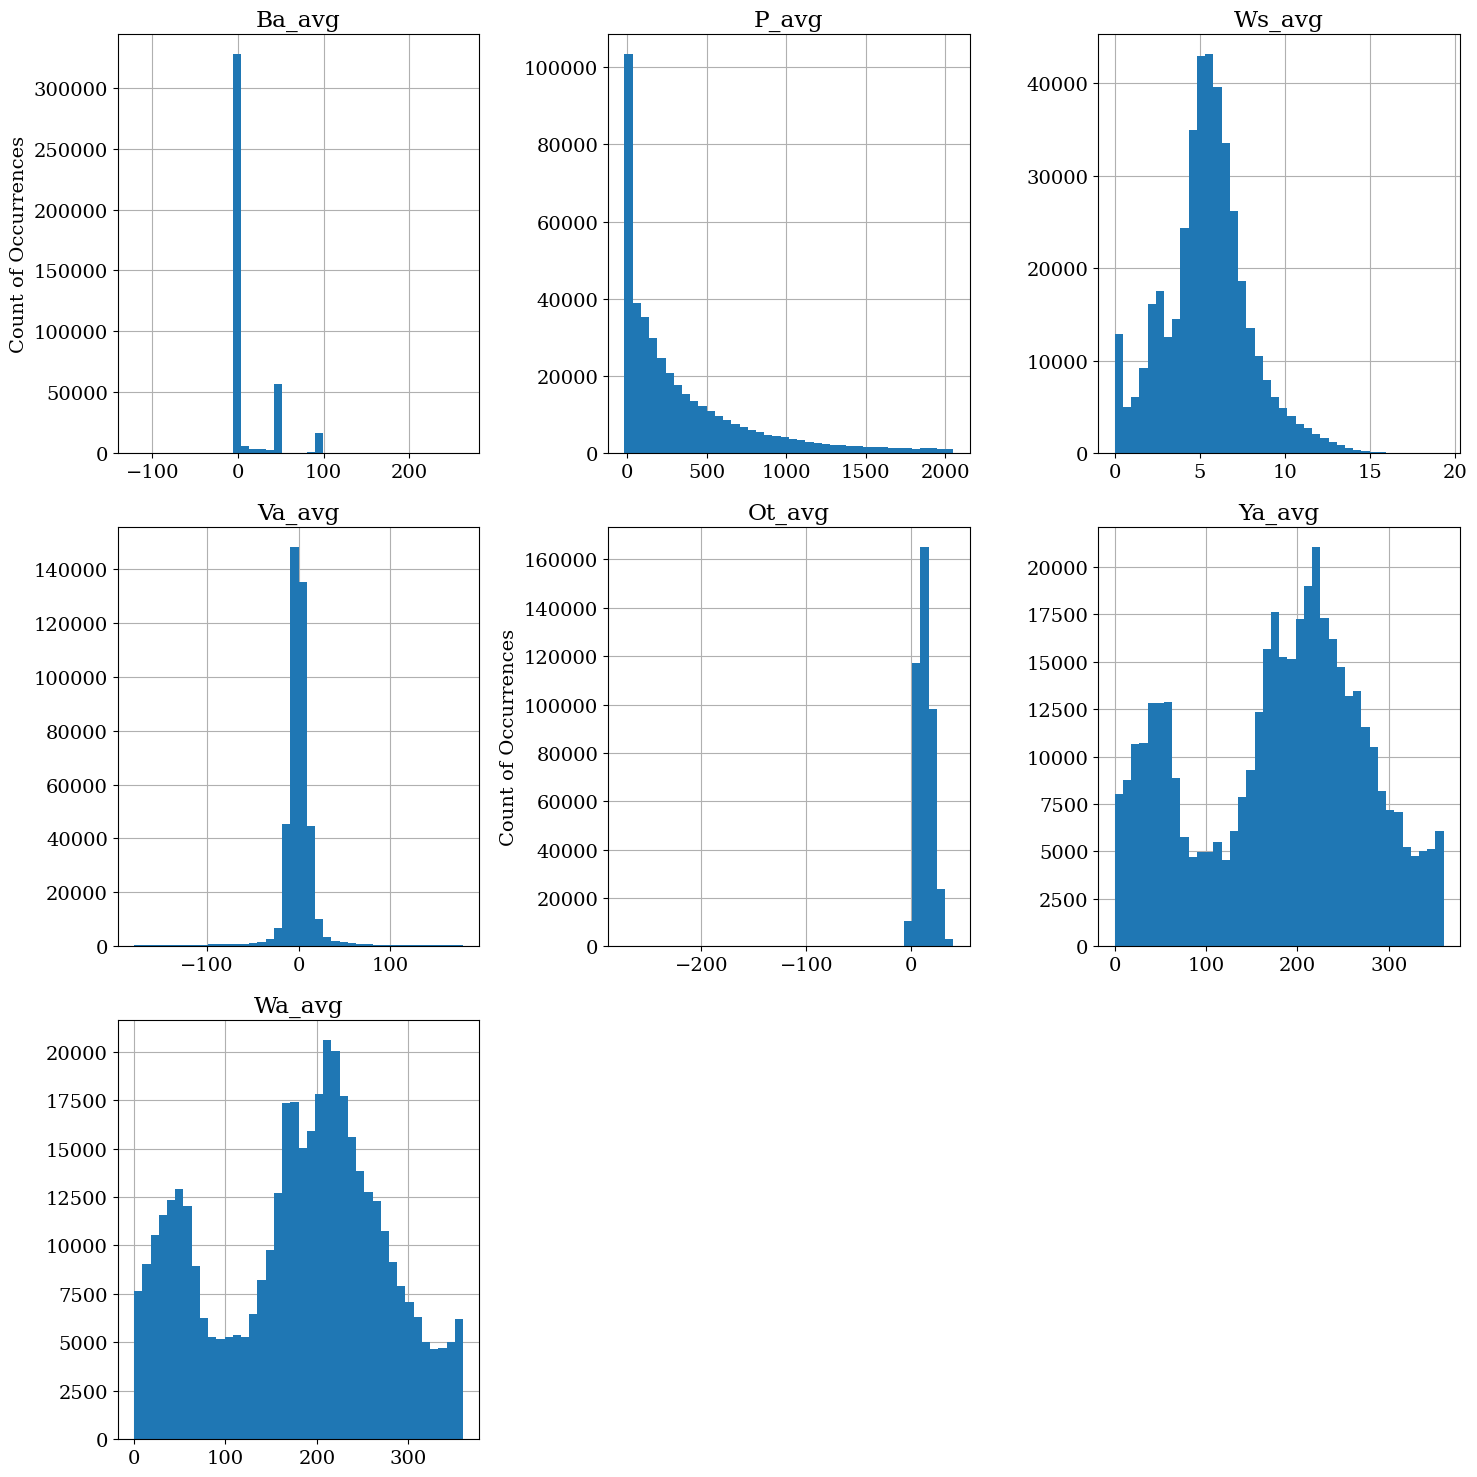

In [13]:
plot.column_histograms(scada_df_tz)

It appears that there are a number of highly frequent values in these distributions, so we can dive into that further to see if we have some unresponsive sensors, in which case the data will need to be invalidated for later analysis. In the below analysis of repeated behaviors in the data, it seems that we should be flagging potentially unresponsive sensors (see Step 5 for more details).

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


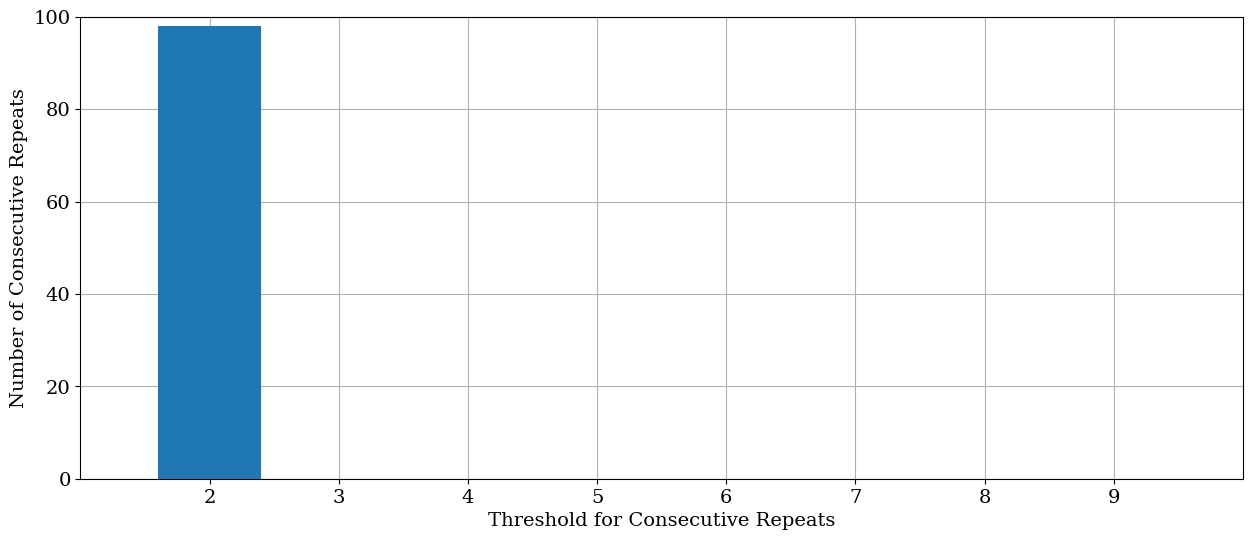

In [14]:
# Only check data for a single turbine to avoid any spurious findings
single_turbine_df = scada_df_tz.loc[scada_df_tz.Wind_turbine_name == "R80736"].copy()

# Identify consecutive data readings
ix_consecutive = single_turbine_df.Va_avg.diff(1) != 0

# Determine how many consecutive occurences are for various thresholds, starting with 2 repeats
consecutive_counts = {i + 1: (ix_consecutive.rolling(i).sum() == 0).sum() for i in range(1, 10)}

# Plot the distribution of  N occurences for each threshold
plt.bar(consecutive_counts.keys(), consecutive_counts.values(), zorder=10)
plt.grid(zorder=0)
plt.xticks(range(2, 10))
plt.xlim((1, 10))
plt.ylim(0, 100)
plt.ylabel("Number of Consecutive Repeats")
plt.xlabel("Threshold for Consecutive Repeats")
plt.show()

It's evident in the above distribution that this sensor appears to be operating adequately and won't need to have any data flagged for unresponsiveness. However, in the below example, we can see that the temperature data are potentially having faulty data and should therefore be flagged.

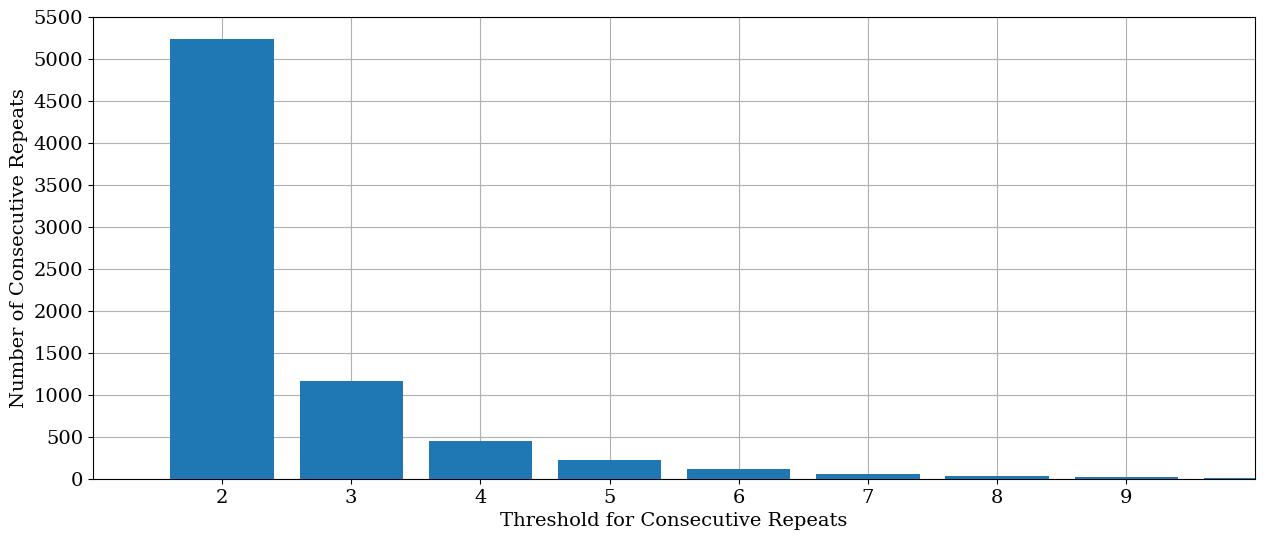

In [15]:
# Identify consecutive data readings
ix_consecutive = single_turbine_df.Ot_avg.diff(1) != 0

# Determine how many consecutive occurences are for various thresholds, starting with 2 repeats
consecutive_counts = {i + 1: (ix_consecutive.rolling(i).sum() == 0).sum() for i in range(1, 10)}

# Plot the distribution of  N occurences for each threshold
plt.bar(consecutive_counts.keys(), consecutive_counts.values(), zorder=10)
plt.grid(zorder=0)
plt.xlim((1, 10))
plt.ylim(0, 5500)
plt.xticks(range(2, 10))
plt.yticks(range(0, 5501, 500))
plt.ylabel("Number of Consecutive Repeats")
plt.xlabel("Threshold for Consecutive Repeats")
plt.show()

#### Checking the power curve distributions

While not contained in the QA module, the `plot_by_id` method is helpful for quickly assessing the quality of our operational power curves.

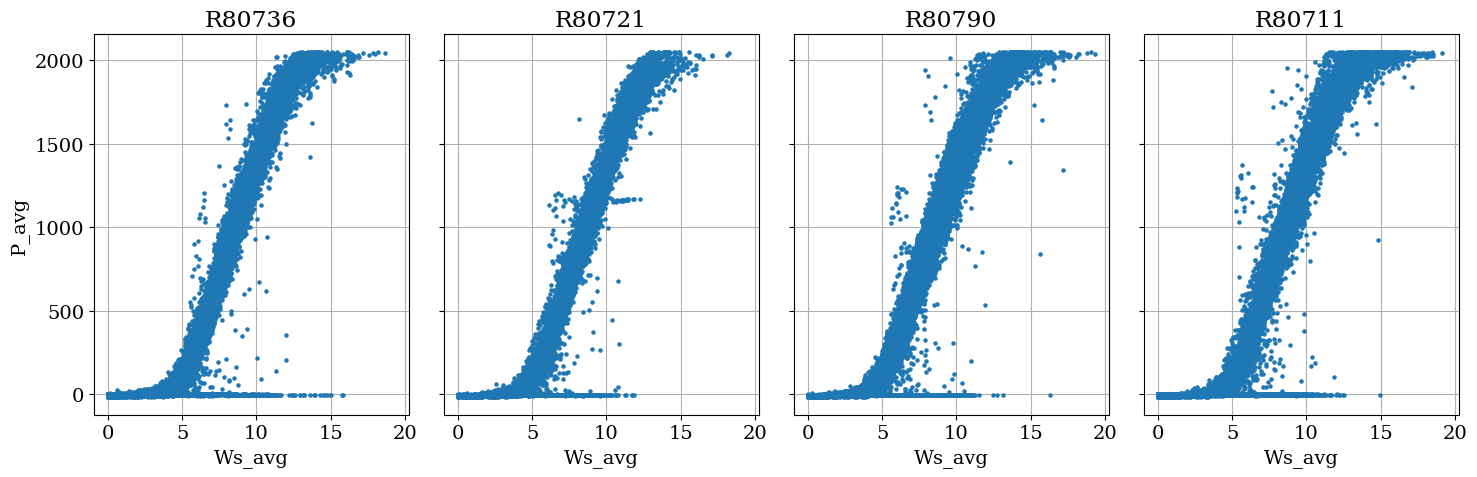

In [16]:
plot.plot_by_id(
    df=scada_df_no_tz,
    id_col="Wind_turbine_name",
    x_axis="Ws_avg",
    y_axis="P_avg",
)

### Step 4: Inspecting the timestamps for DST gaps and duplications

Now, we can get the the duplicate time stamps from each of the data sets, according to each of the original, localized, and UTC time data. This will help us to compare the effects of DST and timezone encoding.

In the below, timezone unaware data, we can see that there is a significant deviation between the local timestamps and the UTC timestamps, especialy around the end of March in both 2018 and 2019, suggesting that there is something missing with the DST data. 

#### Timezone-unaware data

First we'll look only at the data without any timezone encoding, then compare the results to the data where we kept the timezone data encoded to confirm what modifications need to be made to the data. Notice that the UTC converted data are showing duplications at roughly the same time each year when the spring-time European DST shift occurs, and is likely indicating that the original datetime stamps are missing the data to properly shift the duplicates.

In [17]:
dup_orig_no_tz, dup_local_no_tz, dup_utc_no_tz = qa.duplicate_time_identification(
    df=scada_df_no_tz,
    time_col="Date_time",
    id_col="Wind_turbine_name"
)
dup_orig_no_tz.size, dup_local_no_tz.size, dup_utc_no_tz.size

(48, 48, 48)

In [18]:
dup_utc_no_tz

Date_time_utc
2014-03-30 01:00:00+00:00   2014-03-30 01:00:00+00:00
2014-03-30 01:00:00+00:00   2014-03-30 01:00:00+00:00
2014-03-30 01:00:00+00:00   2014-03-30 01:00:00+00:00
2014-03-30 01:00:00+00:00   2014-03-30 01:00:00+00:00
2014-03-30 01:10:00+00:00   2014-03-30 01:10:00+00:00
2014-03-30 01:10:00+00:00   2014-03-30 01:10:00+00:00
2014-03-30 01:10:00+00:00   2014-03-30 01:10:00+00:00
2014-03-30 01:10:00+00:00   2014-03-30 01:10:00+00:00
2014-03-30 01:20:00+00:00   2014-03-30 01:20:00+00:00
2014-03-30 01:20:00+00:00   2014-03-30 01:20:00+00:00
2014-03-30 01:20:00+00:00   2014-03-30 01:20:00+00:00
2014-03-30 01:20:00+00:00   2014-03-30 01:20:00+00:00
2014-03-30 01:30:00+00:00   2014-03-30 01:30:00+00:00
2014-03-30 01:30:00+00:00   2014-03-30 01:30:00+00:00
2014-03-30 01:30:00+00:00   2014-03-30 01:30:00+00:00
2014-03-30 01:30:00+00:00   2014-03-30 01:30:00+00:00
2014-03-30 01:40:00+00:00   2014-03-30 01:40:00+00:00
2014-03-30 01:40:00+00:00   2014-03-30 01:40:00+00:00
2014-03-30 01:

To help confirm there are DST corrections needed in the data, we can also take a lot at the gaps in the timestamps, particularly in October. At a quick glance, the timezone unaware UTC encoding seems to create gaps in the data, likely accounting for the DST shift in the fall.

Based on the duplicated timestamps in the original data, it does seem like there is a DST correction in spring but no duplicate times in the fall. However, even with a UTC conversion, there still appear to be duplications in the data, so there is likely additional analysis needed here. While it appears that there are time gaps in the data for the original inputs, this phenomena switches seasons to the fall for the UTC converted time stamps, likely due to the lack of timezone encoding in the original inputs compared to a corrected timestamp.

In [19]:
gap_orig_no_tz, gap_local_no_tz, gap_utc_no_tz = qa.gap_time_identification(
    df=scada_df_no_tz,
    time_col="Date_time",
    freq="10T"
)
gap_orig_no_tz.size, gap_local_no_tz.size, gap_utc_no_tz.size

(12, 12, 12)

In [20]:
gap_orig_no_tz

0    2014-03-30 02:50:00
1    2015-03-29 02:10:00
2    2014-03-30 02:30:00
3    2014-03-30 02:40:00
4    2014-03-30 02:20:00
5    2015-03-29 02:00:00
6    2015-03-29 02:50:00
7    2014-03-30 02:10:00
8    2015-03-29 02:30:00
9    2015-03-29 02:40:00
10   2015-03-29 02:20:00
11   2014-03-30 02:00:00
Name: Date_time, dtype: datetime64[ns]

In [21]:
gap_utc_no_tz

0    2014-10-26 01:00:00+00:00
1    2015-10-25 01:00:00+00:00
2    2015-10-25 01:50:00+00:00
3    2015-10-25 01:10:00+00:00
4    2014-10-26 01:40:00+00:00
5    2015-10-25 01:30:00+00:00
6    2014-10-26 01:30:00+00:00
7    2015-10-25 01:40:00+00:00
8    2014-10-26 01:50:00+00:00
9    2014-10-26 01:20:00+00:00
10   2015-10-25 01:20:00+00:00
11   2014-10-26 01:10:00+00:00
Name: Date_time_utc, dtype: datetime64[ns, UTC]

Below, we can observe the effects of not having timezones encoded, and what that might mean for potential analyses. In the unaware data, it appears that the original data (blue, solid line, labeled "Original Timestamp") has a time gap in the spring; however, when we compare it to the UTC timestamp (orange, dashed line), it is clear that there is not in fact any gap in the data, and the DST transition has been encoded properly in the data. On the otherhand, it at first appears that there are no gaps in the fall when we make the same comparison, but when looking at the UTC timestamps, we can see that there is a 1 hour gap in the data for both 2014 and 2015. This is in line with our comparison of the original and UTC time gaps above, and further confirms our findings that there are duplicates in the spring and gaps in the fall.

By having the original data and a UTC-converted timestamp it enables us to see any gaps that may appear when there is no timezone data encoded. On the other hand, using the UTC-converted timestamp does not reduce the number of duplications in this dataset that are present in the spring, but helps adjust for seemingly missing or available data. In tandem we can see in the scatter points that there are still duplicates in the spring data just before the DST switch.

OverflowError: int too big to convert

<Figure size 1400x2000 with 1 Axes>

OverflowError: int too big to convert

<Figure size 1500x600 with 2 Axes>

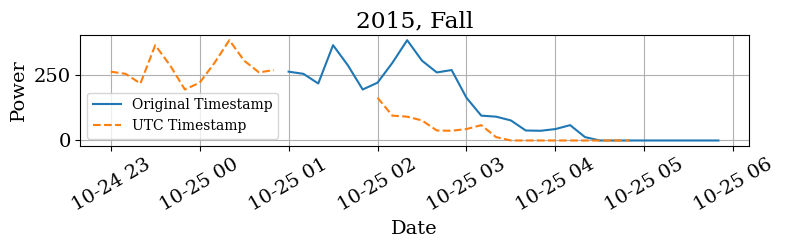

In [22]:
# Timezone Unaware
qa.daylight_savings_plot(
    df=scada_df_no_tz,
    local_tz="Europe/Paris",
    id_col="Wind_turbine_name",
    time_col="Date_time",
    power_col="P_avg",
    freq="10T",
    hour_window=3  # default value
)

OverflowError: int too big to convert

<Figure size 1400x2000 with 1 Axes>

<ipython-input-23-554aa245c638>:139: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(num_years, 2, 2 * i + 2)


OverflowError: int too big to convert

<Figure size 1500x600 with 2 Axes>

<ipython-input-23-554aa245c638>:139: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(num_years, 2, 2 * i + 2)


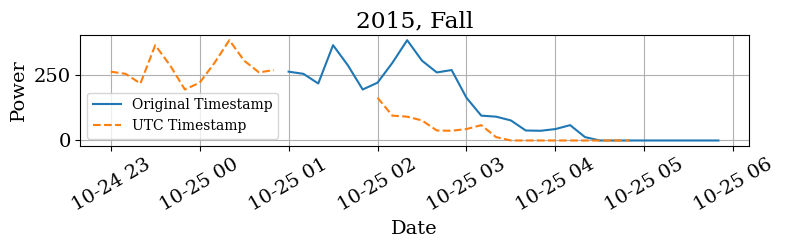

In [23]:
import openoa.utils.timeseries as ts
from openoa.utils import qa

####################################
df=scada_df_no_tz
local_tz="Europe/Paris"
id_col="Wind_turbine_name"
time_col="Date_time"
power_col="P_avg"
freq="10T"
hour_window=3
####################################

_dst = "is_dst"
t_utc = f"{time_col}_utc"
t_local = f"{time_col}_localized"

# Get data for one of the turbines
df_dst = df.loc[df[id_col] == df[id_col].unique()[0]]
df_full = df_dst.copy()

# Locate the missing timestamps, convert to UTC, and recreate DST and UTC-offset columns
missing_original = ts.find_time_gaps(df_dst[time_col], freq)
missing_local = ts.find_time_gaps(df_dst[t_local], freq)
missing_utc = ts.find_time_gaps(df_dst[t_utc], freq)

missing_df = pd.DataFrame([], columns=df.columns)
missing_df.loc[:, t_utc] = missing_utc
missing_df.loc[:, t_local] = missing_local
missing_df.loc[:, time_col] = missing_original
missing_df = missing_df.set_index(t_utc, drop=False)

# Append and resort the missing timestamps, then convert to local time
df_full = df_full.append(missing_df).sort_values(time_col)
try:
    df_full = df_full.tz_convert(local_tz)
except TypeError:
    pass

time_duplications, time_duplications_utc, _ = qa.duplicate_time_identification(
    df, time_col, id_col
)
years = df_full[time_col].dt.year.unique().astype(int)  # Years in data record
num_years = len(years)
hour_window = pd.Timedelta(hours=hour_window)
plt.figure(figsize=(14, 20))

for i, year in enumerate(years):
    year_data = df_full.loc[df_full[time_col].dt.year == year]
    dst_dates = np.where(year_data[_dst].values)[0]

    # Break the plotting loop if there is a partial year without DST in the data
    if dst_dates.size == 0:
        break

    # Get the start and end DatetimeIndex values
    start_ix = year_data.iloc[dst_dates[0]].name
    end_ix = year_data.iloc[dst_dates[-1] + 1].name

    # Create the data subsets for plotting the appropriate window
    data_spring = qa._get_time_window(year_data, start_ix, hour_window, time_col, t_local, t_utc)
    data_fall = qa._get_time_window(year_data, end_ix, hour_window, time_col, t_local, t_utc)

    data_spring = data_spring.sort_values(
        [time_col, power_col], na_position="first"
    ).drop_duplicates(subset=time_col, keep="last")
    data_fall = data_fall.sort_values(
        [time_col, power_col], na_position="first"
    ).drop_duplicates(subset=time_col, keep="last")

    # Plot each as side-by-side subplots
    plt.subplot(num_years, 2, 2 * i + 1)
    if np.sum(~np.isnan(data_spring[power_col])) > 0:
        # For localized time, we want to ensure we're capturing the DST switch as missing data
        ix_filter, time_stamps = qa._remove_tz(data_spring, time_col)
        time_stamps = pd.Series(time_stamps[ix_filter])
        power_data = data_spring.loc[ix_filter, power_col].tolist()

        # Find the missing data points on the timezone stripped data and append
        # it to the time stamps, then identify where to insert NaN in the power data
        missing = ts.find_time_gaps(time_stamps, freq)
        missing = pd.to_datetime(missing.values).to_pydatetime()
        time_stamps = np.append(time_stamps, missing)
        time_stamps.sort()
        nan_ix = sorted([np.where(el == time_stamps)[0][0] for el in missing])
        for ix in nan_ix:
            power_data.insert(ix, float("nan"))

        plt.plot(
            time_stamps,
            power_data,
            label="Original Timestamp",
            c="tab:blue",
            lw=1.5,
        )

        # Plot the duplicated time stamps as scatter points
        duplications = data_spring.loc[data_spring[time_col].isin(time_duplications)]
        if duplications.shape[0] > 0:
            ix_filter, time_stamps = qa._remove_tz(duplications, time_col)
            plt.scatter(
                time_stamps[ix_filter],
                duplications.loc[ix_filter, power_col],
                c="tab:blue",
                label="Original Timestamp Duplicates",
            )

        # Find bad timestamps, then fill in any potential UTC time gaps due the focus on the input time field
        ix_filter, time_stamps = qa._remove_tz(data_spring, t_utc)
        data_spring = ts.gap_fill_data_frame(data_spring[ix_filter], t_utc, freq)
        ix_filter, time_stamps = qa._remove_tz(data_spring, t_utc)
        plt.plot(
            time_stamps[ix_filter],
            data_spring.loc[ix_filter, power_col],
            label="UTC Timestamp",
            c="tab:orange",
            linestyle="--",
        )

        # Plot the duplicated time stamps as scatter points
        duplications = data_spring.loc[data_spring[t_utc].isin(time_duplications_utc)]
        if duplications.shape[0] > 0:
            ix_filter, time_stamps = qa._remove_tz(duplications, t_utc)
            plt.scatter(
                time_stamps[ix_filter],
                duplications.loc[ix_filter, power_col],
                c="tab:orange",
                label="UTC Timestamp Duplicates",
            )
        plt.show()

    plt.title(f"{year}, Spring")
    plt.ylabel("Power")
    plt.xlabel("Date")
    plt.legend(loc="lower left", fontsize=10)
    plt.xticks(rotation=30)
    plt.grid(True)

    plt.subplot(num_years, 2, 2 * i + 2)
    if np.sum(~np.isnan(data_fall[power_col])) > 0:
        ix_filter, time_stamps = qa._remove_tz(data_fall, time_col)
        plt.plot(
            time_stamps[ix_filter],
            data_fall.loc[ix_filter, power_col],
            label="Original Timestamp",
            c="tab:blue",
            lw=1.5,
        )

        # Plot the duplicated time stamps as scatter points
        duplications = data_fall.loc[data_fall[time_col].isin(time_duplications)]
        if duplications.shape[0] > 0:
            ix_filter, time_stamps = qa._remove_tz(duplications, time_col)
            plt.scatter(
                time_stamps[ix_filter],
                duplications.loc[ix_filter, power_col],
                c="tab:blue",
                label="Original Timestamp Duplicates",
            )

        # Find bad timestamps, then fill in any potential UTC time gaps due the focus on the input time field
        ix_filter, time_stamps = qa._remove_tz(data_fall, t_utc)
        data_fall = ts.gap_fill_data_frame(data_fall[ix_filter], t_utc, freq)
        ix_filter, time_stamps = qa._remove_tz(data_fall, t_utc)
        plt.plot(
            time_stamps[ix_filter],
            data_fall.loc[ix_filter, power_col],
            label="UTC Timestamp",
            c="tab:orange",
            linestyle="--",
        )

        # Plot the duplicated time stamps as scatter points
        duplications = data_fall.loc[data_fall[t_utc].isin(time_duplications_utc)]
        if duplications.shape[0] > 0:
            ix_filter, time_stamps = qa._remove_tz(duplications, t_utc)
            plt.scatter(
                time_stamps[ix_filter],
                duplications.loc[ix_filter, power_col],
                c="tab:orange",
                label="UTC Timestamp Duplicates",
            )

    plt.title(f"{year}, Fall")
    plt.ylabel("Power")
    plt.xlabel("Date")
    plt.legend(loc="lower left", fontsize=10)
    plt.xticks(rotation=30)
    plt.grid(True)

plt.tight_layout()
plt.show()


In [24]:
year_data

Wind_turbine_name           Date_time  Ba_avg  \
Date_time_utc                                                             
2016-01-01 00:00:00+01:00            R80736 2016-01-01 00:00:00   -0.99   
2016-01-01 00:10:00+01:00            R80736 2016-01-01 00:10:00   -0.98   
2016-01-01 00:20:00+01:00            R80736 2016-01-01 00:20:00   -0.99   
2016-01-01 00:30:00+01:00            R80736 2016-01-01 00:30:00   -0.99   
2016-01-01 00:40:00+01:00            R80736 2016-01-01 00:40:00   -0.96   
2016-01-01 00:50:00+01:00            R80736 2016-01-01 00:50:00   -0.92   

                                P_avg  Ws_avg  Va_avg  Ot_avg  Ya_avg  \
Date_time_utc                                                           
2016-01-01 00:00:00+01:00  181.450000    5.23    6.36    5.97  185.73   
2016-01-01 00:10:00+01:00  126.910000    4.80   10.82    5.91  185.73   
2016-01-01 00:20:00+01:00  185.929990    5.32   13.25    5.98  185.73   
2016-01-01 00:30:00+01:00  148.480000    4.96   15.81    6.10  185.73   
2016-01-01 00:40:00+01:00  102.450000    4.59   15.94    6.09  185.73   
2016-01-01 00:50:00+01:00   82.839996    4.47   18.24    6.07  185.73   

                              Wa_avg       Date_time_localized  \
Date_time_utc                                                    
2016-01-01 00:00:00+01:00  192.12000 2016-01-01 00:00:00+01:00   
2016-01-01 00:10:00+01:00  196.53999 2016-01-01 00:10:00+01:00   
2016-01-01 00:20:00+01:00  198.99001 2016-01-01 00:20:00+01:00   
2016-01-01 00:30:00+01:00  201.58000 2016-01-01 00:30:00+01:00   
2016-01-01 00:40:00+01:00  201.63000 2016-01-01 00:40:00+01:00   
2016-01-01 00:50:00+01:00  203.99001 2016-01-01 00:50:00+01:00   

                                      Date_time_utc      utc_offset is_dst  
Date_time_utc                                                               
2016-01-01 00:00:00+01:00 2015-12-31 23:00:00+00:00 0 days 01:00:00  False  
2016-01-01 00:10:00+01:00 2015-12-31 23:10:00+00:00 0 days 01:00:00  False  
2016-01-01 00:20:00+01:00 2015-12-31 23:20:00+00:00 0 days 01:00:00  False  
2016-01-01 00:30:00+01:00 2015-12-31 23:30:00+00:00 0 days 01:00:00  False  
2016-01-01 00:40:00+01:00 2015-12-31 23:40:00+00:00 0 days 01:00:00  False  
2016-01-01 00:50:00+01:00 2015-12-31 23:50:00+00:00 0 days 01:00:00  False

In [25]:
start_ix, end_ix

(Timestamp('2015-10-25 02:30:00+0100', tz='Europe/Paris'),
 Timestamp('2015-10-25 03:00:00+0100', tz='Europe/Paris'))

In [26]:
np.where(year_data[_dst].values)[0]

array([], dtype=int64)

In [27]:
year_data = df_full.loc[df_full[time_col].dt.year == year]
dst_dates = np.where(year_data[_dst].values)[0]

# Get the start and end DatetimeIndex values
start_ix = year_data.iloc[dst_dates[0]].name
end_ix = year_data.iloc[dst_dates[-1] + 1].name

# Create the data subsets for plotting the appropriate window
data_spring = qa._get_time_window(year_data, start_ix, hour_window, time_col, t_local, t_utc)
data_fall = qa._get_time_window(year_data, end_ix, hour_window, time_col, t_local, t_utc)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
year_data = df_full.loc[df_full[time_col].dt.year == year]

In [ ]:
dst_dates = np.where(year_data[_dst].values)[0]
dst_dates[0], dst_dates[-1]

In [ ]:
year_data.iloc[[dst_dates[0]]]

In [ ]:
df_full.iloc[12500:12600]

#### Timezone-aware data

We see a similar finding for timezeone-aware data, below, for the both the number of duplications and gaps, likely confirming our hunches from above.

In [ ]:
dup_orig_tz, dup_local_tz, dup_utc_tz = qa.duplicate_time_identification(
    df=scada_df_tz,
    time_col="Date_time",
    id_col="Wind_turbine_name"
)

In [ ]:
dup_orig_tz.size, dup_local_tz.size, dup_utc_tz.size

In [ ]:
dup_utc_tz

In [ ]:
gap_orig_tz, gap_local_tz, gap_utc_tz = qa.gap_time_identification(
    df=scada_df_tz,
    time_col="Date_time",
    freq="10T"
)
gap_orig_tz.size, gap_local_tz.size, gap_utc_tz.size

In [ ]:
gap_utc_tz

Again, we see a high degree of similarity between the two examples, and so can confirm that we have some duplicated data in the spring unrelated to the DST shift, and some missing data in the fall likely due to the DST shift. Additionally, we can confirm that the Europe/Paris timezone is in fact the encoding of our original data, and should therefore be converted to UTC for later analyses.

In [ ]:
# Timezone Aware
qa.daylight_savings_plot(
    df=scada_df_tz,
    local_tz="Europe/Paris",
    id_col="Wind_turbine_name",
    time_col="Date_time",
    power_col="P_avg",
    freq="10T",
    hour_window=3  # default value
)

## Summarizing the QA process into a reproducible workflow

The following description summarizes the steps taken to successfully import the ENGIE SCADA data based on the above analysis, and are implemented in the `project_ENGIE.prepare()` method. It should be noted that this method is cleaned up to provide users with an easy to follow example, it could also be contained in an analysis notebook, stand-alone script, etc., as long as it is able to feed into `PlantData` at the end of it.

1. From [Step 2](#Step-2:-Convert-the-timestamps-to-proper-timestamp-data-objects) and [Step 4](#Step-4:-Inspecting-the-timestamps-for-DST-gaps-and-duplications) we found that the data is in local time and should be converted to UTC for clarity in the timestamps. THis corresponds with line `project_ENGIE.py:79`.
2. Additionally from [Step 4](#Step-4:-Inspecting-the-timestamps-for-DST-gaps-and-duplications), it was clear that duplicated timestamp data will need to be removed, corresponding to line `project_ENGIE.py:82`
3. In [Step 3](#Step-3:-Dive-into-the-data), there is an oversized range for the temperature data, so this data will be invalidated, corresponding to line `project_ENGIE.py:86`
4. In [Step 3](#Step-3:-Dive-into-the-data), the wind vane direction ("Va_avg") and temperature ("Ot_avg") fields seemed to have a large number duplicated data that were identified, so these data are flagged and invalidated, which corresponds to lines `project_ENGIE.py:88-102`
5. Finally, in [Step 3](#Step-3:-Dive-into-the-data), it also should be noted that the pitch direction ranges from 0 to 360 degrees, and this will be corrected to the range of [-180, 180], which corresponds to lines: `project_ENGIE.py:105-107`

The remainder of the data do not need modification aside from additional variable calculations (see `project_ENGIE.py` for more details) and the aforementioned timestamp conversions.

## `PlantData` demonstration

In `project_ENGIE.prepare()` there are two methods to return the data: by dataframe (`return_value="dataframes"`) and by `PlantData` (`return_value="plantdata"`), which are both demonstrated below.

For the dataframe return selection, below it is also demonstrated how to load the dataframes into a `PlantData` object. A couple of things to notice about the creation of the the v3 `PlantData` object: 
- `metadata`: This field is what maps the OpenOA column convention to the user's column naming convention (`PlantData.update_column_names(to_original=True)` enables users to remap the data back to their original naming convention), in addition to a few other plant metadata objects.
- `analysis_type`: This field controls how the data will be validated, if at all, based on the analysis requirements defined in `openoa.plant.ANALYSIS_REQUIREMENTS`.


In [ ]:
scada_df, meter_df, curtail_df, asset_df, reanalysis_dict = project_ENGIE.prepare(
    path="data/la_haute_borne",
    return_value="dataframes"
)

engie = PlantData(
    analysis_type=None,  # No validation desired at this point in time
    metadata="data/plant_meta.yml",
    scada=scada_df,
    meter=meter_df,
    curtail=curtail_df,
    asset=asset_df,
    reanalysis=reanalysis_dict,
)

Below is a summary of what the `PlantData` and `PlantMetaData` object specifications are, which are both new or effectively new as of version 3.0

### `PlantData` documentation

In [ ]:
print(PlantData.__doc__)

### `PlantMetaData` Documentation

In [ ]:
from openoa.plant import PlantMetaData
print(PlantMetaData.__doc__)

### `PlantData` validation

Because `PlantData` is an attrs dataclass, it enables to support automatic conversion and validation of variables, which enables users to change analysis types as they work through their data. Below is a demonstration of what happens when we add an invalid analysis type (which fails to enable it), add the "MonteCarloAEP" analysis type (which passes the validation), and then further add in the "all" analysis type (which fails).

In [ ]:
try:
    engie.analysis_type = "MonteCarlo"
except ValueError as e:
    print(e)

In [ ]:
engie.analysis_type = "MonteCarloAEP"
engie.validate()

Notice that in the above cell, the data validates successfully for the MonteCarloAEP analysis, but below, when we append the `"all"` type, the validation fails. The below failure is because when `"all"` is input to `analysis_type`, it checks all of the data, and not just the analysis categories. In this case, there are no inputs to `tower` and `status`, so each of the checks will fail for all of the required columns by the metadata classifications.

In [ ]:
engie.analysis_type.append("all")
print(f"The new analysis types now has all and MonteCarloAEP: {engie.analysis_type}")
try:
    engie.validate()
except ValueError as e: # Catch the error message so that the whole notebook can run
    print(e)

Below, the ENGIE data has been re-validated for a "MonteCarloAEP" analysis, so that it can be saved for later, and reloaded as the cleaned up version for easier importing.

In [ ]:
engie.analysis_type = "MonteCarloAEP"
engie.validate()

In [ ]:
data_path = "data/cleansed"
engie.to_csv(save_path=data_path, with_openoa_col_names=True)

In [ ]:
engie_clean = PlantData(
    metadata=f"{data_path}/metadata.yml",
    scada=f"{data_path}/scada.csv",
    meter=f"{data_path}/meter.csv",
    curtail=f"{data_path}/curtail.csv",
    status=f"{data_path}/scada.csv",
    asset=f"{data_path}/asset.csv",
    reanalysis={
        "era5": f"{data_path}/reanalysis_era5.csv",
        "merra2": f"{data_path}/reanalysis_merra2.csv"
    },
)

# Demonstrating the Utils With the ENGIE Open Data

ENGIE provides access to the data of its "La Haute Borne" wind farm through https://opendata-renewables.engie.com and through an API. The data can be used to create additional turbine objects and gives users the opportunity to work with further real-world data. 

The series of notebooks in the "examples" folder uses SCADA data downloaded from https://opendata-renewables.engie.com, saved in the "examples/data" folder. Additional plant level meter, availability, and curtailment data were synthesized based on the SCADA data.

In the following example, data is loaded into a turbine object and plotted as a power curve. The selected turbine can be changed if desired.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import databricks.koalas as pd # replaces: "import pandas as pd"

import sys
sys.path.insert(1, "/home/jovyan/OpenOA/")

from bokeh.plotting import show
from bokeh.io import output_notebook
output_notebook()

from openoa.utils import filters, power_curve, plot

import project_ENGIE

Loading BokehJS ...

## Import the data

In [2]:
project = project_ENGIE.prepare("./data/la_haute_borne", return_value="plantdata")

/opt/miniconda3/envs/openoa/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:112: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  values = construct_1d_object_array_from_listlike(values)


Now the data is imported we can take a look at the wind farm. There are 4 turbines, nearby foresty, a small town and neighbouring wind farms, which could impact on performance. Now lets have a look at the turbines.

**NOTE**: Here we've dropped the geometry column because the `Point` objects can't be serialized with JSON and therefore are incompatible with bokeh's plotting routines. This doesn't delete the column entirely, just for the data passed into the below plotting routine, as can be seen below in the display of the asset table.

In [3]:
show(plot.plot_windfarm(project.asset, tile_name="OpenMap", plot_width=600, plot_height=600))

In [4]:
project.asset

latitude  longitude  elevation  rated_power  hub_height  \
id                                                                
R80711   48.4569     5.5847      411.0       2050.0        80.0   
R80721   48.4497     5.5869      411.0       2050.0        80.0   
R80736   48.4461     5.5925      411.0       2050.0        80.0   
R80790   48.4536     5.5875      411.0       2050.0        80.0   

        rotor_diameter Manufacturer Model     type  \
id                                                   
R80711            82.0      Senvion  MM82  turbine   
R80721            82.0      Senvion  MM82  turbine   
R80736            82.0      Senvion  MM82  turbine   
R80790            82.0      Senvion  MM82  turbine   

                                           geometry              x  \
id                                                                   
R80711  POINT (691090.6427551308 5370311.819848928)  621685.960233   
R80721  POINT (691280.3372171954 5369517.101146102)  621930.863113   
R80736  POINT (691707.9356258928 5369131.008403568)  622554.252261   
R80790  POINT (691310.0390609576 5369952.051504721)  621997.654807   

                   y        coordinates  
id                                       
R80711  6.183206e+06  (48.4569, 5.5847)  
R80721  6.181998e+06  (48.4497, 5.5869)  
R80736  6.181393e+06  (48.4461, 5.5925)  
R80790  6.182652e+06  (48.4536, 5.5875)

In [5]:
# List of turbines
turb_list = project.turbine_ids
turb_list

array(['R80711', 'R80721', 'R80736', 'R80790'], dtype=object)

Let"s examine the first turbine from the list above.

In [6]:
turbine_df = project.scada.loc[project.scada.index.get_level_values("id") == turb_list[0]]

ix_nan = turbine_df.windspeed.isna() | turbine_df.power.isna()
windspeed = turbine_df.loc[~ix_nan, "windspeed"].copy()
power_kw = turbine_df.loc[~ix_nan, "power"].copy()

First, we"ll make a scatter plot the raw power curve data. Notice that `example_flag` is a truth array where all values are `True`, so all of the data points are orange. However, in later plots, more meaningful filters will be explored.

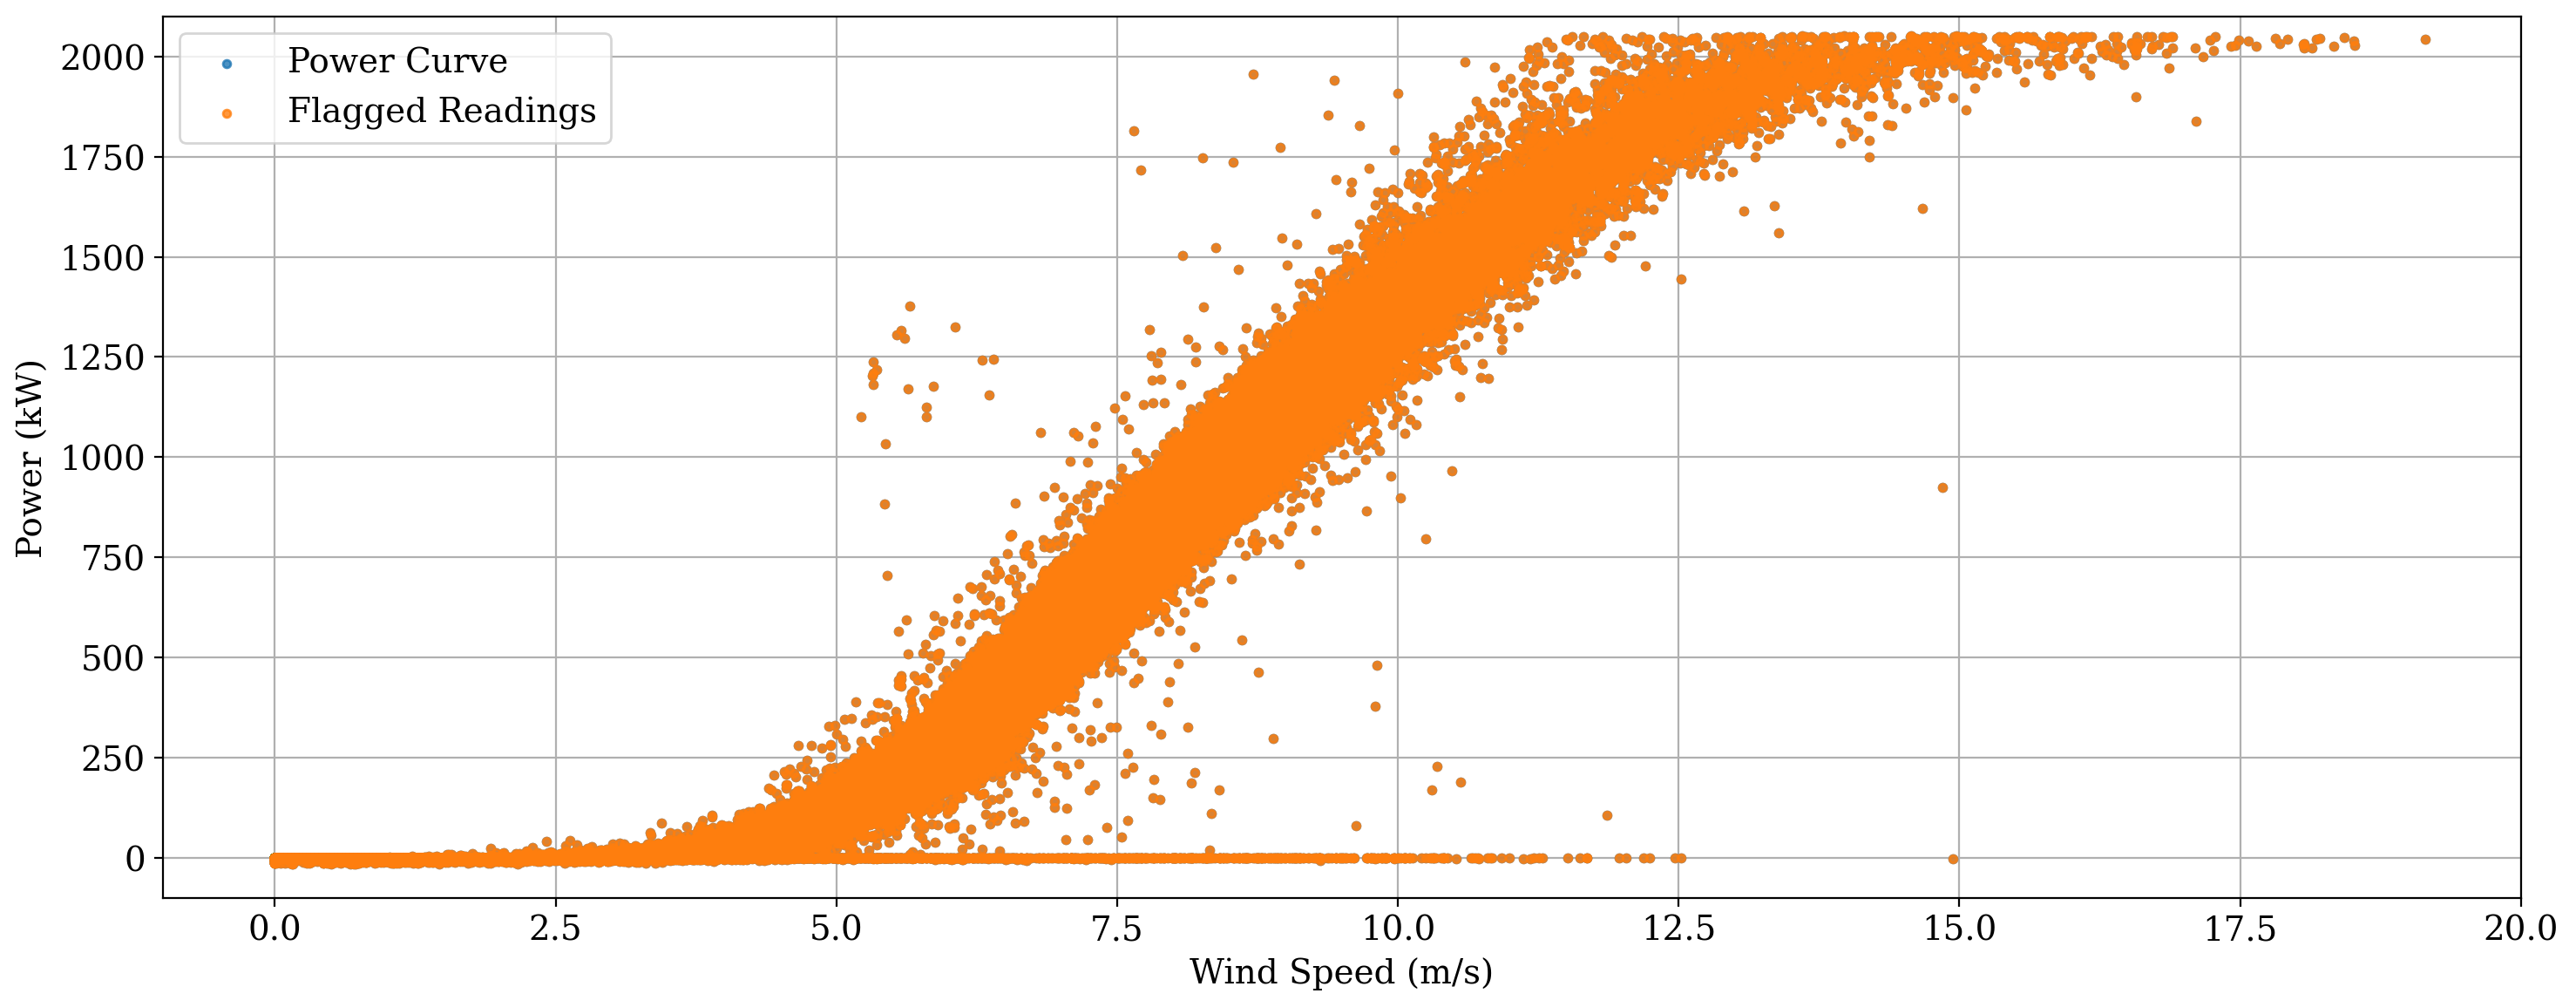

In [7]:
example_flag = np.ones(windspeed.shape, dtype=bool)
plot.plot_power_curve(
    windspeed,
    power_kw,
    flag=example_flag,
    xlim=(-1, 20),  # optional input for refining plots
    ylim=(-100, 2100),  # optional input for refining plots
    legend=True,  # optional flag for adding a legend
    scatter_kwargs=dict(alpha=0.8, s=10)  # optional input for refining plots
)

## Range filter

Notice that none of the wind speeds are out of the acceptable range, so no plotting will be produced for this demonstration.

In [8]:
out_of_range = filters.range_flag(windspeed, lower=0, upper=70)
windspeed[out_of_range].head()

Series([], Name: windspeed, dtype: float64)

## Window range filter

Now, we"ll apply a window range filter to remove data with power values outside of the window from 20 to 2100 kW for wind speeds between 5 and 40 m/s. Notice the band of orange points along the 0 kW line starting at 5 m/s representing these values.

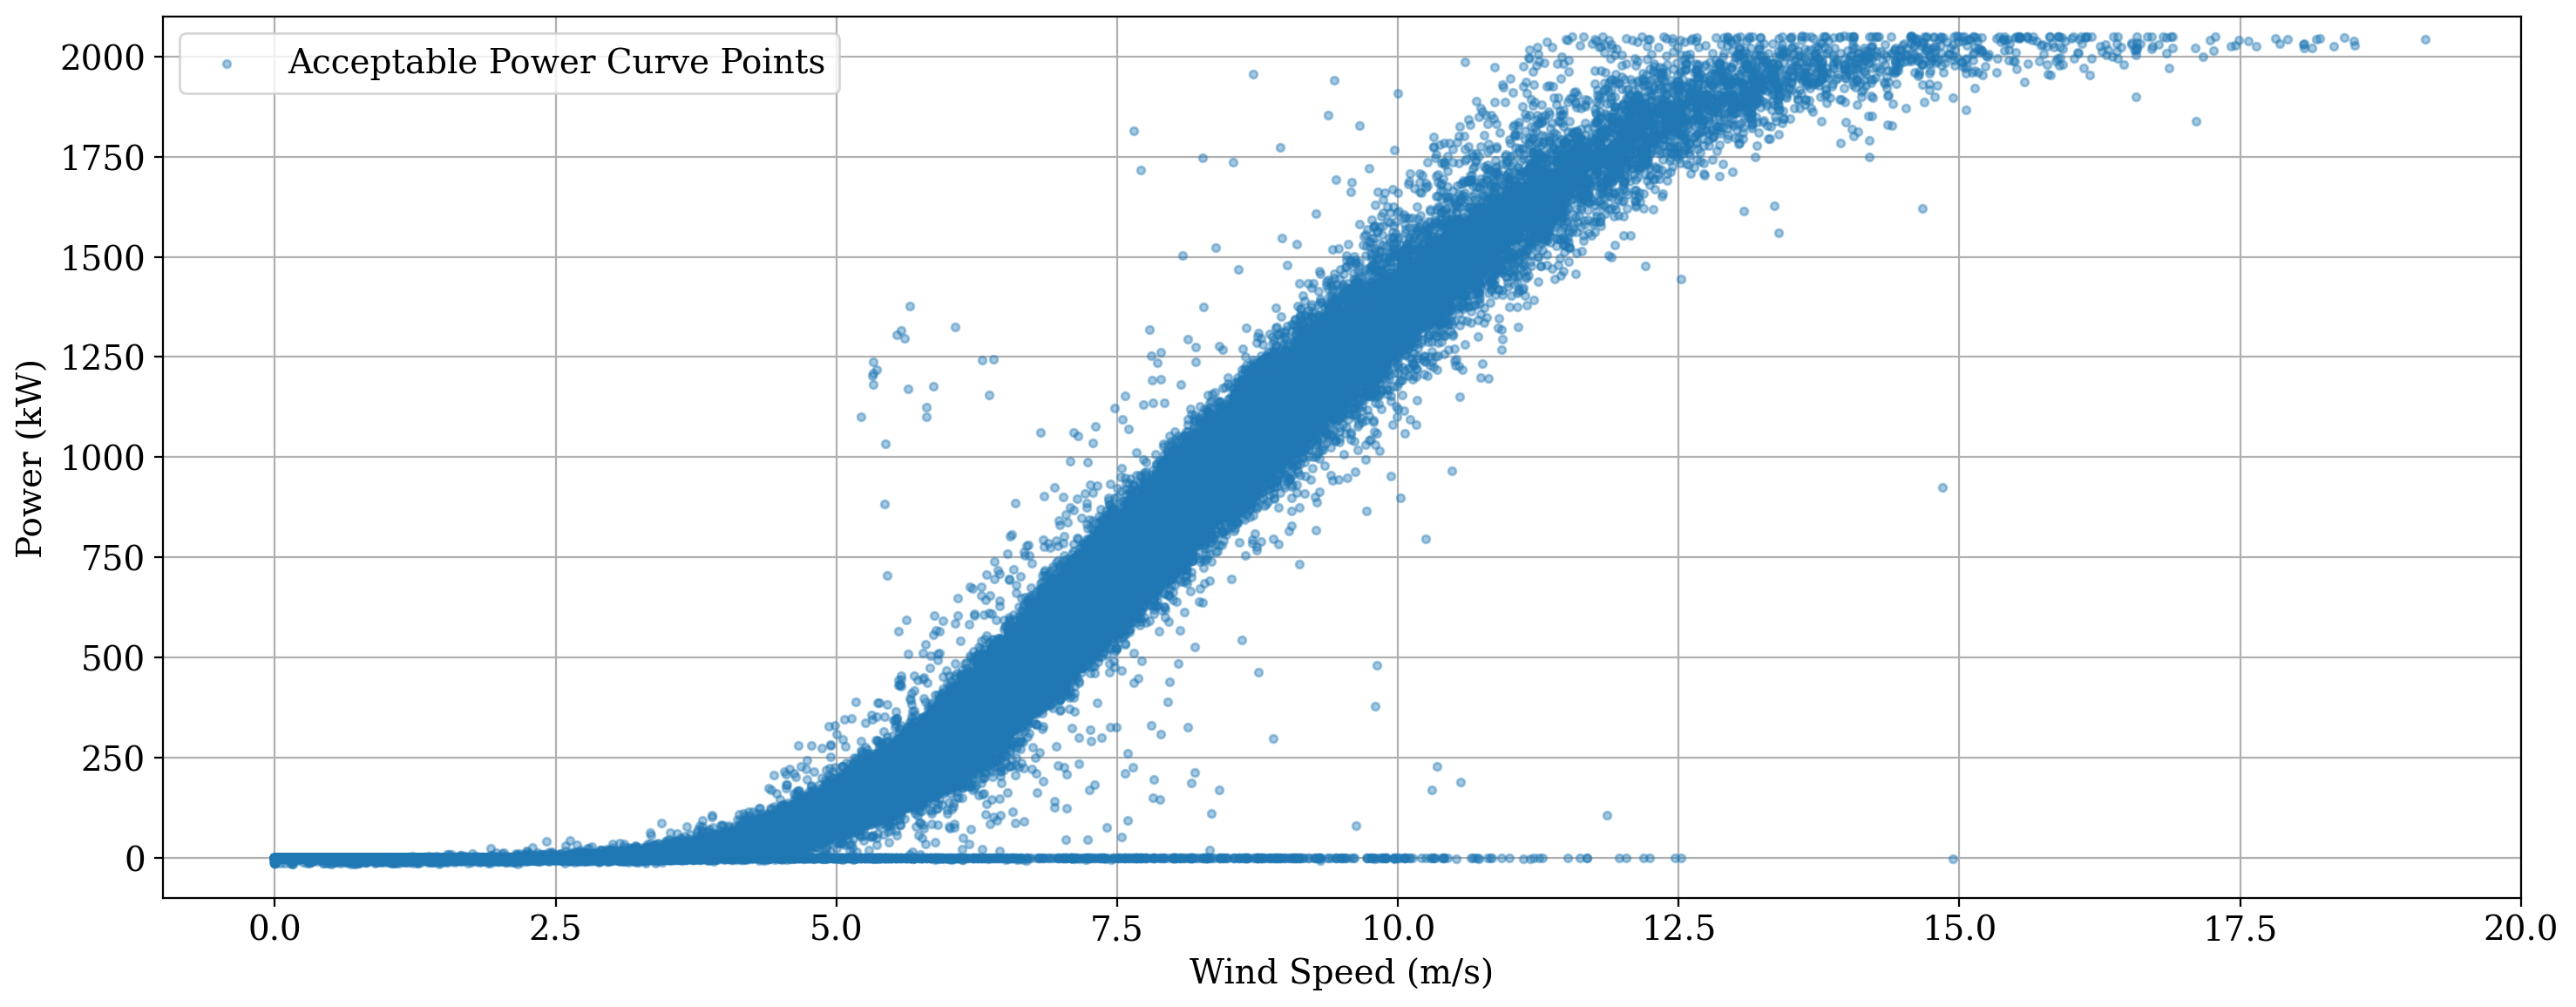

In [9]:
out_of_window = filters.window_range_flag(windspeed, 5., 40, power_kw, 20., 2100.)
plot.plot_power_curve(
    windspeed,
    power_kw,
    flag=out_of_window,
    flag_labels=("Outside Acceptable Window", "Acceptable Power Curve Points"),
    xlim=(-1, 20),  # optional input for refining plots
    ylim=(-100, 2100),  # optional input for refining plots
    legend=True,  # optional flag for adding a legend
    scatter_kwargs=dict(alpha=0.4, s=10)  # optional input for refining plots
)

Let"s remove these flagged data from consideration.

In [10]:
windspeed_filt1 = windspeed[~out_of_window]
power_kw_filt1 = power_kw[~out_of_window]

## Bin filter

We may be interested in fitting a power curve to data representing "normal" turbine operation. In other words, we want to flag all anomalous data or data represenatative of underperformance. To do this, the "bin_filter" function is useful. It works by binning the data by a specified variable, bin width, and start and end points. The criteria for flagging is based on some measure (scalar or standard deviation) from the mean or median of the bin center. 

As an example, let"s bin on power in 100 kW increments, starting from 25.0 kW but stopping at 90% of peak power (i.e. we don"t want to flag all the data at peak power and high wind speed. Let"s use a scalar threshold of 1.5 m/s from the median for each bin. Let"s also consider data on both sides of the curve by setting the "direction" parameter to "all"

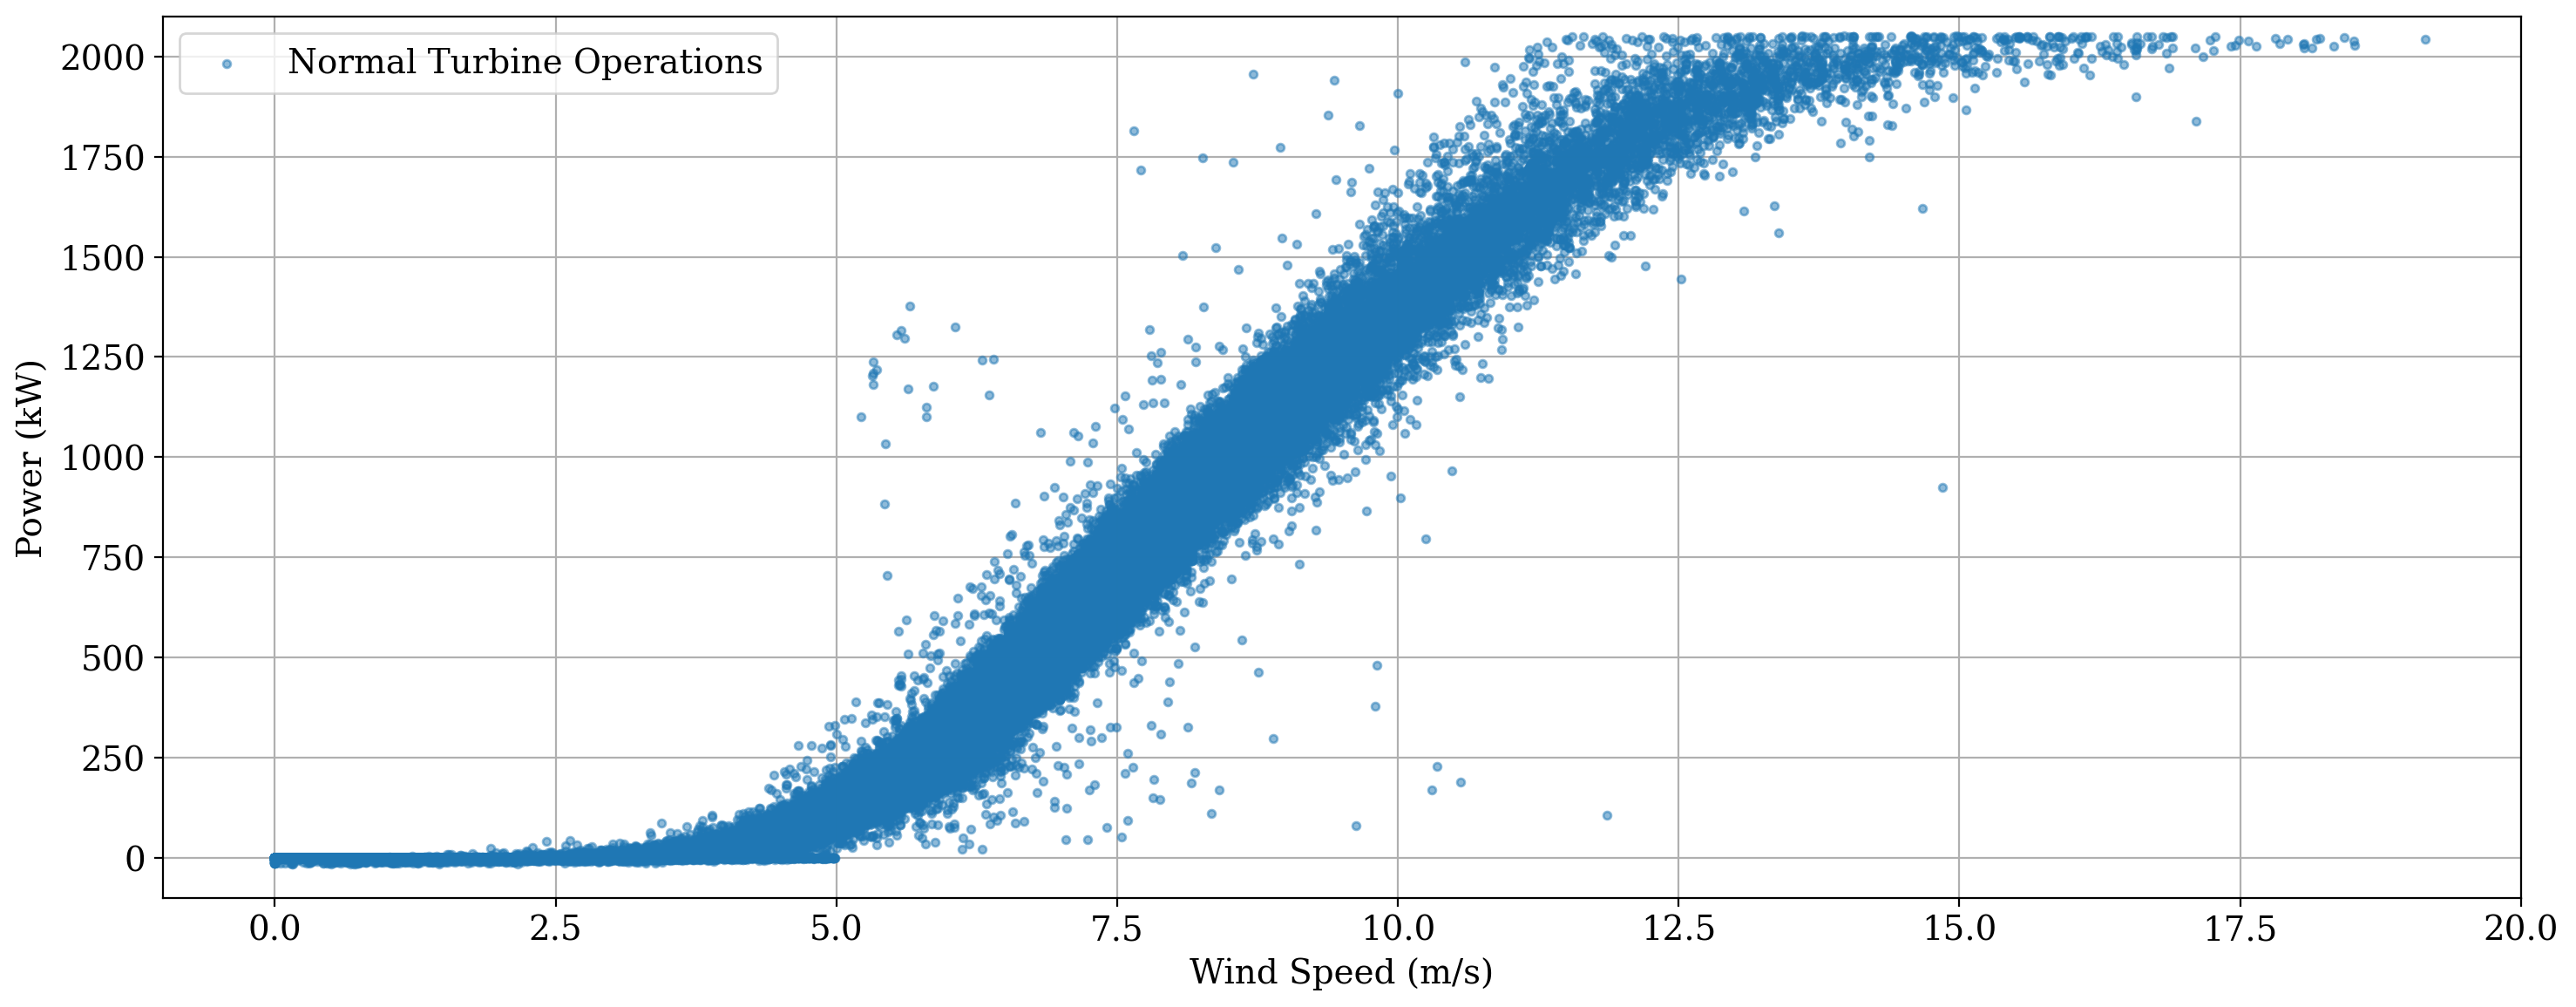

In [11]:
max_bin = 0.90 * power_kw_filt1.max()
bin_outliers = filters.bin_filter(power_kw_filt1, windspeed_filt1, 100, 1.5, "median", 20., max_bin, "scalar", "all")
plot.plot_power_curve(
    windspeed_filt1,
    power_kw_filt1,
    flag=bin_outliers,
    flag_labels=("Anomylous Data", "Normal Turbine Operations"),
    xlim=(-1, 20),  # optional input for refining plots
    ylim=(-100, 2100),  # optional input for refining plots
    legend=True,  # optional flag for adding a legend
    scatter_kwargs=dict(alpha=0.5, s=10)  # optional input for refining plots
)

As seen above, one call for the bin filter has done a decent job of cleaning up the power curve to represent "normal" operation, without excessive removal of data points. There are a few points at peak power but low wind speed that weren"t flagged, however. Let catch those, and then remove those as well as the flagged data above, and plot our "clean" power curve 

In [12]:
windspeed_filt2 = windspeed_filt1[~bin_outliers]
power_kw_filt2 = power_kw_filt1[~bin_outliers]

## Unresponsive Filter

As a final filtering demonstration, we can look for an unrespsonsive sensor (i.e. repeating measurements). In this case, let"s look for 3 or more repeating wind speed measurements:

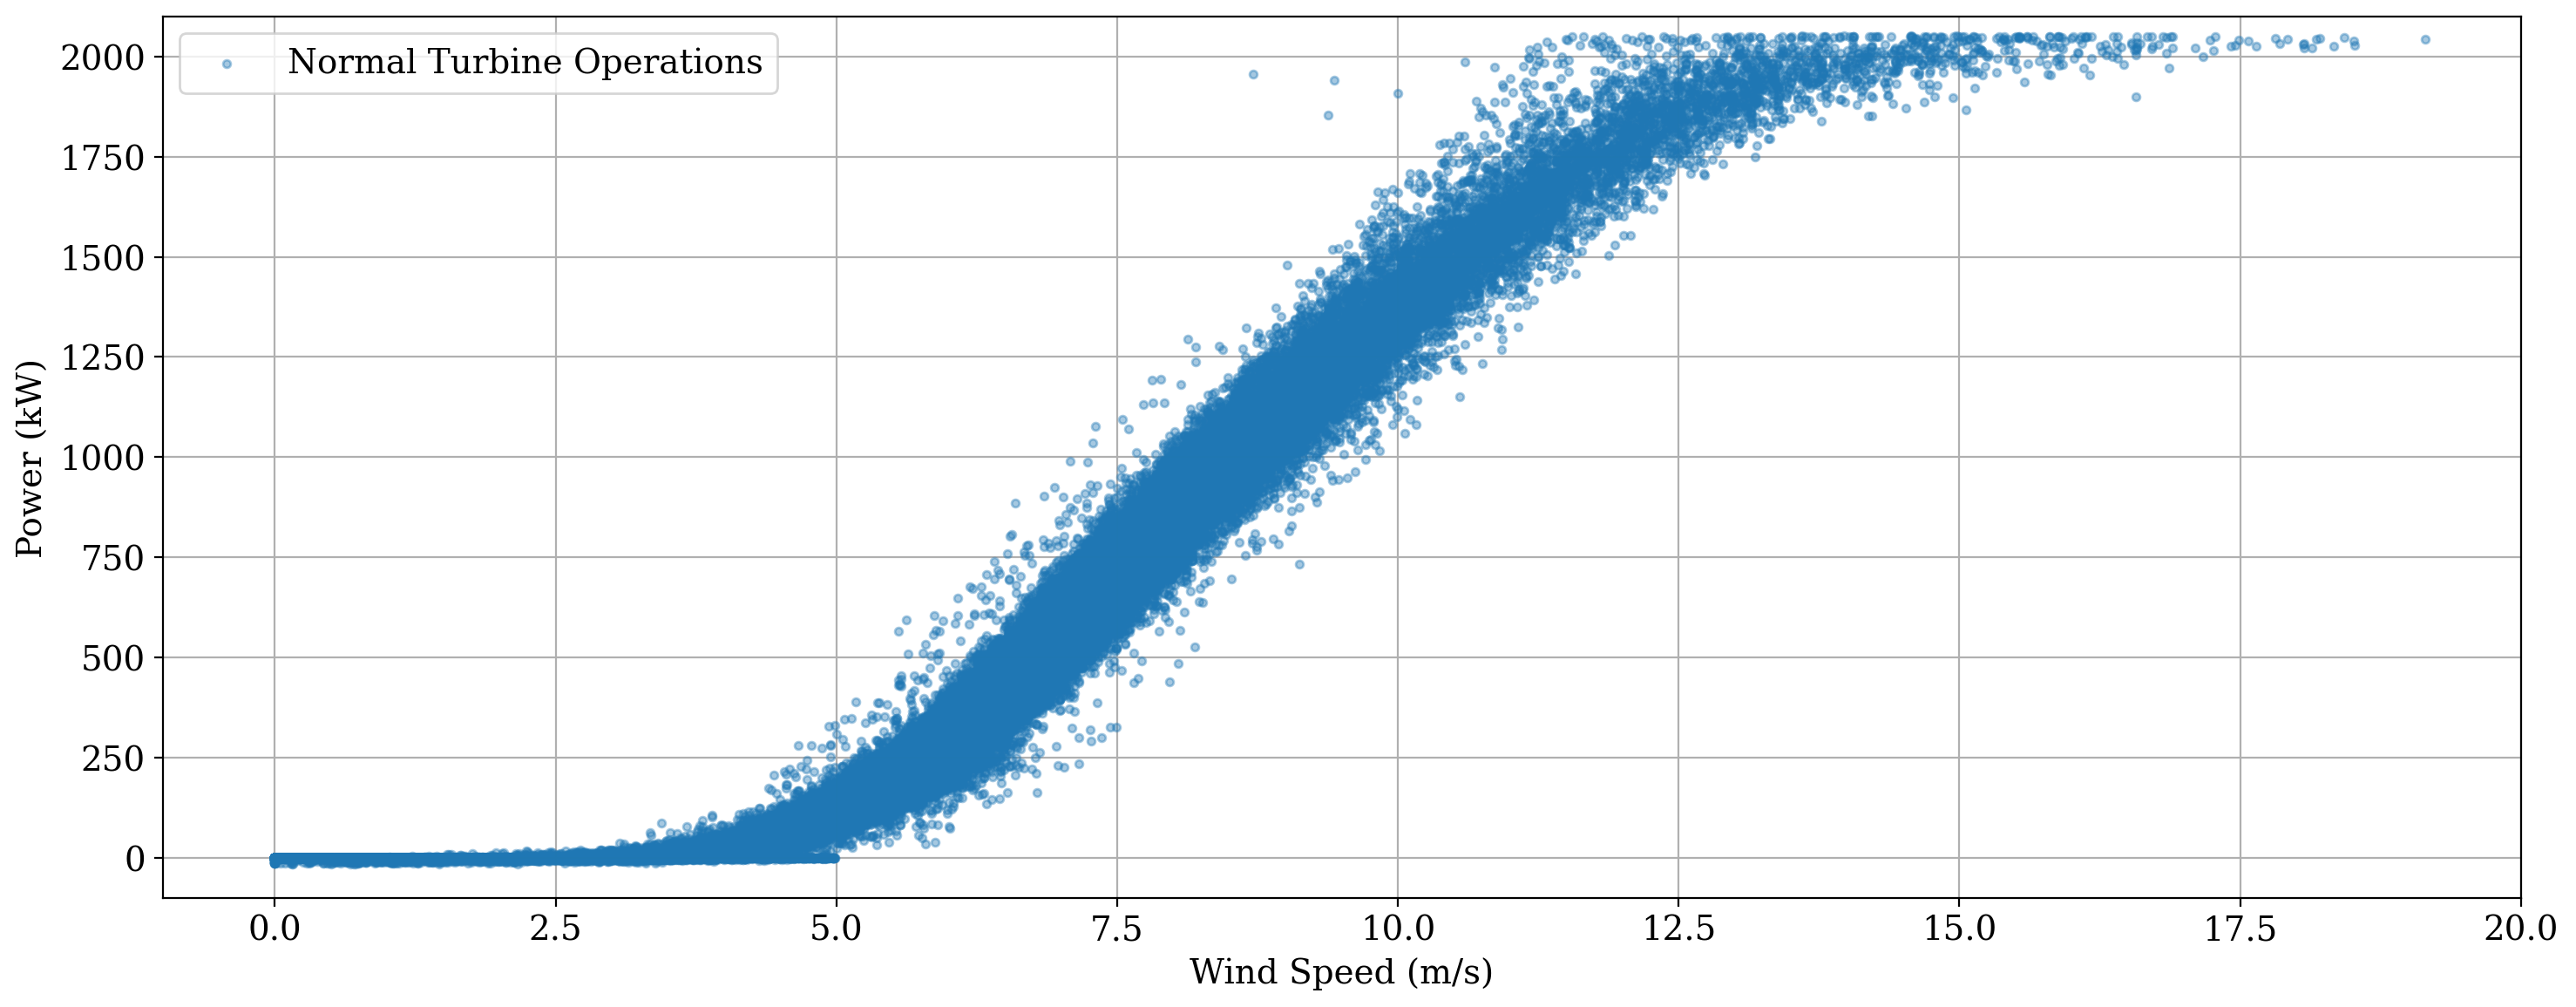

In [13]:
frozen = filters.unresponsive_flag(windspeed_filt2, 3)
plot.plot_power_curve(
    windspeed_filt2,
    power_kw_filt2,
    flag=frozen,
    flag_labels=(f"Unresponsive Sensors (n={frozen.sum():,.0f})", "Normal Turbine Operations"),
    xlim=(-1, 20),  # optional input for refining plots
    ylim=(-100, 2100),  # optional input for refining plots
    legend=True,  # optional flag for adding a legend
    scatter_kwargs=dict(alpha=0.4, s=10)  # optional input for refining plots
)

We actually found a lot, so let"s remove these data as well before moving on to power curve fitting.

Note that many of the unresponsive sensor values identified above are likely caused by the discretization of the data to only two decimal places. However, the goal is to illustrate the filtering process.

In [14]:
windspeed_final = windspeed_filt2[~frozen]
power_kw_final = power_kw_filt2[~frozen]

## Power curve fitting

We will now consider three different models for fitting a power curve to the SCADA data.

In [15]:
# Fit the power curves
iec_curve = power_curve.IEC(windspeed_final, power_kw_final)
l5p_curve = power_curve.logistic_5_parametric(windspeed_final, power_kw_final)
spline_curve = power_curve.gam(windspeed_final, power_kw_final, n_splines = 20)

/Users/rhammond/Documents/GitHub/OpenOA/openoa/utils/power_curve/parametric_forms.py:38: RuntimeWarning: overflow encountered in power
  return d + (a - d) / (1 + (x / c) ** b) ** g


First, we"ll generate the base plot, and with the returned figure and axes objects, we"ll overlay the fitted power curves to highlight their fit.

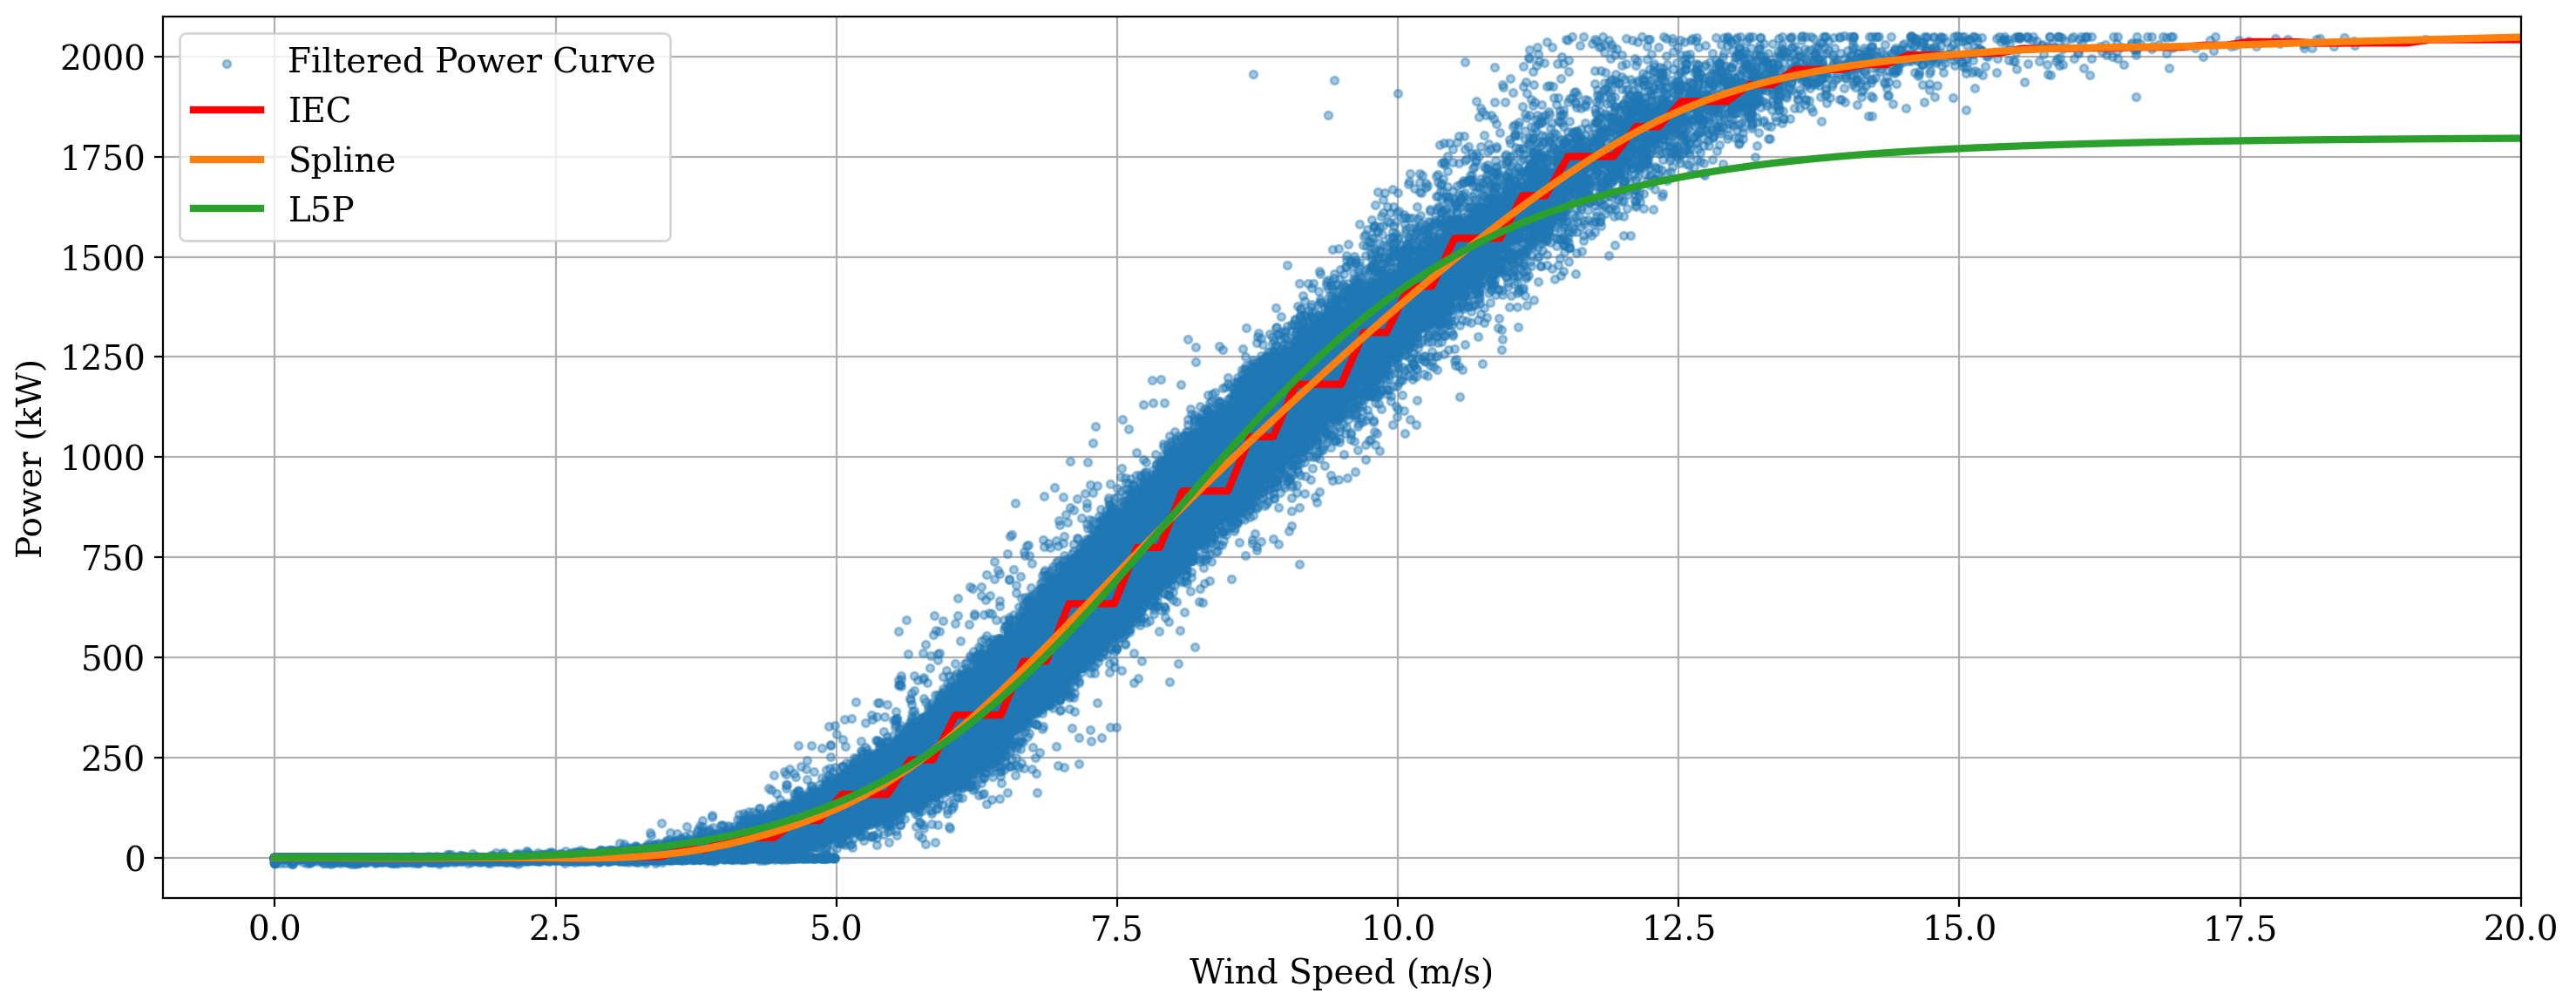

In [16]:
fig, ax = plot.plot_power_curve(
    windspeed_final,
    power_kw_final,
    flag=np.zeros(windspeed_final.shape, dtype=bool),
    flag_labels=("", "Filtered Power Curve"),
    xlim=(-1, 20),  # optional input for refining plots
    ylim=(-100, 2100),  # optional input for refining plots
    legend=False,  # optional flag for adding a legend
    scatter_kwargs=dict(alpha=0.4, s=10),  # optional input for refining plots
    return_fig=True,
)

x = np.linspace(0, 20, 100)
ax.plot(x, iec_curve(x), color="red", label = "IEC", linewidth = 3)
ax.plot(x, spline_curve(x), color="C1", label = "Spline", linewidth = 3)
ax.plot(x, l5p_curve(x), color="C2", label = "L5P", linewidth = 3)

ax.legend()

fig.tight_layout()
plt.show()

The above plot shows that the IEC method accurately captures the power curve, although it results in a "choppy" fit, while the L5P model (constrained by its parametric form) deviates from the knee of the power curve through peak production. The spline fit tends to fit the best.

# Gap Analysis Step 1: Estimate the AEP and Its Uncertainty

In [1]:
%load_ext autoreload
%autoreload 2

This notebook provides an overview and walk-through of the steps taken to produce a plant-level operational energy asssessment (OA) of a wind plant in the PRUF project. The La Haute-Borne wind farm is used here and throughout the example notebooks. 

Uncertainty in the annual energy production (AEP) estimate is calculated through a Monte Carlo approach. Specifically, inputs into the OA code as well as intermediate calculations are randomly sampled based on their specified or calculated uncertainties. By performing the OA assessment thousands of times under different combinations of the random sampling, a distribution of AEP values results from which uncertainty can be deduced. Details on the Monte Carlo approach will be provided throughout this notebook.

## Step 1: Import the data

A zip file included in the OpenOA 'examples/data' folder needs to be unzipped to run this step. Note that this zip file should be unzipped automatically as part of the project.prepare() function call below. Once unzipped, 4 CSV files will appear in the 'examples/data/la_haute_borne' folder.

In [2]:
import os
import copy
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import clear_output

from openoa.analysis.aep import MonteCarloAEP
from openoa.utils import plot

import project_ENGIE

In the call below, make sure the appropriate path to the CSV input files is specfied. In this example, the CSV files are located directly in the 'examples/data/la_haute_borne' folder

In [3]:
# Load plant object
project = project_ENGIE.prepare('./data/la_haute_borne')

INFO:root:Loading SCADA data
INFO:root:SCADA data loaded
INFO:root:Timestamp conversion to datetime and UTC
INFO:root:Removing out of range of temperature readings
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:root:Flagging unresponsive sensors
INFO:root:Converting pitch to the range [-180, 180]
INFO:root:Calculating energy production
INFO:root:Reading in the meter data
INFO:root:Reading in the curtailment data
INFO:root:Reading in the reanalysis data and calculating the extra fields
INFO:root:Reading in the asset data
/opt/miniconda3/envs/openoa/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:112: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  values = construct_1d_object_array_from_listlike(values)


## Step 2: Review the data

Several Pandas data frames have now been loaded. Histograms showing the distribution of the plant-level metered energy, availability, and curtailment are shown below:

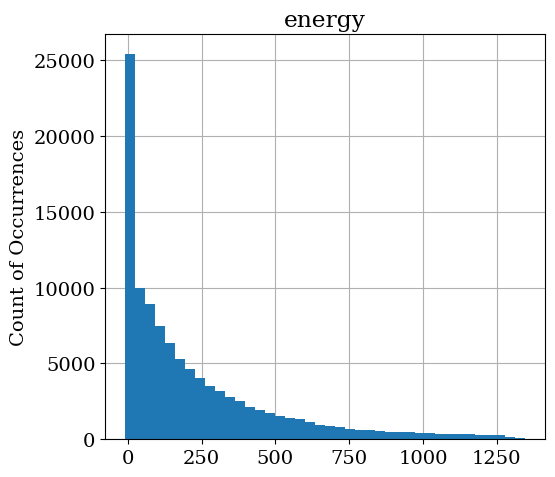

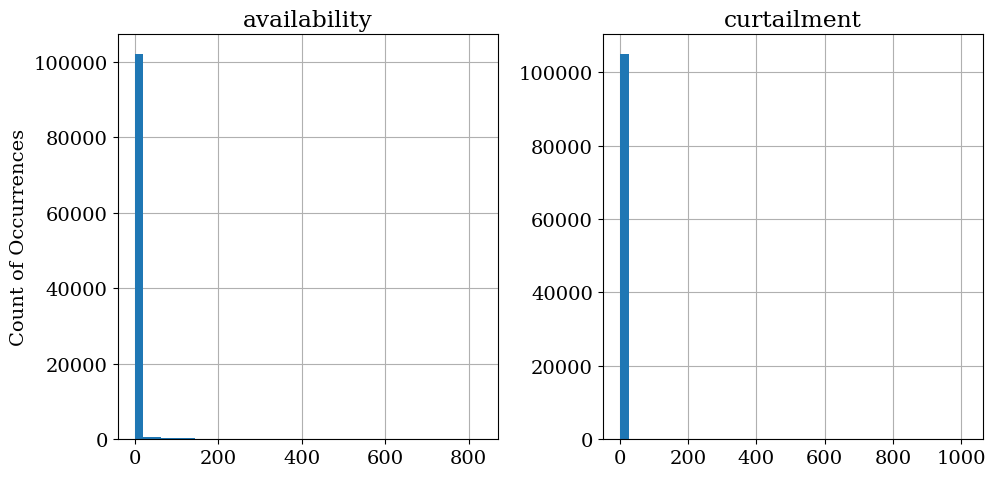

In [4]:
plot.column_histograms(project.meter, columns=["energy"])
plot.column_histograms(project.curtail, columns=["availability", "curtailment"])

## Step 3: Process the data into monthly averages and sums 

The raw plant data can be in different time resolutions (in this case 10-minute periods). The following steps process the data into monthly averages and combine them into a single 'monthly' data frame to be used in the OA assessment.

In [5]:
project.meter.head()

energy
time                        
2014-01-01 00:00:00  369.726
2014-01-01 00:10:00  376.409
2014-01-01 00:20:00  309.199
2014-01-01 00:30:00  350.176
2014-01-01 00:40:00  286.333

First, we'll create a MonteCarloAEP object which is used to calculate long-term AEP. Two renalaysis products are specified as arguments.

In [6]:
pa = MonteCarloAEP(project, reanalysis_products = ['era5', 'merra2'])

INFO:openoa.analysis.aep:Initializing MonteCarloAEP Analysis Object


Let's view the result. Note the extra fields we've calculated that we'll use later for filtering:
  - energy_nan_perc : the percentage of NaN values in the raw revenue meter data used in calculating the monthly sum. If this value is too large, we shouldn't include this month
  - nan_flag : if too much energy, availability, or curtailment data was missing for a given month, flag the result
  - num_days_expected : number of days in the month (useful for normalizing monthly gross energy later)
  - num_days_actual : actual number of days per month as found in the data (used when trimming monthly data frame)

In [7]:
# View the monthly data frame
pa.aggregate.head()

energy_gwh  energy_nan_perc  num_days_expected  num_days_actual  \
time                                                                          
2014-01-01    1.279667              0.0                 31               31   
2014-02-01    1.793873              0.0                 28               28   
2014-03-01    0.805549              0.0                 31               31   
2014-04-01    0.636472              0.0                 30               30   
2014-05-01    1.154255              0.0                 31               31   

            availability_gwh  curtailment_gwh  gross_energy_gwh  \
time                                                              
2014-01-01          0.008721         0.000000          1.288387   
2014-02-01          0.005280         0.000000          1.799153   
2014-03-01          0.000151         0.000000          0.805700   
2014-04-01          0.002773         0.000000          0.639245   
2014-05-01          0.015176         0.000225          1.169656   

            availability_pct  curtailment_pct  avail_nan_perc  curt_nan_perc  \
time                                                                           
2014-01-01          0.006769         0.000000             0.0            0.0   
2014-02-01          0.002934         0.000000             0.0            0.0   
2014-03-01          0.000188         0.000000             0.0            0.0   
2014-04-01          0.004338         0.000000             0.0            0.0   
2014-05-01          0.012974         0.000192             0.0            0.0   

            nan_flag  availability_typical  curtailment_typical  \
time                                                              
2014-01-01     False                  True                 True   
2014-02-01     False                  True                 True   
2014-03-01     False                  True                 True   
2014-04-01     False                  True                 True   
2014-05-01     False                  True                 True   

            combined_loss_valid      era5    merra2  
time                                                 
2014-01-01                 True  7.314878  7.227947  
2014-02-01                 True  8.347006  8.598686  
2014-03-01                 True  5.169673  5.207071  
2014-04-01                 True  4.756275  4.872304  
2014-05-01                 True  6.162751  6.351635

## Step 4: Review reanalysis data

Reanalysis data will be used to long-term correct the operational energy over the plant period of operation to the long-term. It is important that we only use reanalysis data that show reasonable trends over time with no noticeable discontinuities. A plot like below, in which normalized annual wind speeds are shown from 1997 to present, provides a good first look at data quality.

The plot shows that both of the reanalysis products track each other reasonably well and seem well-suited for the analysis.

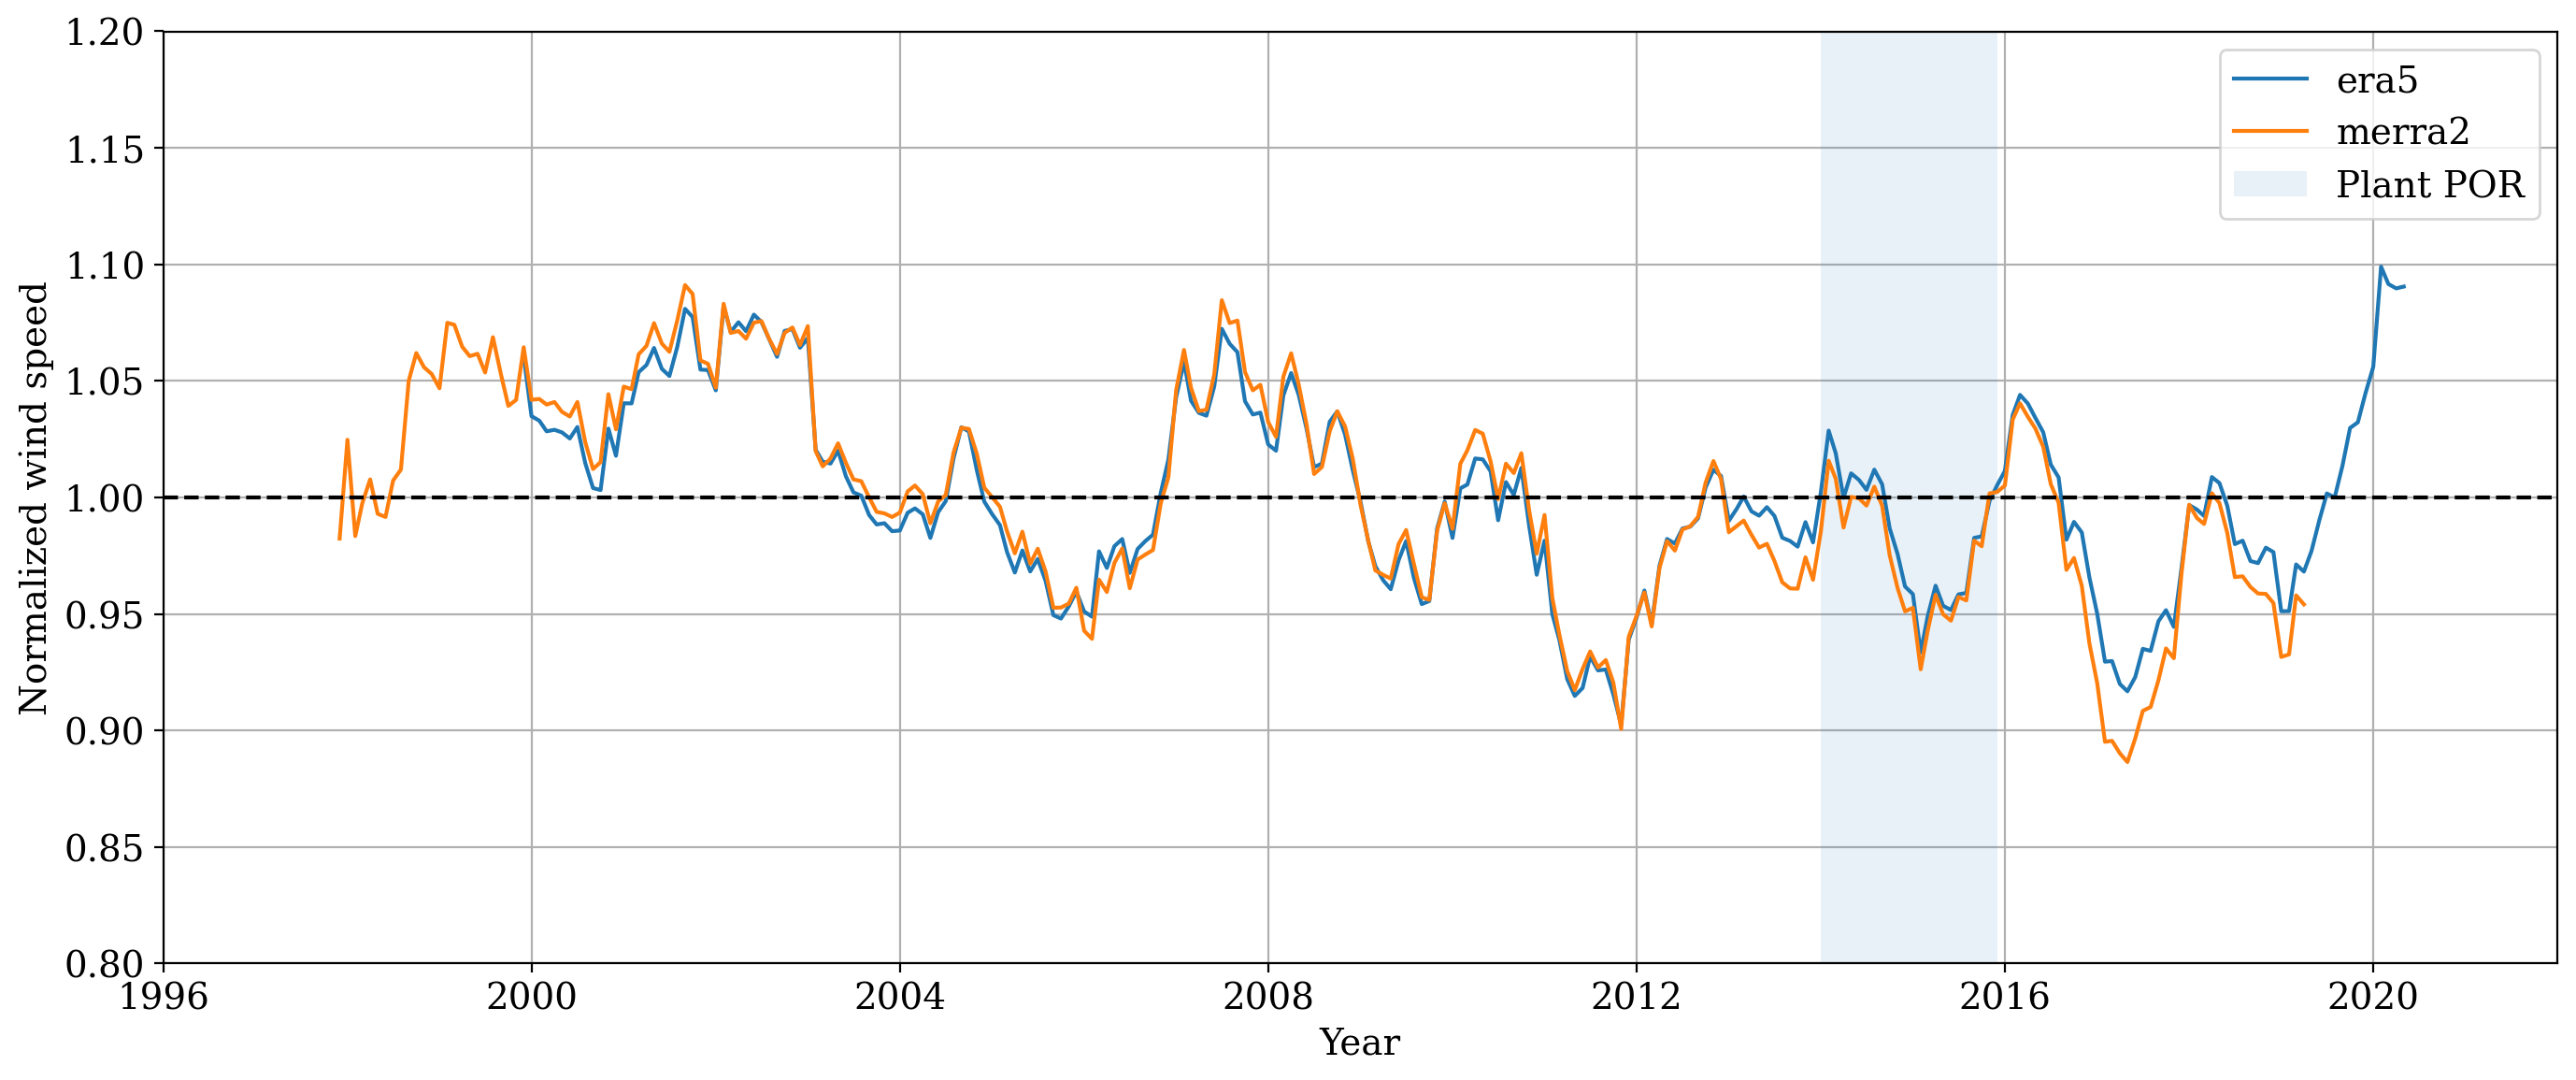

In [8]:
pa.plot_normalized_monthly_reanalysis_windspeed(
    return_fig=False,
    xlim=(datetime(1996, 1, 1), datetime(2021, 12, 31)),
    ylim=(0.8, 1.2),
)

## Step 5: Review energy and loss data

It is useful to take a look at the energy data and make sure the values make sense. We begin with scatter plots of gross energy and wind speed for each reanalysis product. We also show a time series of gross energy, as well as availability and curtailment loss. 

Let's start with the scatter plots of gross energy vs wind speed for each reanalysis product. Here we use the 'Robust Linear Model' (RLM) module of the Statsmodels package with the default Huber algorithm to produce a regression fit that excludes outliers. Data points in red show the outliers, and were excluded based on a Huber sensitivity factor of 3.0.

The plots below reveal that:
  - there are some outliers
  - Both renalysis products are strongly correlated with plant energy
  
If the user would like the RLM outlier detection algorithm to be used in the Monte Carlo analysis, the "outlier_detection" parameter should be set to "True" when calling the plant_analysis class. 

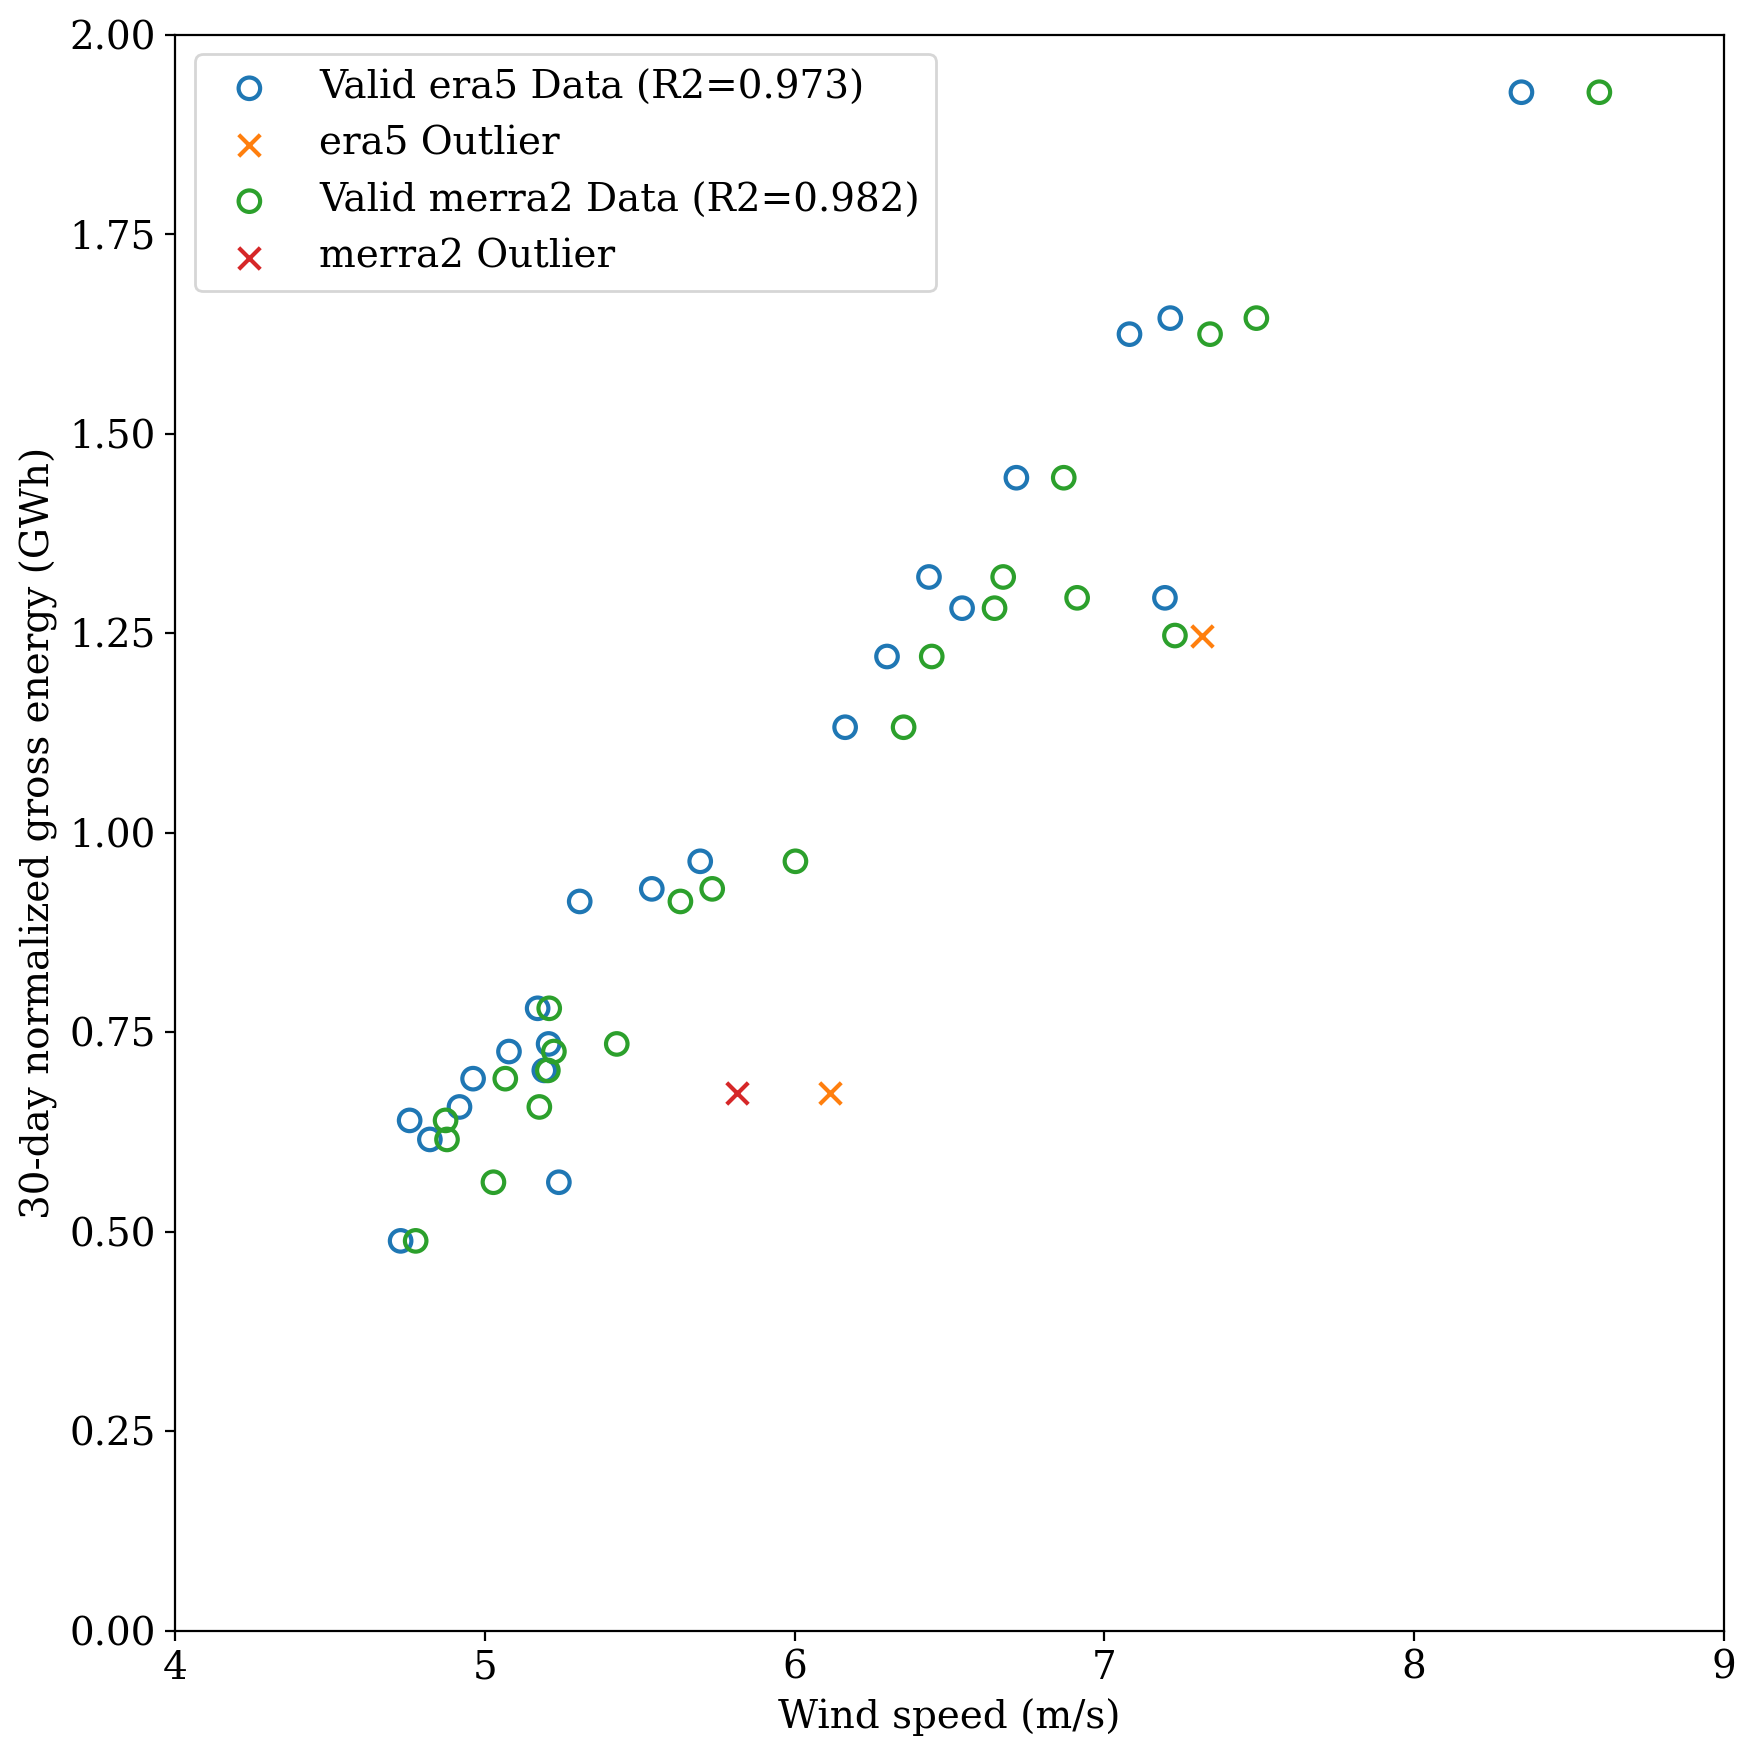

In [9]:
pa.plot_reanalysis_gross_energy_data(outlier_threshold=3, xlim=(4, 9), ylim=(0, 2), plot_kwargs=dict(s=60))

Next we show time series plots of the monthly gross energy, availabilty, and curtialment. Note that the availability and curtailment data were estimated based on SCADA data from the plant.

Long-term availability and curtailment losses for the plant are calculated based on average percentage losses for each calendar month. Summing those average values weighted by the fraction of long-term gross energy generated in each month yields the long-term annual estimates. Weighting by monthly long-term gross energy helps account for potential correlation between losses and energy production (e.g., high availability losses in summer months with lower energy production). The long-term losses are calculated in Step 9.

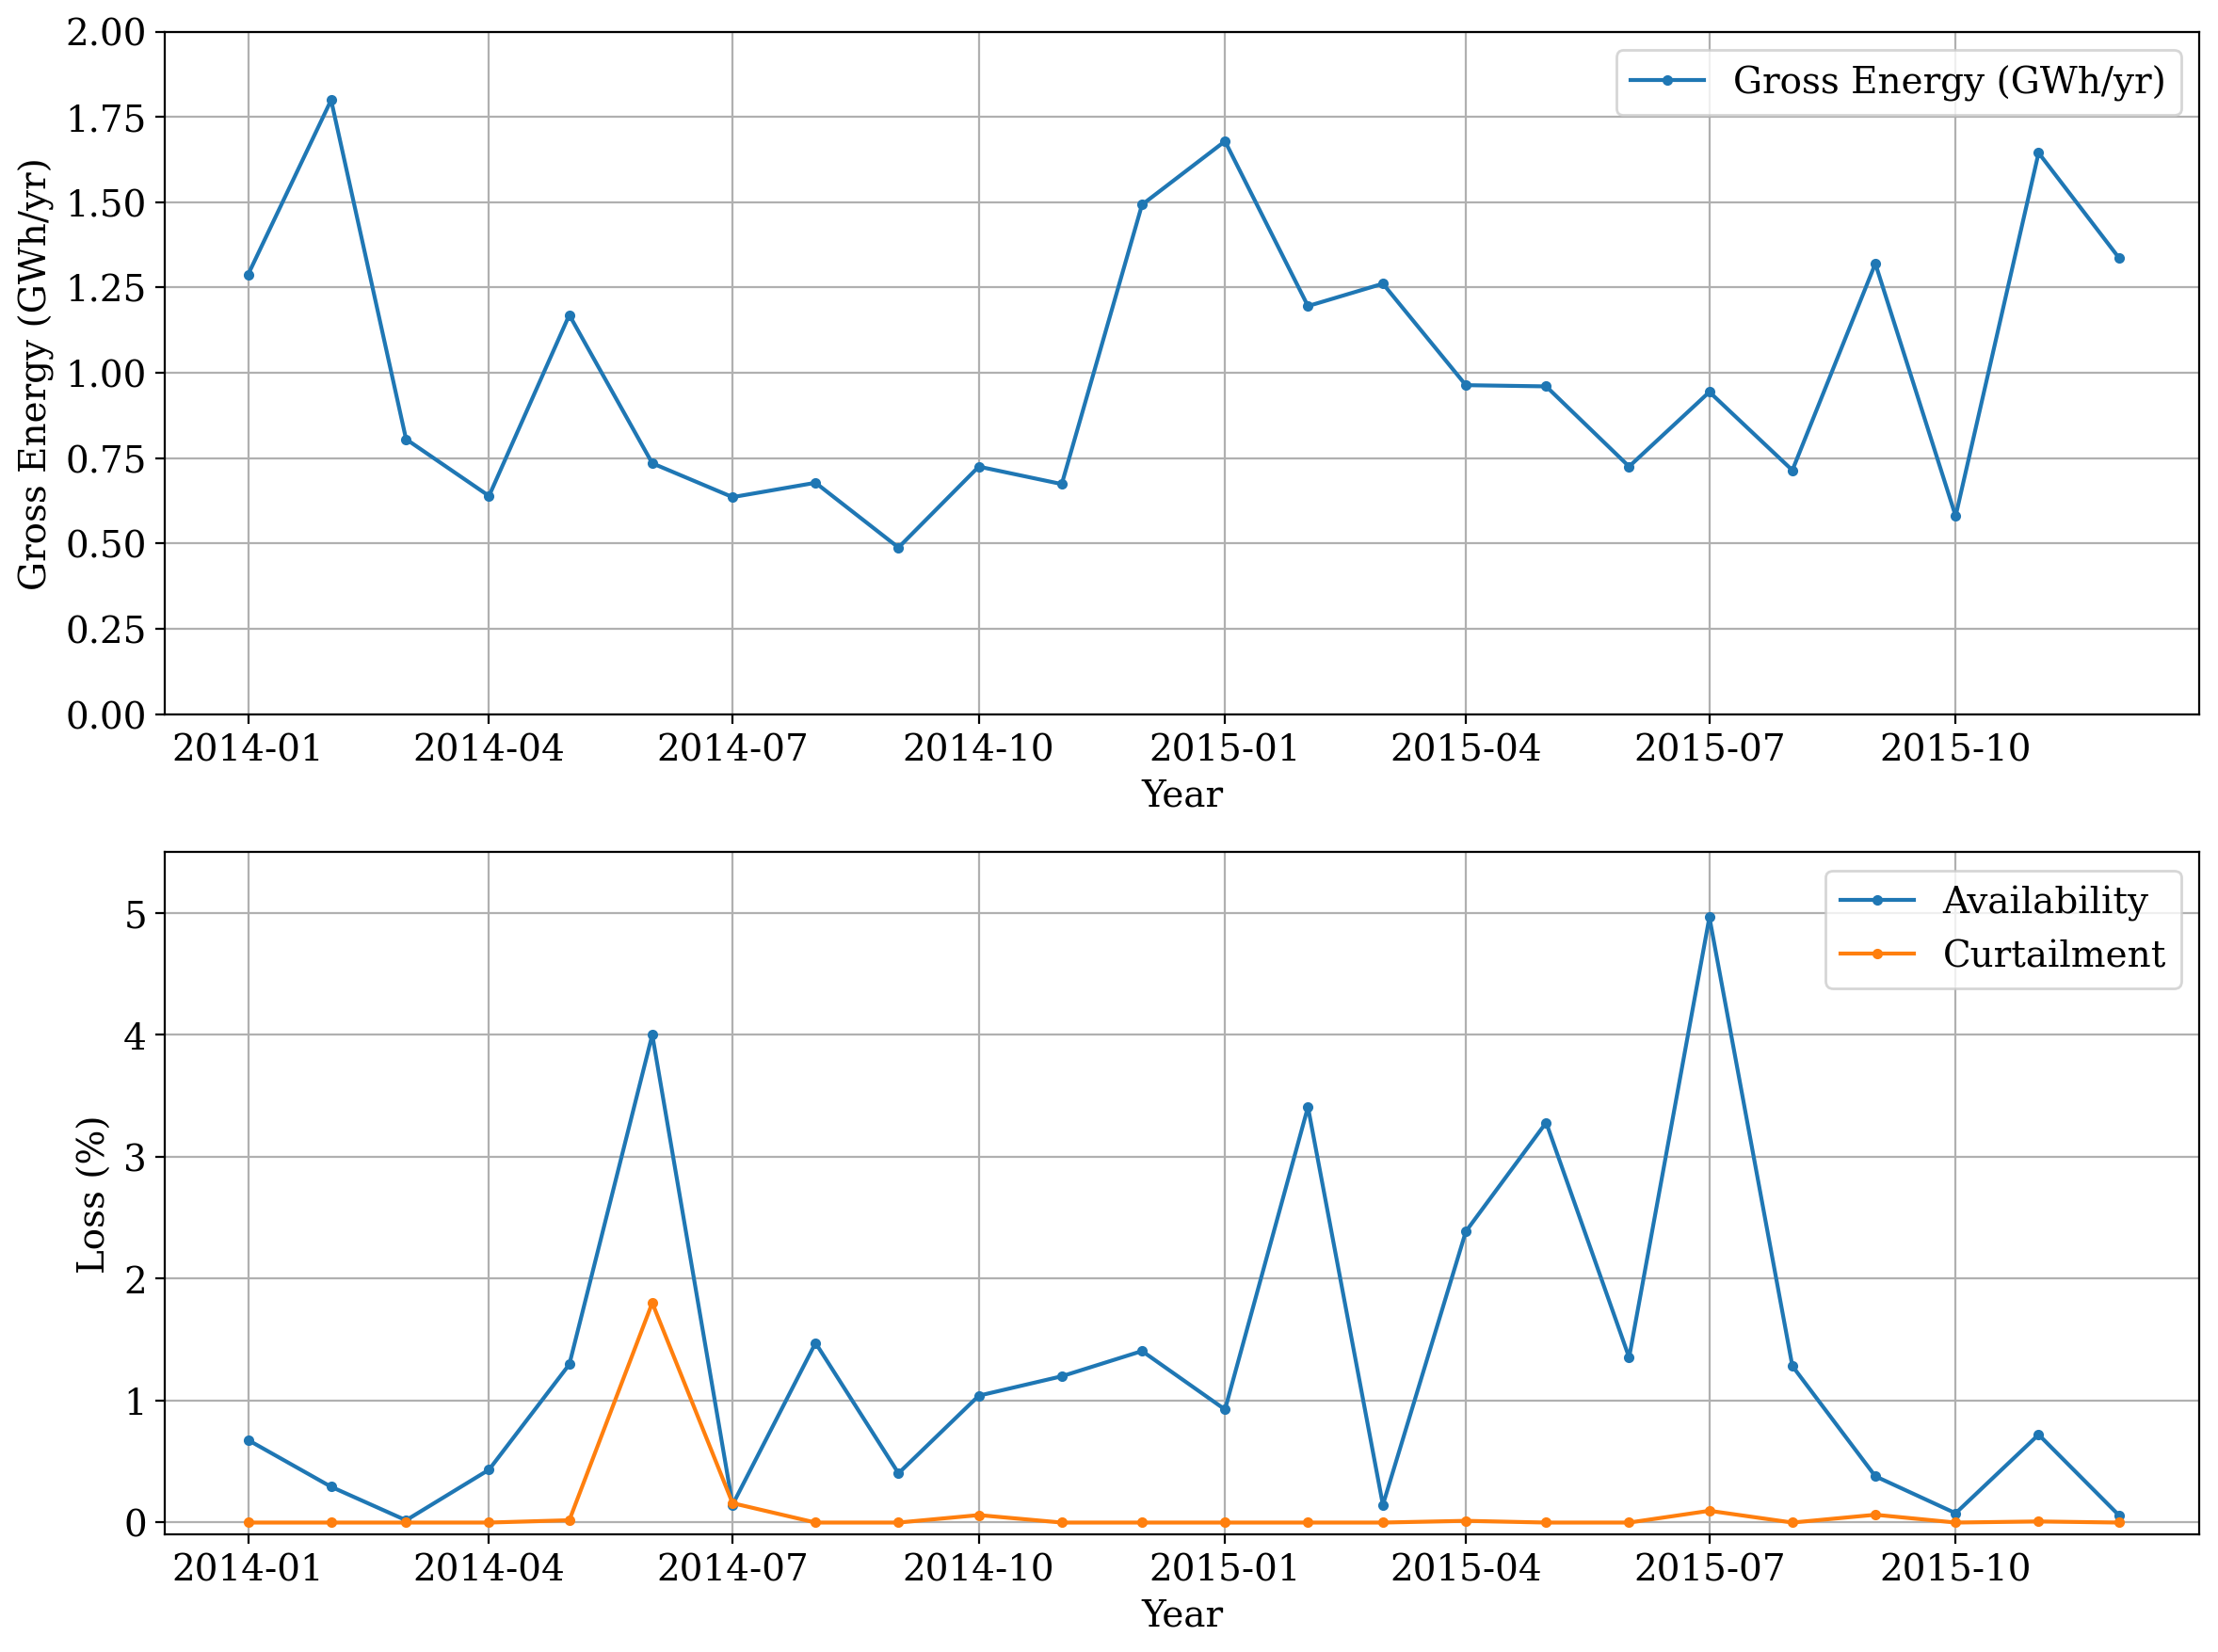

In [10]:
pa.plot_aggregate_plant_data_timeseries(
    xlim=(datetime(2013, 12, 1), datetime(2015, 12, 31)),
    ylim_energy=(0, 2),
    ylim_loss=(-0.1, 5.5)
)

## Step 6: Specify availabilty and curtailment data not represenative of actual plant performance

There may be anomalies in the reported availabilty that shouldn't be considered representative of actual plant performance. Force majeure events (e.g. lightning) are a good example. Such losses aren't typically considered in pre-construction AEP estimates; therefore, plant availablity loss reported in an operational AEP analysis should also not include such losses. 

The 'availability_typical' and 'curtailment_typical' fields in the monthly data frame are initially set to True. Below, individual months can be set to 'False' if it is deemed those months are unrepresentative of long-term plant losses. By flagging these months as false, they will be omitted when assessing average availabilty and curtailment loss for the plant.

Justification for removing months from assessing average availabilty or curtailment should come from conversations with the owner/operator. For example, if a high-loss month is found, reasons for the high loss should be discussed with the owner/operator to determine if those losses can be considered representative of average plant operation.

In [11]:
# For illustrative purposes, let's suppose a few months aren't representative of long-term losses
pa.aggregate.loc['2014-11-01',['availability_typical','curtailment_typical']] = False
pa.aggregate.loc['2015-07-01',['availability_typical','curtailment_typical']] = False

## Step 7: Select reanalysis products to use

Based on the assessment of reanalysis products above (both long-term trend and relationship with plant energy), we now set which reanalysis products we will include in the OA. For this particular case study, we use both products given the high regression relationships.

## Step 8: Set up Monte Carlo inputs

The next step is to set up the Monte Carlo framework for the analysis. Specifically, we identify each source of uncertainty in the OA estimate and use that uncertainty to create distributions of the input and intermediate variables from which we can sample for each iteration of the OA code. For input variables, we can create such distributions beforehand. For intermediate variables, we must sample separately for each iteration.

Detailed descriptions of the sampled Monte Carlo inputs, which can be specified when initializing the MonteCarloAEP object if values other than the defaults are desired, are provided below:

 - uncertainty_meter : Revenue meter energy measurements are associated with a measurement uncertainty of around 0.5%. This uncertainty is used to create a distribution centered at 1 (and with standard deviation therefore of 0.005). This column represents random samples from that distribution. For each iteration of the OA code, a value from this column is multiplied by the monthly revenue meter energy data before the data enter the OA code, thereby capturing the 0.5% uncertainty.
 
 - uncertainty_losses : Reported availability and curtailment losses are estimates and are associated with uncertainty. For now, we assume the reported values are associated with an uncertainty of 5%. Similar to above, we therefore create a distribution centered at 1 (with std of 0.05) from which we sample for each iteration of the OA code. These sampled values are then multiplied by the availability and curtaiment data independently before entering the OA code to capture the 5% uncertainty in the reported values.
 
 - uncertainty_windiness : This intends to capture the uncertainty associated with the number of historical years an analyst chooses to use in the windiness correction. The industry standard is typically 20 years and is based on the assumption that year-to-year wind speeds are uncorrelated. However, a growing body of research suggests that there is some correlation in year-to-year wind speeds and that there are trends in the resource on the decadal timescale. To capture this uncertainty both in the long-term trend of the resource and the analyst choice, we randomly sample integer values betweeen 10 and 20 as the number of years to use in the windiness correction.
 
 - uncertainty_loss_max : Due to uncertainty in reported availability and curtailment estimates, months with high combined losses are associated with high uncertainty in the calculated gross energy. It is common to remove such data from analysis. For this analysis, we randomly sample float values between 0.1 and 0.2 (i.e. 10% and 20%) to serve as criteria for the combined availability and curtailment losses. Specifically, months are excluded from analysis if their combined losses exceeds that criteria for the given OA iteration.

 - uncertainty_nan_energy: Threshold for removing days/months based on the fraction of NaNs in the data.

 - outlier_detection: Whether to perform (True) or not (False) outlier detection filtering. The default value is set to False.

 - uncertainty_outlier : Sample values between 1 and 3 which set the Huber algorithm outlier detection parameter (for linear regression; for machine learning regression algorithms, please see example 2b). Varying this threshold accounts for analyst subjectivity on what data points constitute outliers and which do not.
  
 - reanalyis_product : This captures the uncertainty of using different reanalysis products and, lacking a better method, is a proxy way of capturing uncertainty in the modelled monthly wind speeds. For each iteration of the OA code, one of the reanalysis products that we've already determined as valid (see the cells above) is selected.
 
Finally, we note that the operational data are also randomly resampled at each iteration using bootstrapping to help quantify uncertainty in the results. Consequently, different slope and intercept values for the linear regression model mapping monthly wind speed to energy production are determined each Monte Carlo iteration.

## Step 9: Run the OA code 

We're now ready to run the Monte Carlo based OA code. We repeat the OA process "num_sim" times using different sampling combinations of the input and intermediate variables to produce a distribution of AEP values.

A single line of code here in the notebook performs this step, but below is more detail on what is being done. 

Steps in OA process:

  - Set the wind speed and gross energy data to be used in the regression based on i) the reanalysis product to be used (Monte Carlo sampled); ii) randomly resampling which data points are included each Monte Carlo iteration, with replacement (e.g., bootstrapping); iii) the NaN energy data criteria (1%); iv) combined availability and curtailment loss criteria (Monte Carlo sampled); and v) the outlier criteria (Monte Carlo sampled)
  - Normalize gross energy to 30-day months
  - Perform linear regression and determine slope and intercept values, their standard errors, and the covariance between the two 
  - Apply the slope and intercept values to the long-term monthly average wind speeds (based on a 10-20 year historical period as determined by the Monte Carlo process) to calculate long-term monthly gross energy 
  - 'Denormalize' monthly long-term gross energy back to the normal number of days
  - Calculate AEP by subtracting out the long-term avaiability loss (curtailment loss is left in as part of AEP)
  - To account for uncertainty in the AEP for any single year, interannual variability is applied to the AEP estimates from each Monte Carlo iteration based on the standard deviation of the annual AEP values during the historical period 

In [12]:
# Run Monte Carlo based OA
pa.run(num_sim=2000, reanalysis_subset=['era5', 'merra2'])

INFO:openoa.analysis.aep:Running with parameters: {'uncertainty_meter': 0.005, 'uncertainty_losses': 0.05, 'uncertainty_loss_max': array([10., 20.]), 'uncertainty_windiness': array([10., 20.]), 'uncertainty_nan_energy': 0.01, 'num_sim': 2000, 'reanalysis_subset': ['era5', 'merra2']}
100%|██████████| 2000/2000 [00:17<00:00, 111.20it/s]
INFO:openoa.analysis.aep:Run completed


The key result is shown below: a distribution of AEP values from which uncertainty can be deduced. In this case, uncertainty is around 10%.

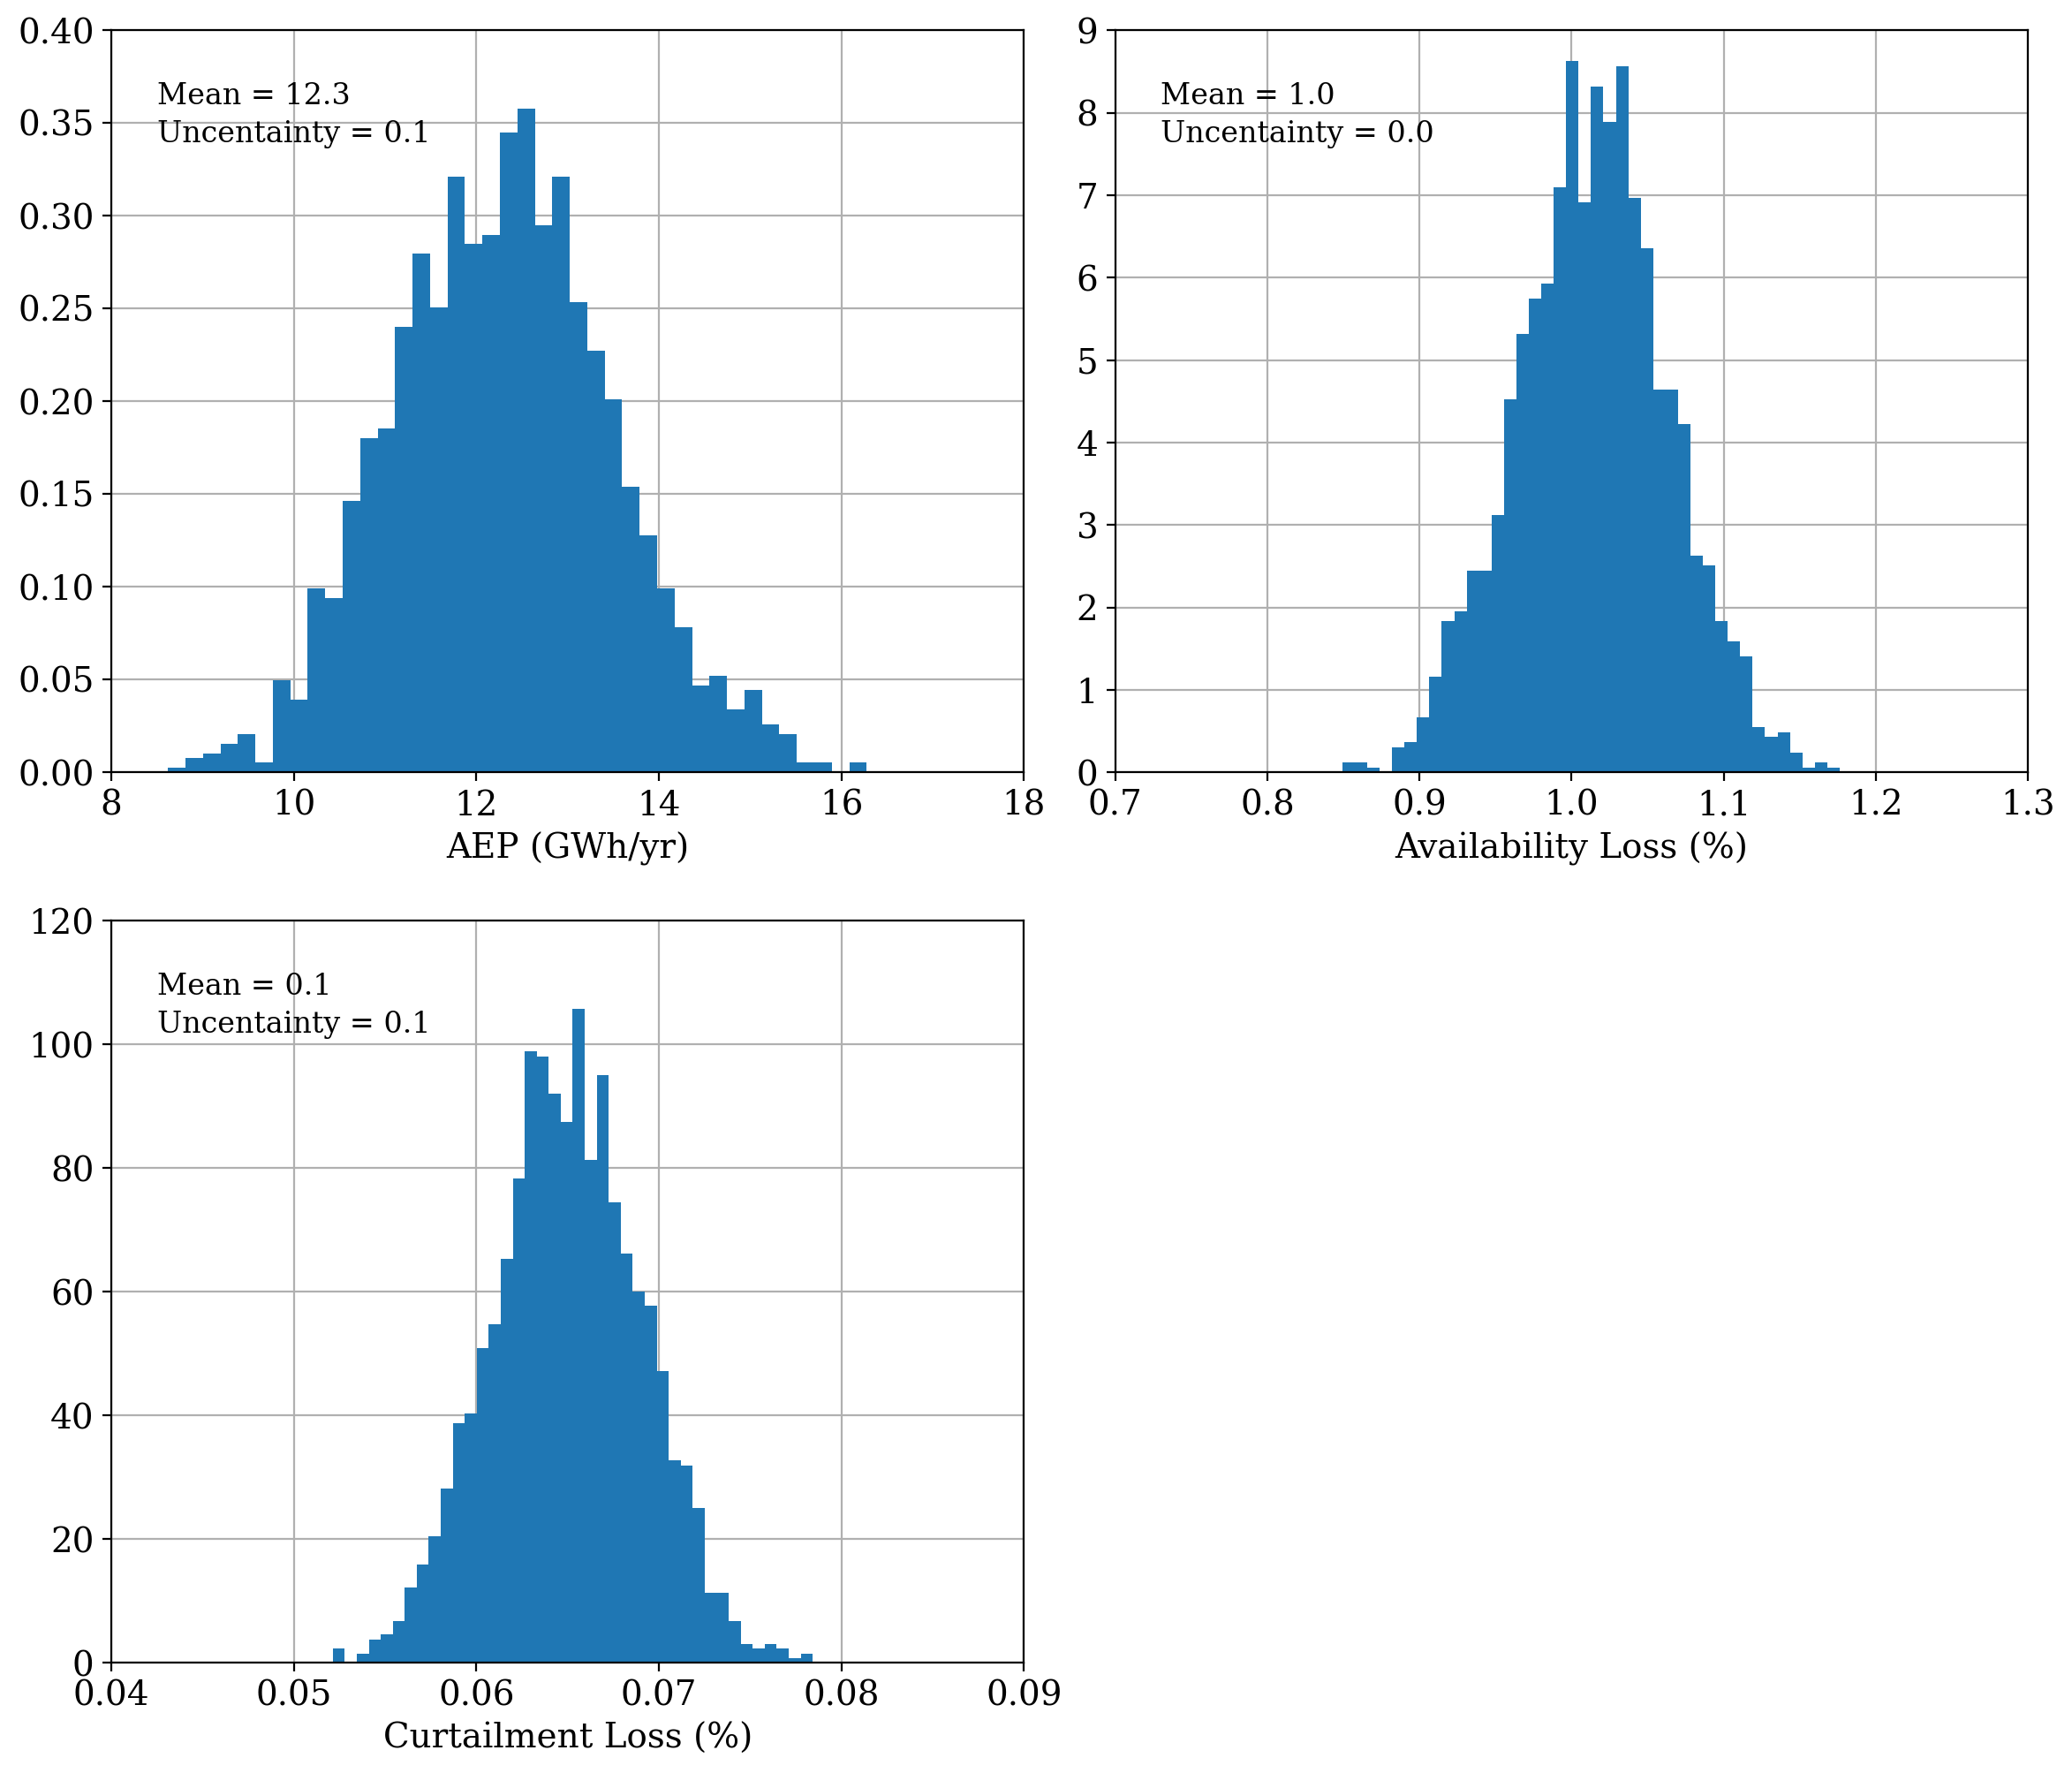

In [13]:
# Plot a distribution of AEP values from the Monte Carlo OA method
pa.plot_result_aep_distributions(
    xlim_aep=(8, 18),
    xlim_availability=(0.7, 1.3),
    xlim_curtail=(0.04, 0.09),
    ylim_aep=(0, 0.4),
    ylim_availability=(0, 9),
    ylim_curtail=(0, 120),
    annotate_kwargs={"fontsize": 12},
)

# # Alternative available in the plot module
# plot_results = pa.results.copy()
# plot_results[["avail_pct", "curt_pct"]] = plot_results[["avail_pct", "curt_pct"]] * 100
# plot.plot_distributions(
#     data=plot_results,
#     which=["aep_GWh", "avail_pct", "curt_pct"],
#     xlabels=["AEP (GWh/yr)", "Availability Loss (%)", "Curtailment Loss (%)"],
#     xlim_aep=(8, 18),
#     xlim_availability=(0.7, 1.3),
#     xlim_curtail=(0.04, 0.09),
#     ylim_aep=(0, 0.4),
#     ylim_availability=(0, 9),
#     ylim_curtail=(0, 120),
#     annotate_kwargs={"fontsize": 12},
# )

## Step 10: Post-analysis visualization

Here we show some supplementary results of the Monte Carlo OA approach to help illustrate how it works. 

First, it's worth looking at the Monte Carlo tracker data frame again, now that the slope, intercept, and number of outlier fields have been completed. Note that for transparency, debugging, and analysis purposes, we've also included in the tracker data frame the number of data points used in the regression.

In [14]:
# Produce histograms of the various MC-parameters
mc_reg = pd.DataFrame(data={
    'slope': pa._mc_slope.ravel(),
    'intercept': pa._mc_intercept, 
    'num_points': pa._mc_num_points, 
    'metered_energy_fraction': pa.mc_inputs.metered_energy_fraction, 
    'loss_fraction': pa.mc_inputs.loss_fraction,
    'num_years_windiness': pa.mc_inputs.num_years_windiness, 
    'loss_threshold': pa.mc_inputs.loss_threshold,
    'reanalysis_product': pa.mc_inputs.reanalysis_product
})

It's useful to plot distributions of each variable to show what is happening in the Monte Carlo OA method. Based on the plot below, we observe the following:

  - metered_energy_fraction, and loss_fraction sampling follow a normal distribution as expected
  - The slope and intercept distributions appear normally distributed, even though different reanalysis products are considered, resulting in different regression relationships. This is likely because the reanalysis products agree with each other closely.
  - 24 data points were used for all iterations, indicating that there was no variation in the number of outlier months removed
  - We see approximately equal sampling of the num_years_windiness, loss_threshold, and reanalysis_product, as expected

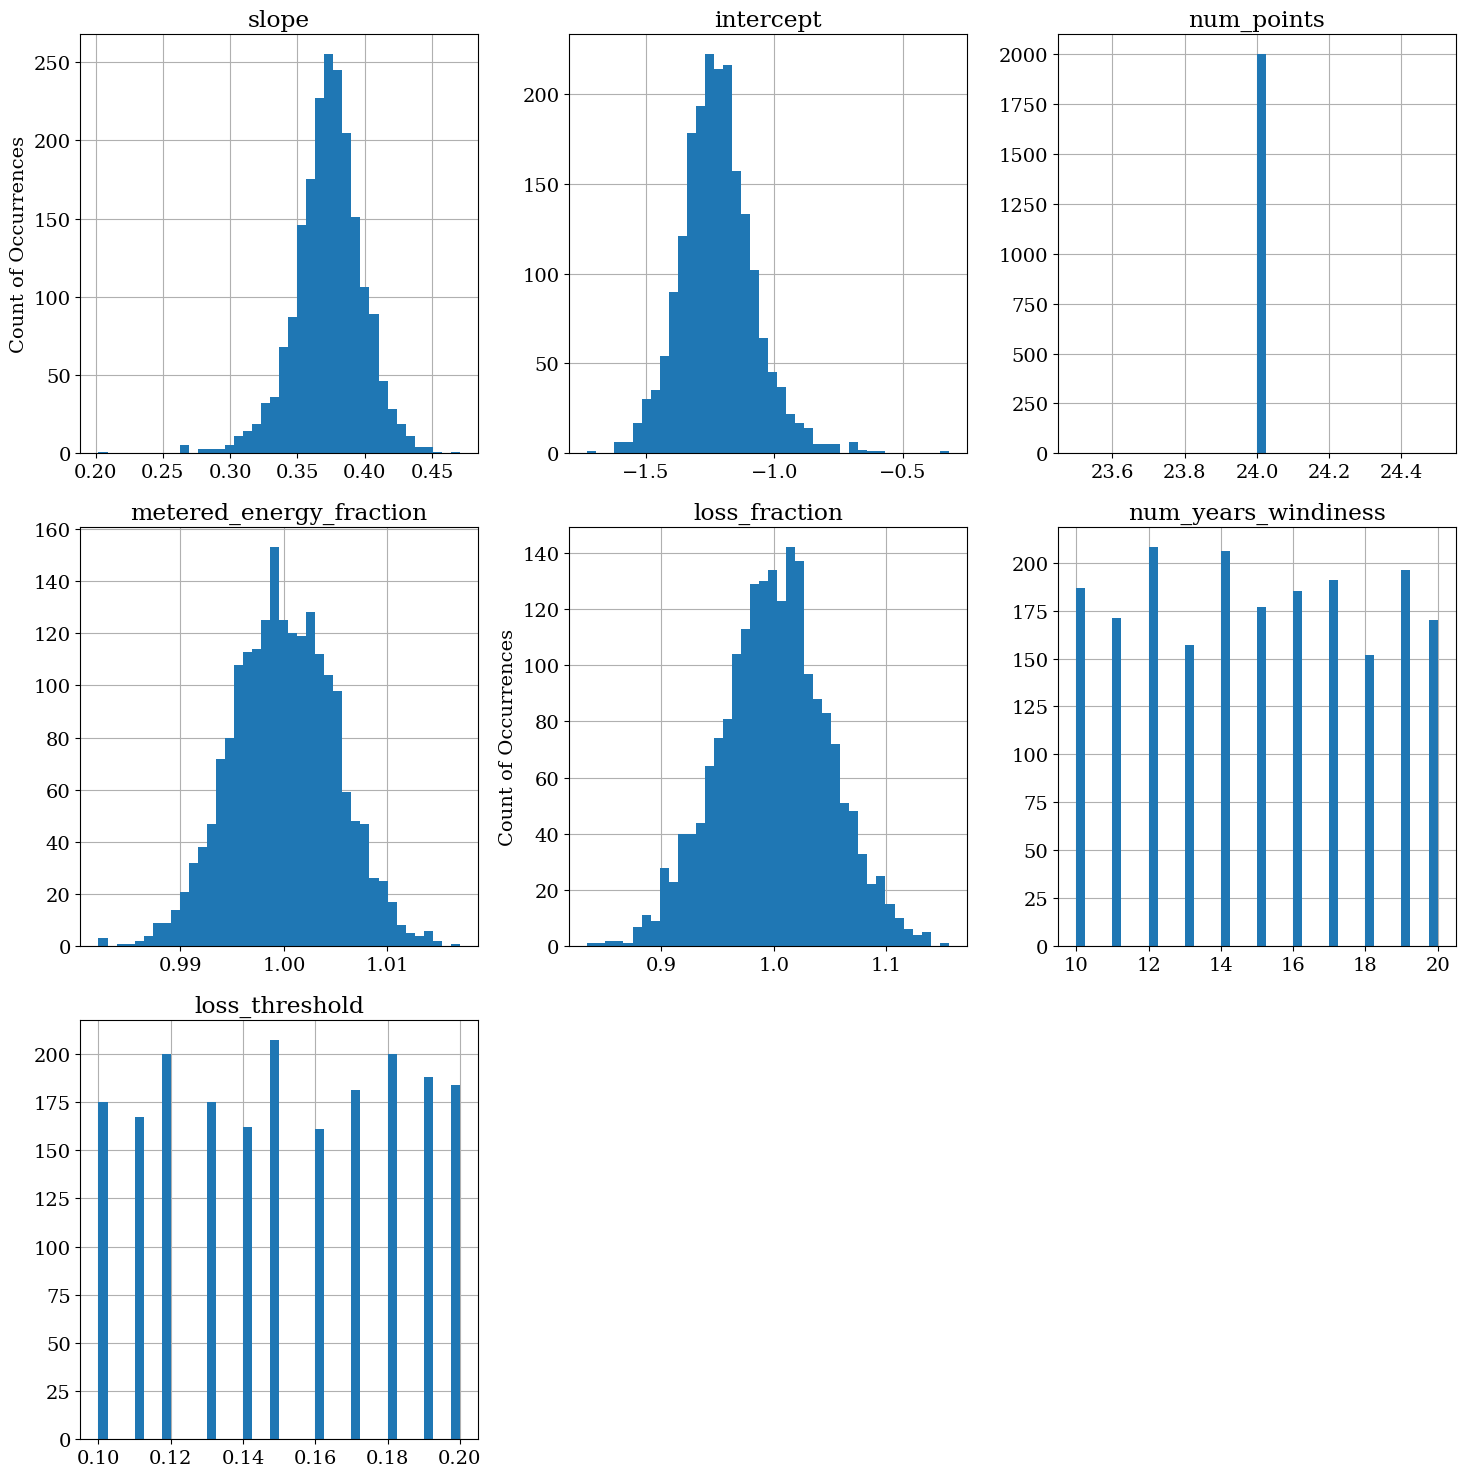

In [15]:
plot.column_histograms(mc_reg)

It's worth highlighting the inverse relationship between slope and intercept values under the Monte Carlo approach. Slope and intercept values are strongly negatively correlated (e.g. slope goes up, intercept goes down), as shown below.

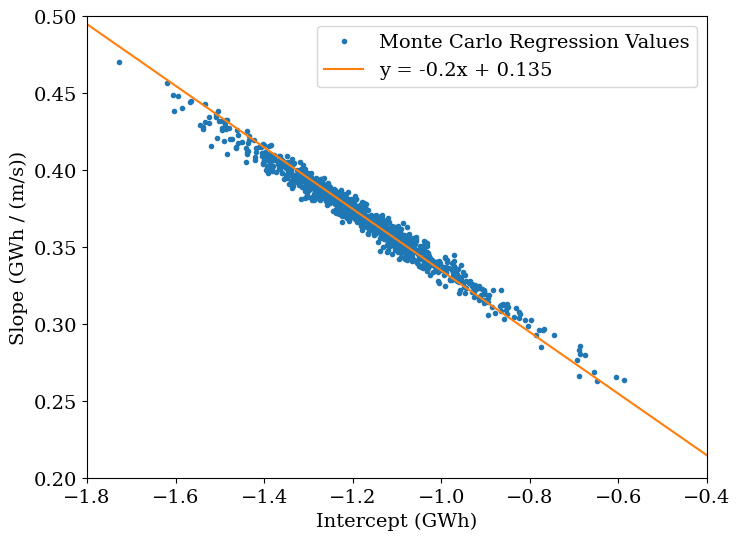

In [16]:
# Produce scatter plots of slope and intercept values. Here we focus on the ERA-5 data
plt.figure(figsize=(8,6))
plt.plot(
    mc_reg.intercept[mc_reg.reanalysis_product =='era5'],
    mc_reg.slope[mc_reg.reanalysis_product =='era5'],
    '.', label="Monte Carlo Regression Values"
)
x = np.linspace(-2, 0, 3)
y = -0.2 * x + 0.135
plt.plot(x, y, label="y = -0.2x + 0.135")
plt.xlabel('Intercept (GWh)')
plt.ylabel('Slope (GWh / (m/s))')
plt.legend()
plt.xlim((-1.8, -0.4))
plt.ylim(0.2, 0.5)
plt.grid()
plt.show()

We can look further at the influence of certain Monte Carlo parameters on the AEP result. For example, let's see what effect the choice of reanalysis product has on the result:

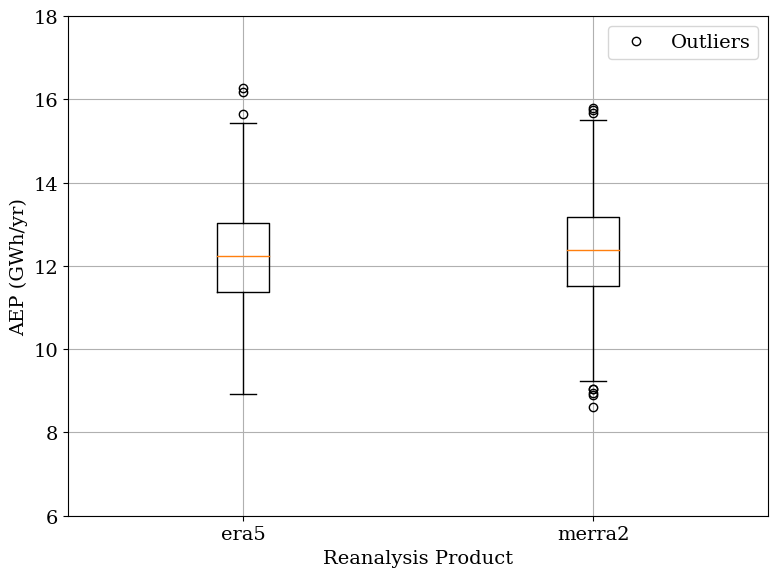

In [17]:
pa.plot_aep_boxplot(x=mc_reg['reanalysis_product'], xlabel="Reanalysis Product", ylim=(6, 18))

In this case, the two reanalysis products lead to similar AEP estimates, although MERRA2 yields slightly higher uncertainty.

We can also look at the effect on the number of years used in the windiness correction, in the below code block and figure, where we can se that the number of years used in the windiness correction does not significantly impact the AEP estimate.

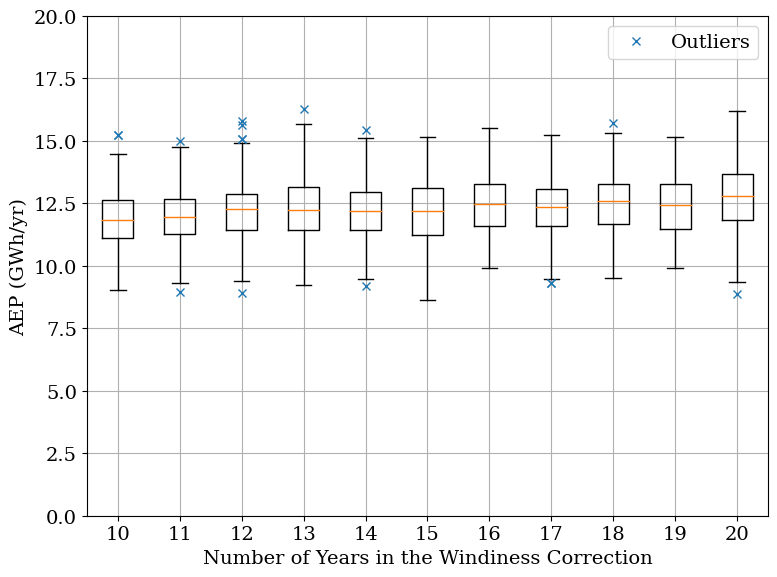

In [18]:
# Boxplot of AEP based on number of years in windiness correction
# NOTE: This is the same method, but calling the same method through the plot module directly
plot.plot_boxplot(
    y=pa.results.aep_GWh,
    x=mc_reg['num_years_windiness'],
    xlabel="Number of Years in the Windiness Correction",
    ylabel="AEP (GWh/yr)",
    ylim=(0, 20),
    plot_kwargs_box={"flierprops":dict(marker="x", markeredgecolor="tab:blue")}
)

In some cases, it may be useful to show more of the background information for a plot, so we can return the figure and add another routine on top

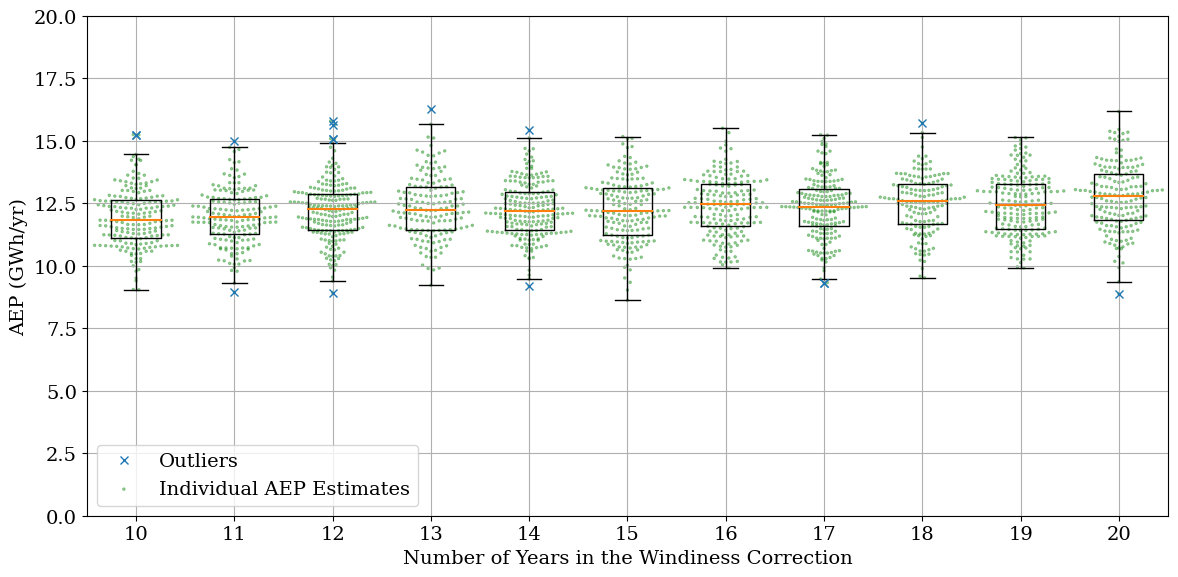

In [19]:
fig, ax, boxes = pa.plot_aep_boxplot(
    x=mc_reg['num_years_windiness'],
    xlabel="Number of Years in the Windiness Correction",
    ylim=(0, 20),
    figure_kwargs=dict(figsize=(12, 6)),
    plot_kwargs_box={
        "flierprops": dict(marker="x", markeredgecolor="tab:blue"),
        "medianprops": dict(linewidth=1.5)
    },
    return_fig=True,
    with_points=True,
    points_label="Individual AEP Estimates",
    plot_kwargs_points=dict(alpha=0.5, s=2),
    legend_kwargs=dict(loc="lower left"),
)

# Gap Analysis Step 2: Calculate the Turbine Ideal Energy based on the SCADA and Reanalysis Data

In [1]:
%load_ext autoreload
%autoreload 2

This notebook provides an overview and walk-through of the turbine ideal energy (TIE) method in OpenOA. The TIE metric is defined as the amount of electricity generated by all turbines at a wind farm operating under normal conditions (i.e., not subject to downtime or significant underperformance, but subject to wake losses and moderate turbine performance losses). The approach to calculate TIE is to:

1. Filter out underperforming data from the power curve for each turbine,
2. Develop a statistical relationship between the remaining power data and key atmospheric variables from a long-term    reanalysis product
3. Long-term correct the period of record power data using the above statistical relationship
4. Sum up the long-term corrected power data across all turbines to get TIE for the wind farm

Here we use different reanalysis products to capture the uncertainty around the modeled wind resource. We also consider uncertainty due to power data accuracy and the power curve filtering choices for identifying normal turbine performance made by the analyst.

In this example, the process for estimating TIE is illustrated both with and without uncertainty quantification.

In [2]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from openoa.analysis import TurbineLongTermGrossEnergy
from openoa.utils import plot

import project_ENGIE

In the call below, make sure the appropriate path to the CSV input files is specfied. In this example, the CSV files are located directly in the 'examples/data/la_haute_borne' folder

In [3]:
# Load plant object and validate for the turbine long term energy analysis type
project = project_ENGIE.prepare('./data/la_haute_borne')
project.analysis_type.append("TurbineLongTermGrossEnergy")
project.validate()

INFO:root:Loading SCADA data
INFO:root:SCADA data loaded
INFO:root:Timestamp conversion to datetime and UTC
INFO:root:Removing out of range of temperature readings
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:root:Flagging unresponsive sensors
INFO:root:Converting pitch to the range [-180, 180]
INFO:root:Calculating energy production
INFO:root:Reading in the meter data
INFO:root:Reading in the curtailment data
INFO:root:Reading in the reanalysis data and calculating the extra fields
INFO:root:Reading in the asset data
/opt/miniconda3/envs/openoa/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:112: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  values = construct_1d_object_array_from_listlike(values)


In [4]:
# Let's take a look at the columns in the SCADA data frame
project.scada.head()

Date_time  pitch      power  \
time                id                                                    
2014-01-01 00:00:00 R80736  2014-01-01T01:00:00+01:00  -1.00  642.78003   
                    R80721  2014-01-01T01:00:00+01:00  -1.01  441.06000   
                    R80790  2014-01-01T01:00:00+01:00  -0.96  658.53003   
                    R80711  2014-01-01T01:00:00+01:00  -0.93  514.23999   
2014-01-01 00:10:00 R80790  2014-01-01T01:10:00+01:00  -0.96  640.23999   

                            windspeed  Va_avg  temperature     Ya_avg  \
time                id                                                  
2014-01-01 00:00:00 R80736       7.12    0.66         4.69  181.34000   
                    R80721       6.39   -2.48         4.94  179.82001   
                    R80790       7.11    1.07         4.55  172.39000   
                    R80711       6.87    6.95         4.30  172.77000   
2014-01-01 00:10:00 R80790       7.01   -1.90         4.68  172.39000   

                            wind_direction  energy_kwh      energy  
time                id                                              
2014-01-01 00:00:00 R80736       182.00999  107.130005  107.130005  
                    R80721       177.36000   73.510000   73.510000  
                    R80790       173.50999  109.755005  109.755005  
                    R80711       179.72000   85.706665   85.706665  
2014-01-01 00:10:00 R80790       170.46001  106.706665  106.706665

## TIE calculation without uncertainty quantification

Next we create a TIE object which will contain the analysis to be performed. The method has the ability to calculate uncertainty in the TIE metric through a Monte Carlo sampling of filtering thresholds, power data, and reanalysis product choices. For now, we turn this option off and run the method a single time.

**NOTE**: The inputs `wind_bin_threshold`, `max_power_filter`, and `correction_threshold` all default to UQ inputs, and so inputs must be provided to these parameters when running a single case (`UQ` = `False`).

In [5]:
ta = TurbineLongTermGrossEnergy(
    project,
    UQ=False,
    wind_bin_threshold=2.0,  # Exclude data outside 2 standard deviations of the median for each power bin
    max_power_filter=0.9,  # Don't apply bin filter above 0.9 of turbine capacity
    correction_threshold=0.9  # Set the correction threshold to 90%
)

INFO:openoa.analysis.turbine_long_term_gross_energy:Initializing TurbineLongTermGrossEnergy Object
INFO:openoa.analysis.turbine_long_term_gross_energy:Note: uncertainty quantification will NOT be performed in the calculation
INFO:openoa.analysis.turbine_long_term_gross_energy:Processing SCADA data into dictionaries by turbine (this can take a while)


All of the steps in the TI calculation process are pulled under a single run() function. These steps include:

1. Processing reanalysis data to daily averages.
2. Filtering the SCADA data
3. Fitting the daily reanalysis data to daily SCADA data using a Generalized Additive Model (GAM)
4. Apply GAM results to calculate long-term TIE for the wind farm

By setting UQ = False (the default argument value), we must manually specify key filtering thresholds that would otherwise be sampled from a range of values through Monte Carlo. Specifically, we must set thresholds applied to the bin_filter() function in the toolkits.filtering class of OpenOA. 

We also must decide how to deal with missing data when computing daily sums of energy production from each turbine. Here we set the threshold at 0.9 (i.e., if greater than 90% of SCADA data are available for a given day, scale up the daily energy by the fraction of data missing. If less than 90% data recovery, exclude that day from analysis.

Now we'll call the run() method to calculate TIE, choosing two reanalysis products to be used in the TIE calculation process.

In [6]:
# We can choose to save key plots to a file by setting enable_plotting = True and 
# specifying a directory to save the images. For now we turn off this feature. 
# ta.run(reanalysis_subset = ['era5', 'merra2'], enable_plotting = False, plot_dir = None,
#        wind_bin_thresh = wind_bin_thresh, max_power_filter = max_power_filter,
#        correction_threshold = correction_threshold)
ta.run(reanalysis_subset = ['era5', 'merra2'])

INFO:openoa.analysis.turbine_long_term_gross_energy:Running the long term gross energy analysis
100%|██████████| 2/2 [00:35<00:00, 17.90s/it]
INFO:openoa.analysis.turbine_long_term_gross_energy:Run completed


Now that we've finished the TIE calculation, let's examine results

In [7]:
ta.plant_gross

array([[13529636.54195191],
       [13636640.40465521]])

In [8]:
# What is the long-term annual TIE for whole plant
print(f"Long-term turbine ideal energy is {np.mean(ta.plant_gross/1e6):0,.1f} GWh/year")

Long-term turbine ideal energy is 13.6 GWh/year


The long-term TIE value of 13.6 GWh/year is based on the mean TIE resulting from the two reanalysis products considered.

Next, we can examine how well the filtering worked by examining the power curves for each turbine using the plot_filtered_power_curves() function.

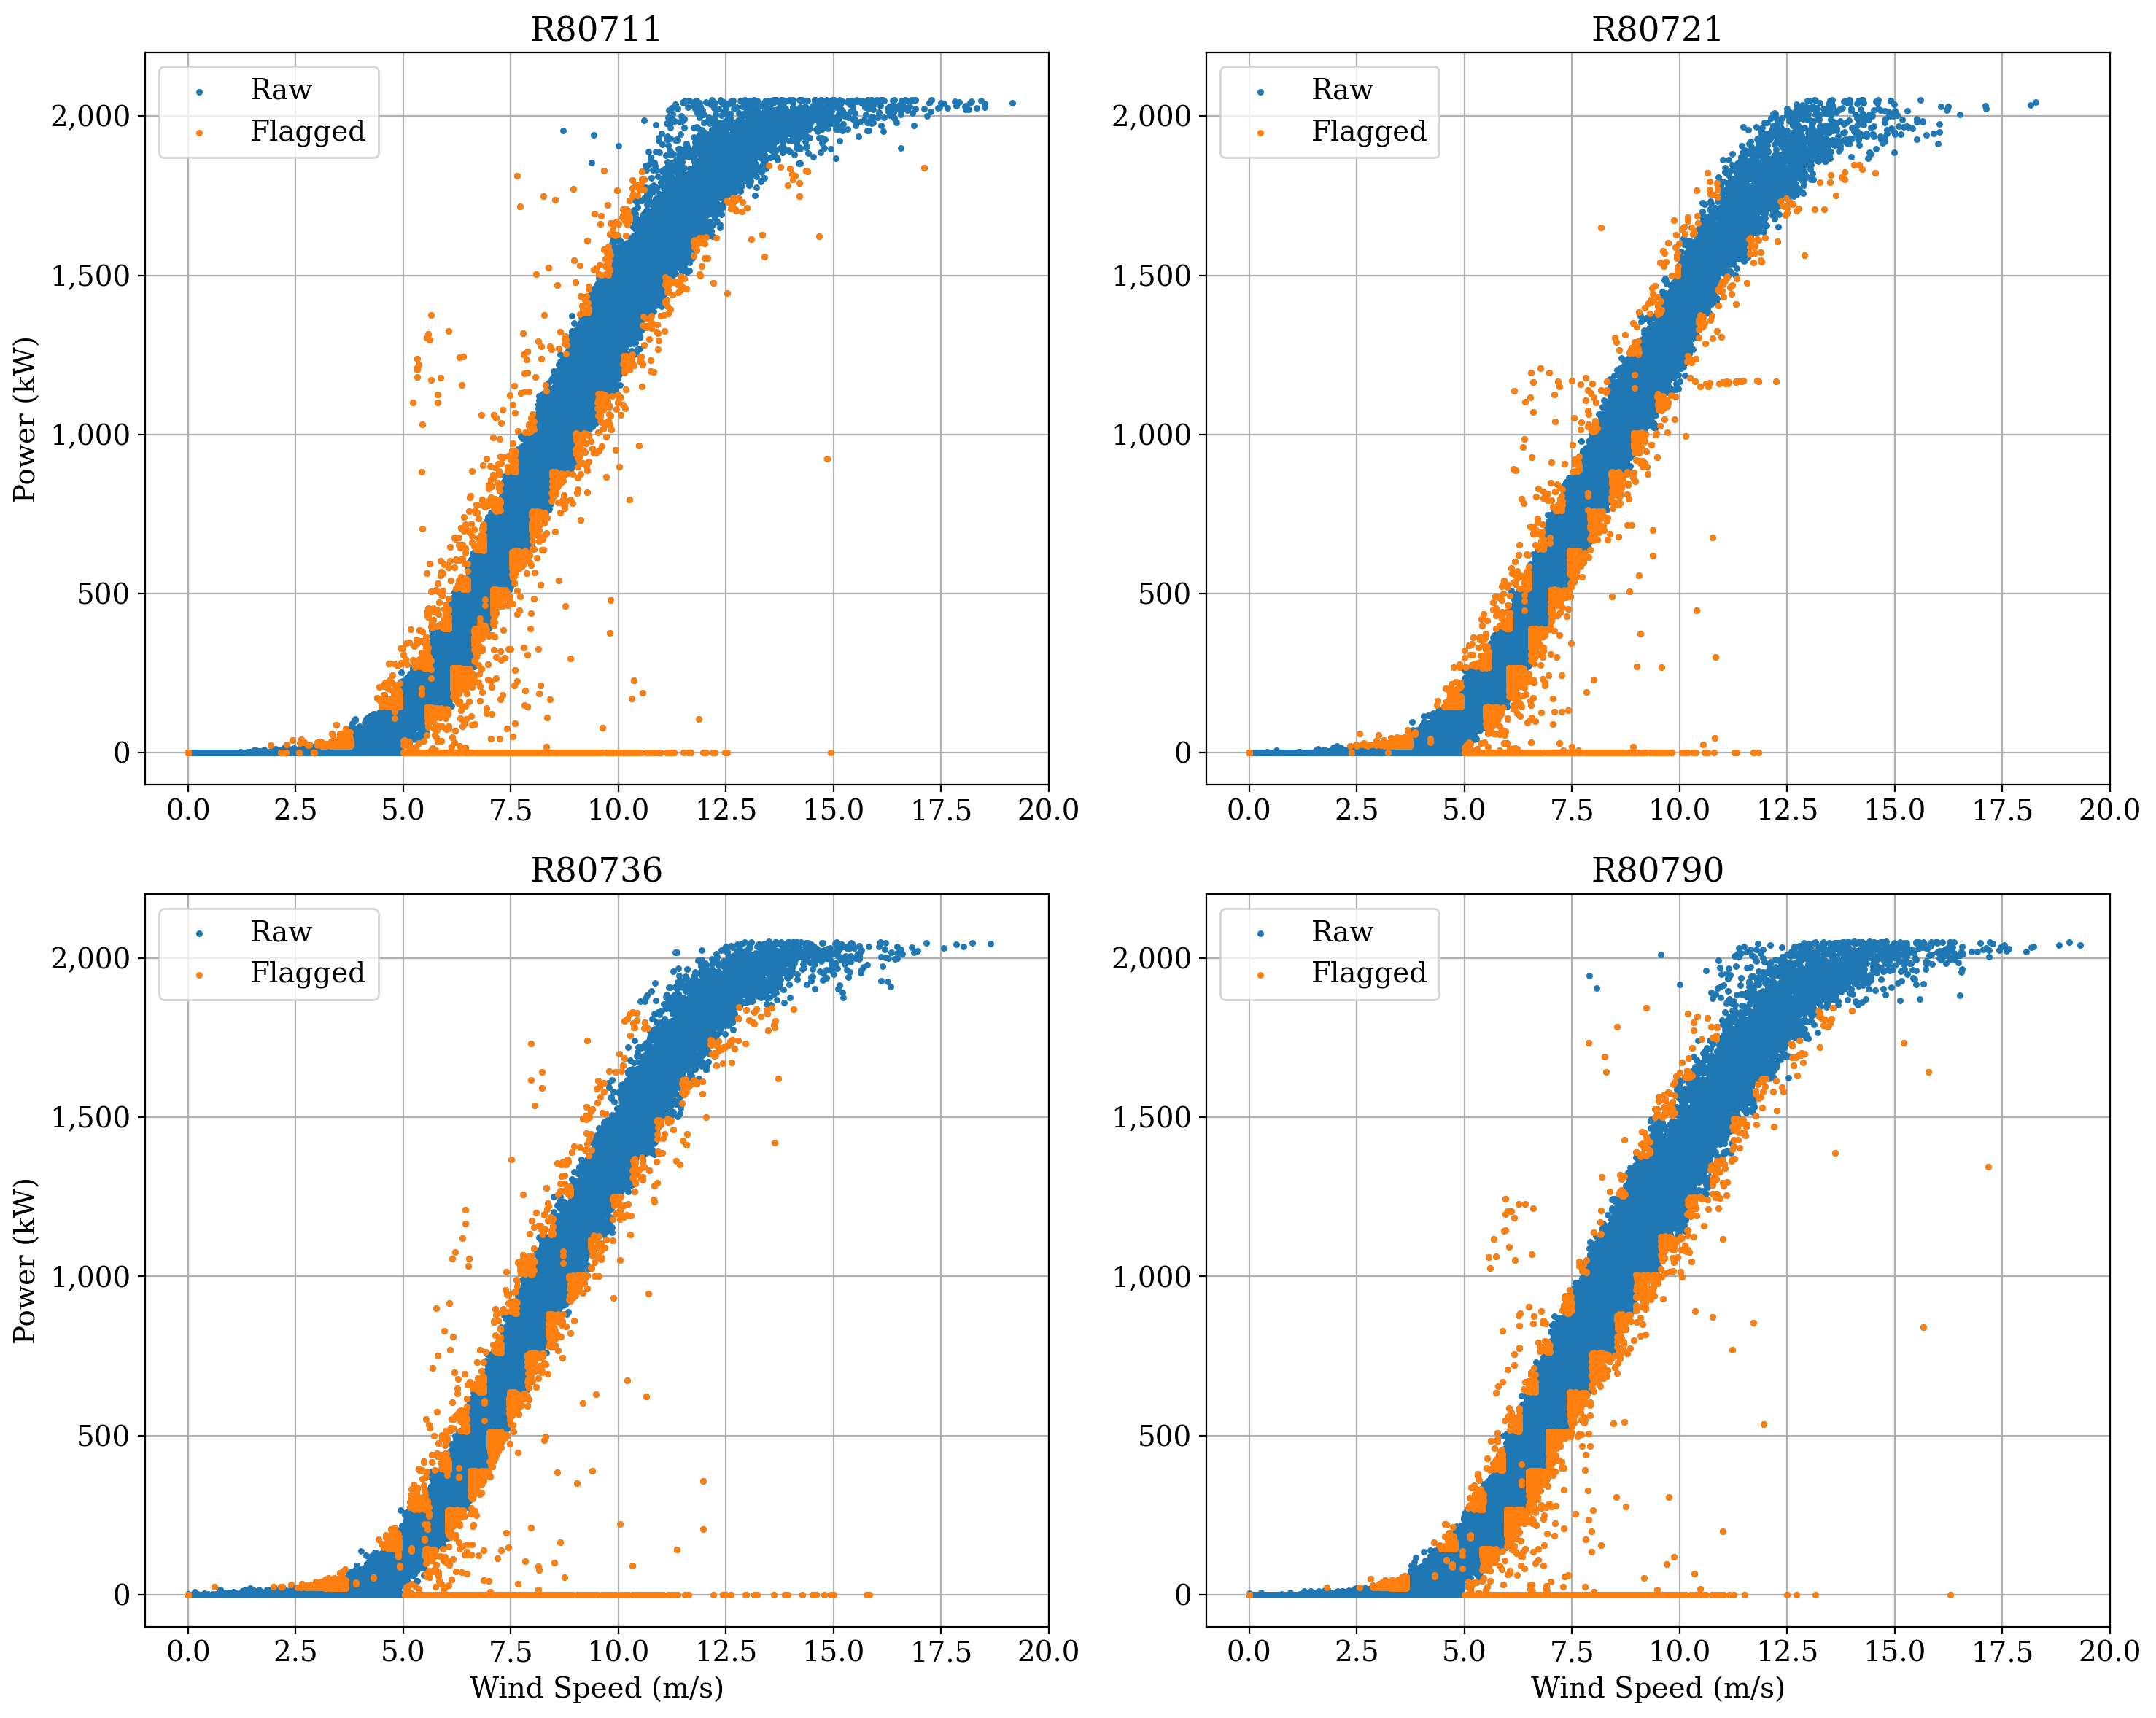

In [9]:
ta.plot_filtered_power_curves(
    flag_labels=("Flagged", "Raw"),
    legend=True,
    max_cols=2,
    xlim=(-1, 20),
    ylim=(-100, 2200),
    figure_kwargs=dict(figsize=(15, 12)),
    plot_kwargs=dict(s=5),
)

# # Alternatively, using the plotting library
# plot.plot_power_curves(
#     data=ta.scada_dict,
#     windspeed_col="windspeed",
#     power_col="power",
#     flag_col="flag_final",
#     flag_labels=("Flagged", "Raw"),
#     legend=True,
#     max_cols=2,
#     xlim=(-1, 20),
#     ylim=(-100, 2200),
#     figure_kwargs=dict(figsize=(15, 12)),
#     plot_kwargs=dict(s=5),
# )

Overall these are very clean power curves, and the filtering algorithms seem to have done a good job of catching the most egregious outliers.

Now let's look at the daily data and how well the power curve fit worked

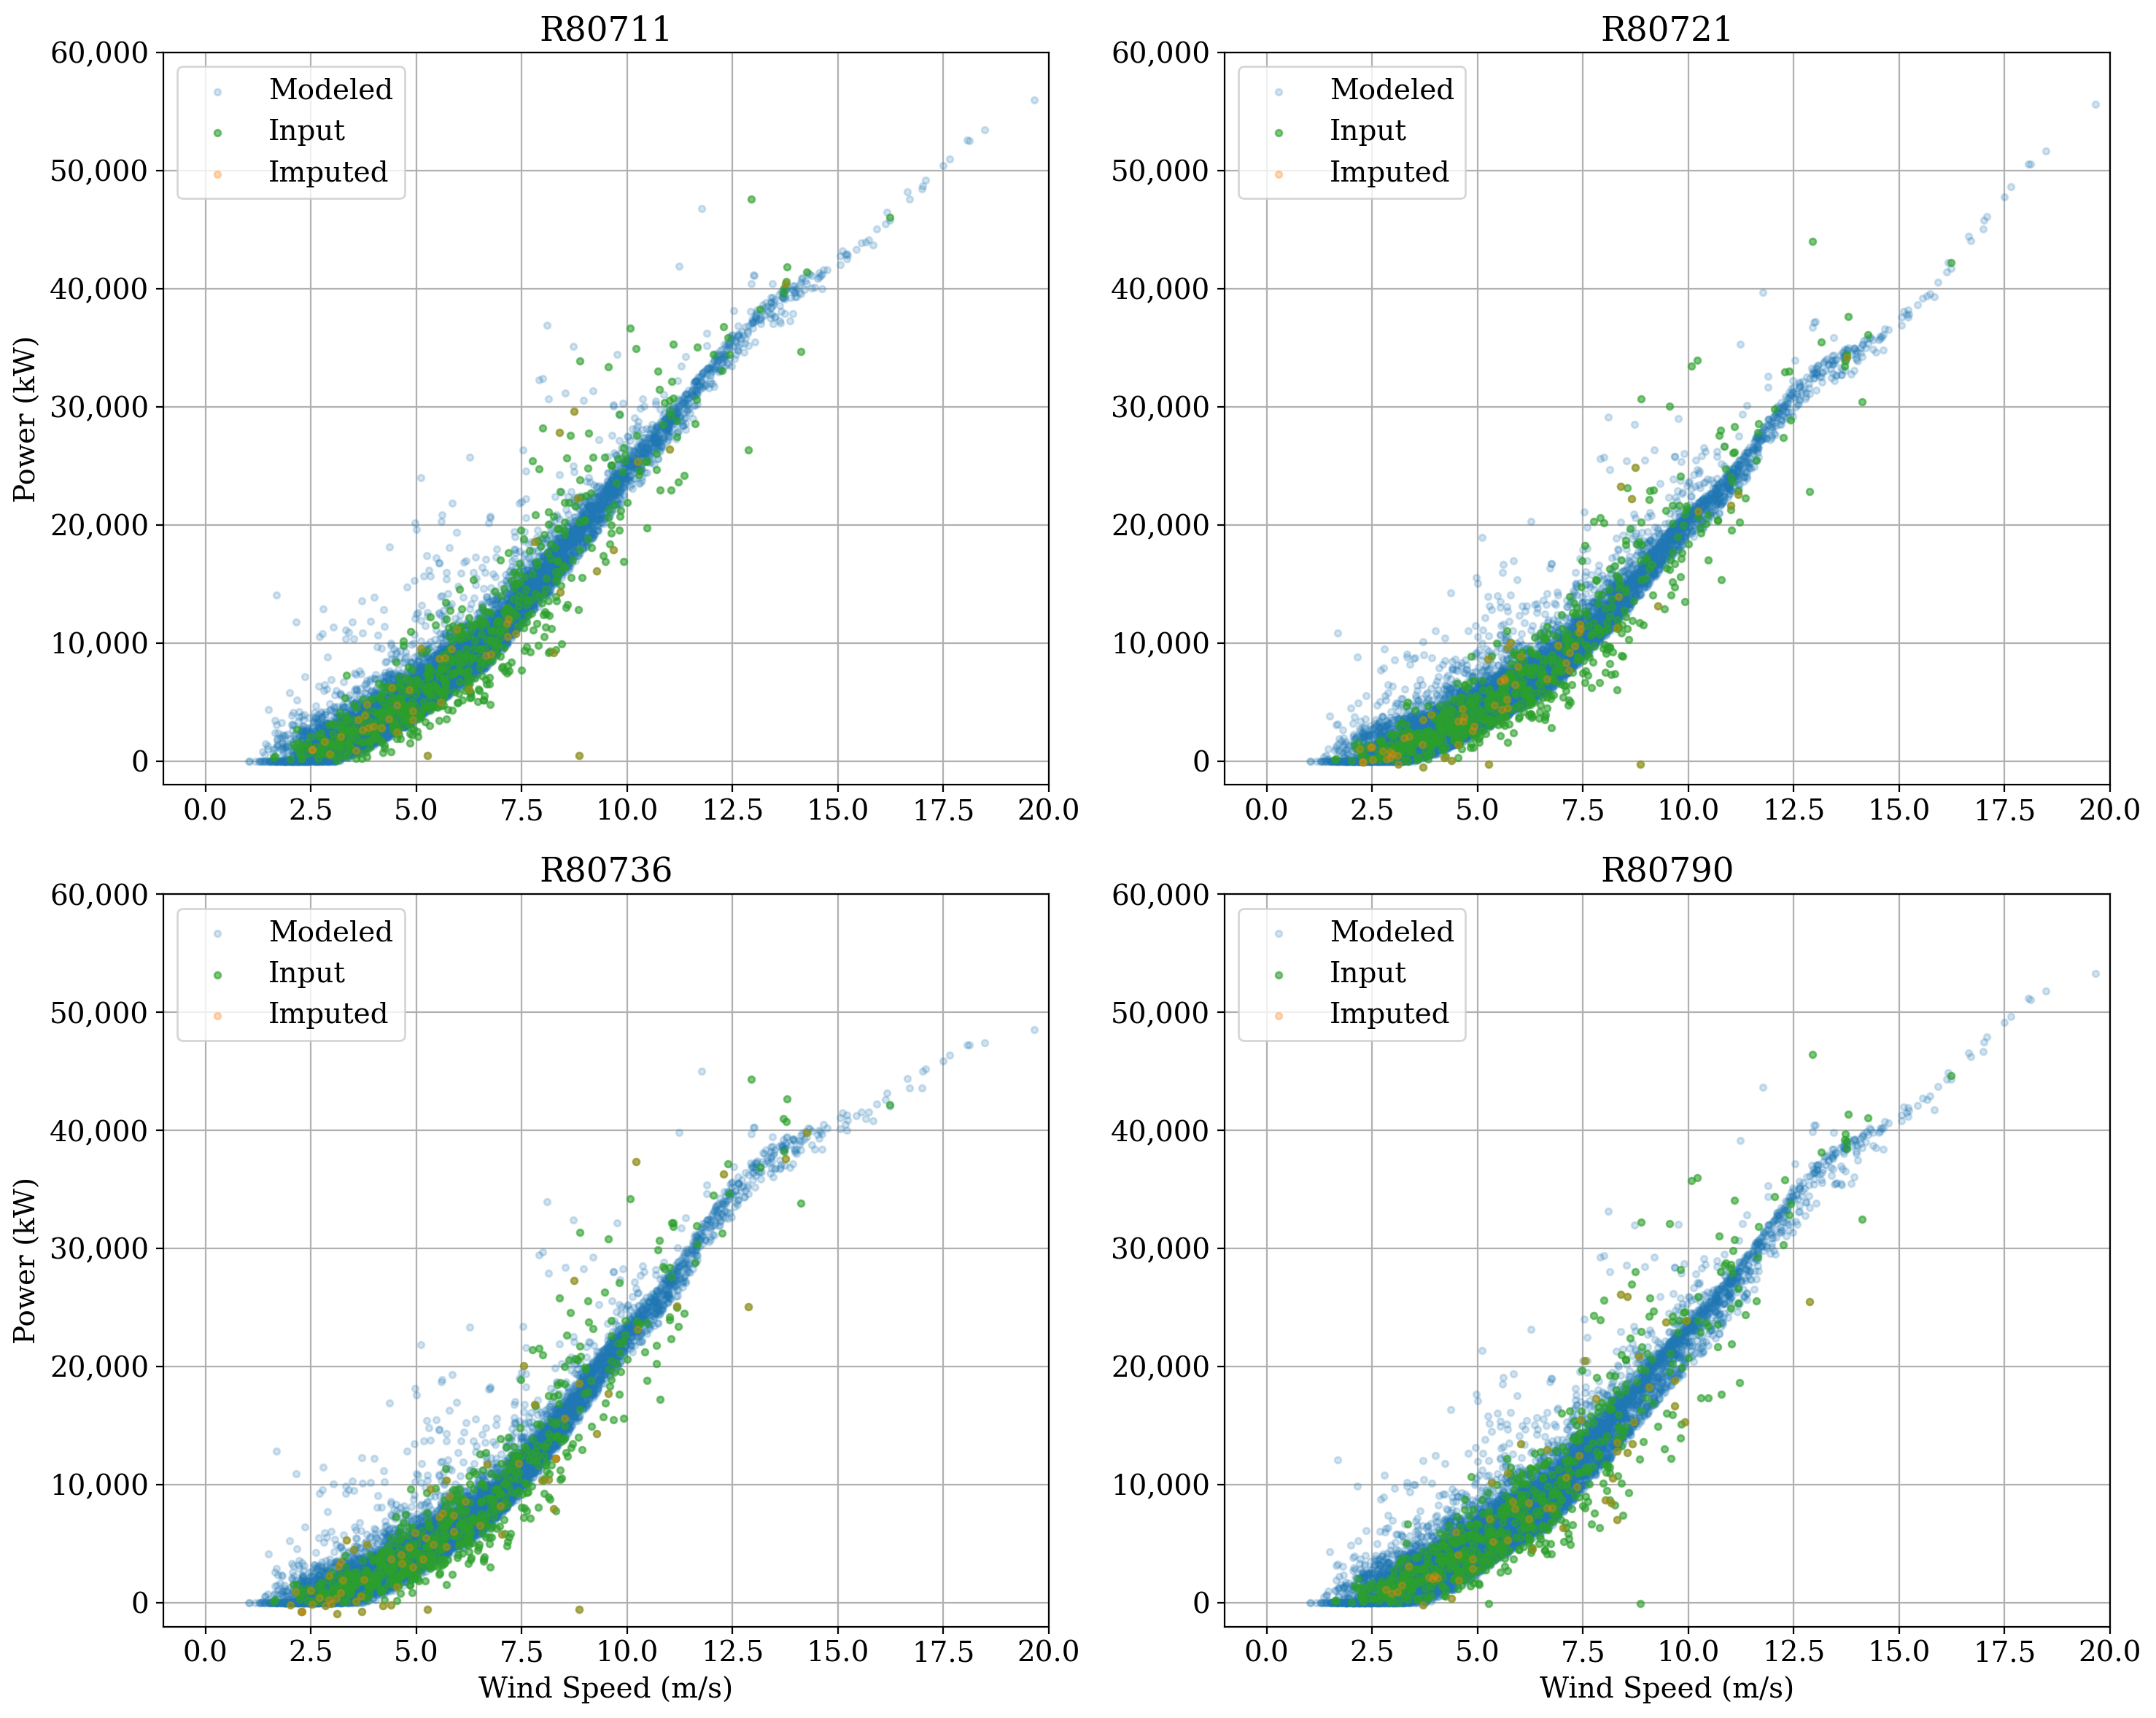

In [10]:
ta.plot_daily_fitting_result(
    legend=True,
    max_cols=2,
    xlim=(-1, 20),
    ylim=(-2000, 60000),
    plot_kwargs=dict(s=10),
    figure_kwargs=dict(figsize=(15, 12)),
)

Overall the fit looks good. The modeled data sometimes estimate higher energy at low wind speeds compared to the observed, but keep in mind the model fits to long term wind speed, wind direction, and air density, whereas we are only showing the relationship to wind speed here.

Note that 'imputed' means daily power data that were missing for a specific turbine, but were calculated by establishing statistical relationships with that turbine and its neighbors. This is necessary since a wind farm often has one turbine down and, without imputation, very little daily data would be left if we excluded days when a turbine was down.

## TIE calculation including uncertainty quantification

Now we will create a TIE object for calculating TIE and quantifying the uncertainty in our estimate. The method estimates uncertainty in the TIE metric through a Monte Carlo sampling of filtering thresholds, power data, and reanalysis product choices.

Note that we set the number of Monte Carlo simulations to only 100 in this example because of the relatively high computational effort required to perform a single iteration. In practice, a larger number of simulations is recommended (the default value is 2000).

With uncertainty quantification enabled (UQ = True), we can specify the assumed uncertainty of the SCADA power data (0.5% by default) and ranges of two key filtering thresholds from which the Monte Carlo simulations will sample. Specifically, these thresholds are applied to the bin_filter() function in the toolkits.filtering class of OpenOA.

Note that the following parameters are the default values.

In [11]:
ta = TurbineLongTermGrossEnergy(
    project,
    UQ = True,  # enable uncertainty quantification
    num_sim = 100,  # number of Monte Carlo simulations to perform
    wind_bin_threshold=(1, 3),  # Data outside of a range of +-1 to +-3 standard deviations from the median for each power bin are discarded
    max_power_filter=(0.8, 0.9),  # The bin filter will be applied up to fractions of turbine capacity from 80% to 90%
    uncertainty_scada=0.005,  # Assumed uncertainty of SCADA power data (0.5%)
    correction_threshold=(0.85, 0.95),
)

INFO:openoa.analysis.turbine_long_term_gross_energy:Initializing TurbineLongTermGrossEnergy Object
INFO:openoa.analysis.turbine_long_term_gross_energy:Note: uncertainty quantification will be performed in the calculation
INFO:openoa.analysis.turbine_long_term_gross_energy:Processing SCADA data into dictionaries by turbine (this can take a while)


We will consider a range of availability thresholds for dealing with missing data when computing daily sums of energy production from each turbine (i.e., if greater than the given threshold of SCADA data are available for a given day, scale up the daily energy by the fraction of data missing. If less than the given threshold of data are available, exclude that day from analysis. Here we set the range of thresholds as 85% to 95%. 

Now we'll call the run() method to calculate TIE with uncertainty quantification, again choosing two reanalysis products to be used in the TIE calculation process.

Note that without uncertainty quantification (UQ = False), a separate TIE value is calculated for each reanalysis product specified. However, when UQ = True, the reanalysis product is treated as another Monte Carlo sampling parameter. Thus, the impact of different reanlysis products is considered to be part of the overall uncertainty in TIE. 

In [12]:
# We can choose to save key plots to a file by setting enable_plotting = True and 
# specifying a directory to save the images. For now we turn off this feature. 
ta.run(reanalysis_subset = ['era5', 'merra2'])

INFO:openoa.analysis.turbine_long_term_gross_energy:Running the long term gross energy analysis
100%|██████████| 100/100 [31:21<00:00, 18.81s/it]
INFO:openoa.analysis.turbine_long_term_gross_energy:Run completed


Now that we've finished the Monte Carlo TIE calculation simulations, let's examine results

In [13]:
np.mean(ta.plant_gross)

13599198.954714842

In [14]:
np.std(ta.plant_gross)

466052.49210607685

In [15]:
# Mean long-term annual TIE for whole plant
print(f"Mean long-term turbine ideal energy is {np.mean(ta.plant_gross/1e6):,.1f} GWh/year")

# Uncertainty in long-term annual TIE for whole plant
print(f"Uncertainty in long-term turbine ideal energy is {np.std(ta.plant_gross/1e6):,.1f} GWh/year, or {np.std(ta.plant_gross)/np.mean(ta.plant_gross):.1%} percent")

Mean long-term turbine ideal energy is 13.6 GWh/year
Uncertainty in long-term turbine ideal energy is 0.5 GWh/year, or 3.4% percent



As expected, the mean long-term TIE is close to the earlier estimate without uncertainty quantification. A relatively low uncertainty has been estimated for the TIE calculations. This is a result of the relatively close agreement between the two reanalysis products and the clean power curves plotted earlier.

# Gap Analysis Step 3: Estimate Electrical Losses Using SCADA and Revenue Meter Data

In [1]:
%load_ext autoreload
%autoreload 2

Calculating electrical losses in this method is relatively straightforward. In short, the sum of turbine energy is compared to the sum of metered energy, with the differnce equaling the electrical losses for the wind farm. However, the time resolution of the metered data and dealing with missing data are important aspects of this method.

The approach is to first calculate daily sums of turbine and revenue meter energy over the 
plant period of record. Only those days where all turbines and the revenue meter were 
reporting for all timesteps are considered. Electrical loss is then the difference in 
total turbine energy production and meter production over those concurrent days. 
    
Uncertainty in the calculated electrical losses is estimated by applying a Monte Carlo approach to sample revenue meter data and SCADA data with a 0.5% imposed uncertainty. One filtering parameter is sampled too.
The uncertainty in estimated electrical losses is quantified as the standard deviation
of the distribution of losses obtained from the MC sampling.
    
In this example, the procedure for calculating electrical losses is illustrated with and without uncertainty quantification.
    
In the case that meter data is not provided on a daily or sub-daily basis (e.g. monthly), a
different approach is implemented. The sum of daily turbine energy is corrected for any missing 
reported energy data from the turbines based on the ratio of expected number of data counts per day 
to the actual. Daily corrected sum of turbine energy is then summed on a monthly basis. Electrical 
loss is then the difference between total corrected turbine energy production and meter production 
over those concurrent months.   

In [2]:
# Import required packages
from datetime import datetime

import numpy as np
import pandas as pd

from openoa.analysis import ElectricalLosses

import project_ENGIE

In the call below, make sure the appropriate path to the CSV input files is specfied. In this example, the CSV files are located directly in the 'examples/operational_AEP_analysis/data' folder.

In [3]:
# Load wind farm object, append the analysis type for this example, and revalidate the data
project = project_ENGIE.prepare('./data/la_haute_borne')
project.analysis_type.append("ElectricalLosses")
project.validate()

INFO:root:Loading SCADA data
INFO:root:SCADA data loaded
INFO:root:Timestamp conversion to datetime and UTC
INFO:root:Removing out of range of temperature readings
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:root:Flagging unresponsive sensors
INFO:root:Converting pitch to the range [-180, 180]
INFO:root:Calculating energy production
INFO:root:Reading in the meter data
INFO:root:Reading in the curtailment data
INFO:root:Reading in the reanalysis data and calculating the extra fields
INFO:root:Reading in the asset data
/opt/miniconda3/envs/openoa/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:112: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  values = construct_1d_object_array_from_listlike(values)


## Electrical loss estimation without uncertainty quantification

Next we create an Electrical Loss object which will contain the analysis to be performed. The method has the ability to calculate uncertainty in the electrical losses through a Monte Carlo sampling of power data based on its measurement uncertainty. For now, we turn this option off and calculate a single electrical loss value.

In [4]:
# Create Electrical Loss object
el = ElectricalLosses(
    project,
    UQ=False,  # (default), only run a single simulation
    uncertainty_correction_threshold=0.95,  # (default) exclude months with < 95% coverage
)

INFO:openoa.analysis.electrical_losses:Initializing Electrical Losses Object
INFO:openoa.analysis.electrical_losses:Note: uncertainty quantification will NOT be performed in the calculation
INFO:openoa.analysis.electrical_losses:Processing SCADA data
INFO:openoa.analysis.electrical_losses:Processing meter data


In [5]:
# Now we run the analysis using the run() function in the method
el.run()

INFO:openoa.analysis.electrical_losses:Calculating electrical losses
100%|██████████| 1/1 [00:00<00:00, 100.02it/s]


Now that the analyiss is complete, let's examine the results

In [6]:
el.electrical_losses[0][0]

0.019994645742960393

In [7]:
# Electrical losses for the wind farm
print(f"Electrical losses are {el.electrical_losses[0][0]:.1%}")

Electrical losses are 2.0%


Now let's plot electrical losses by month

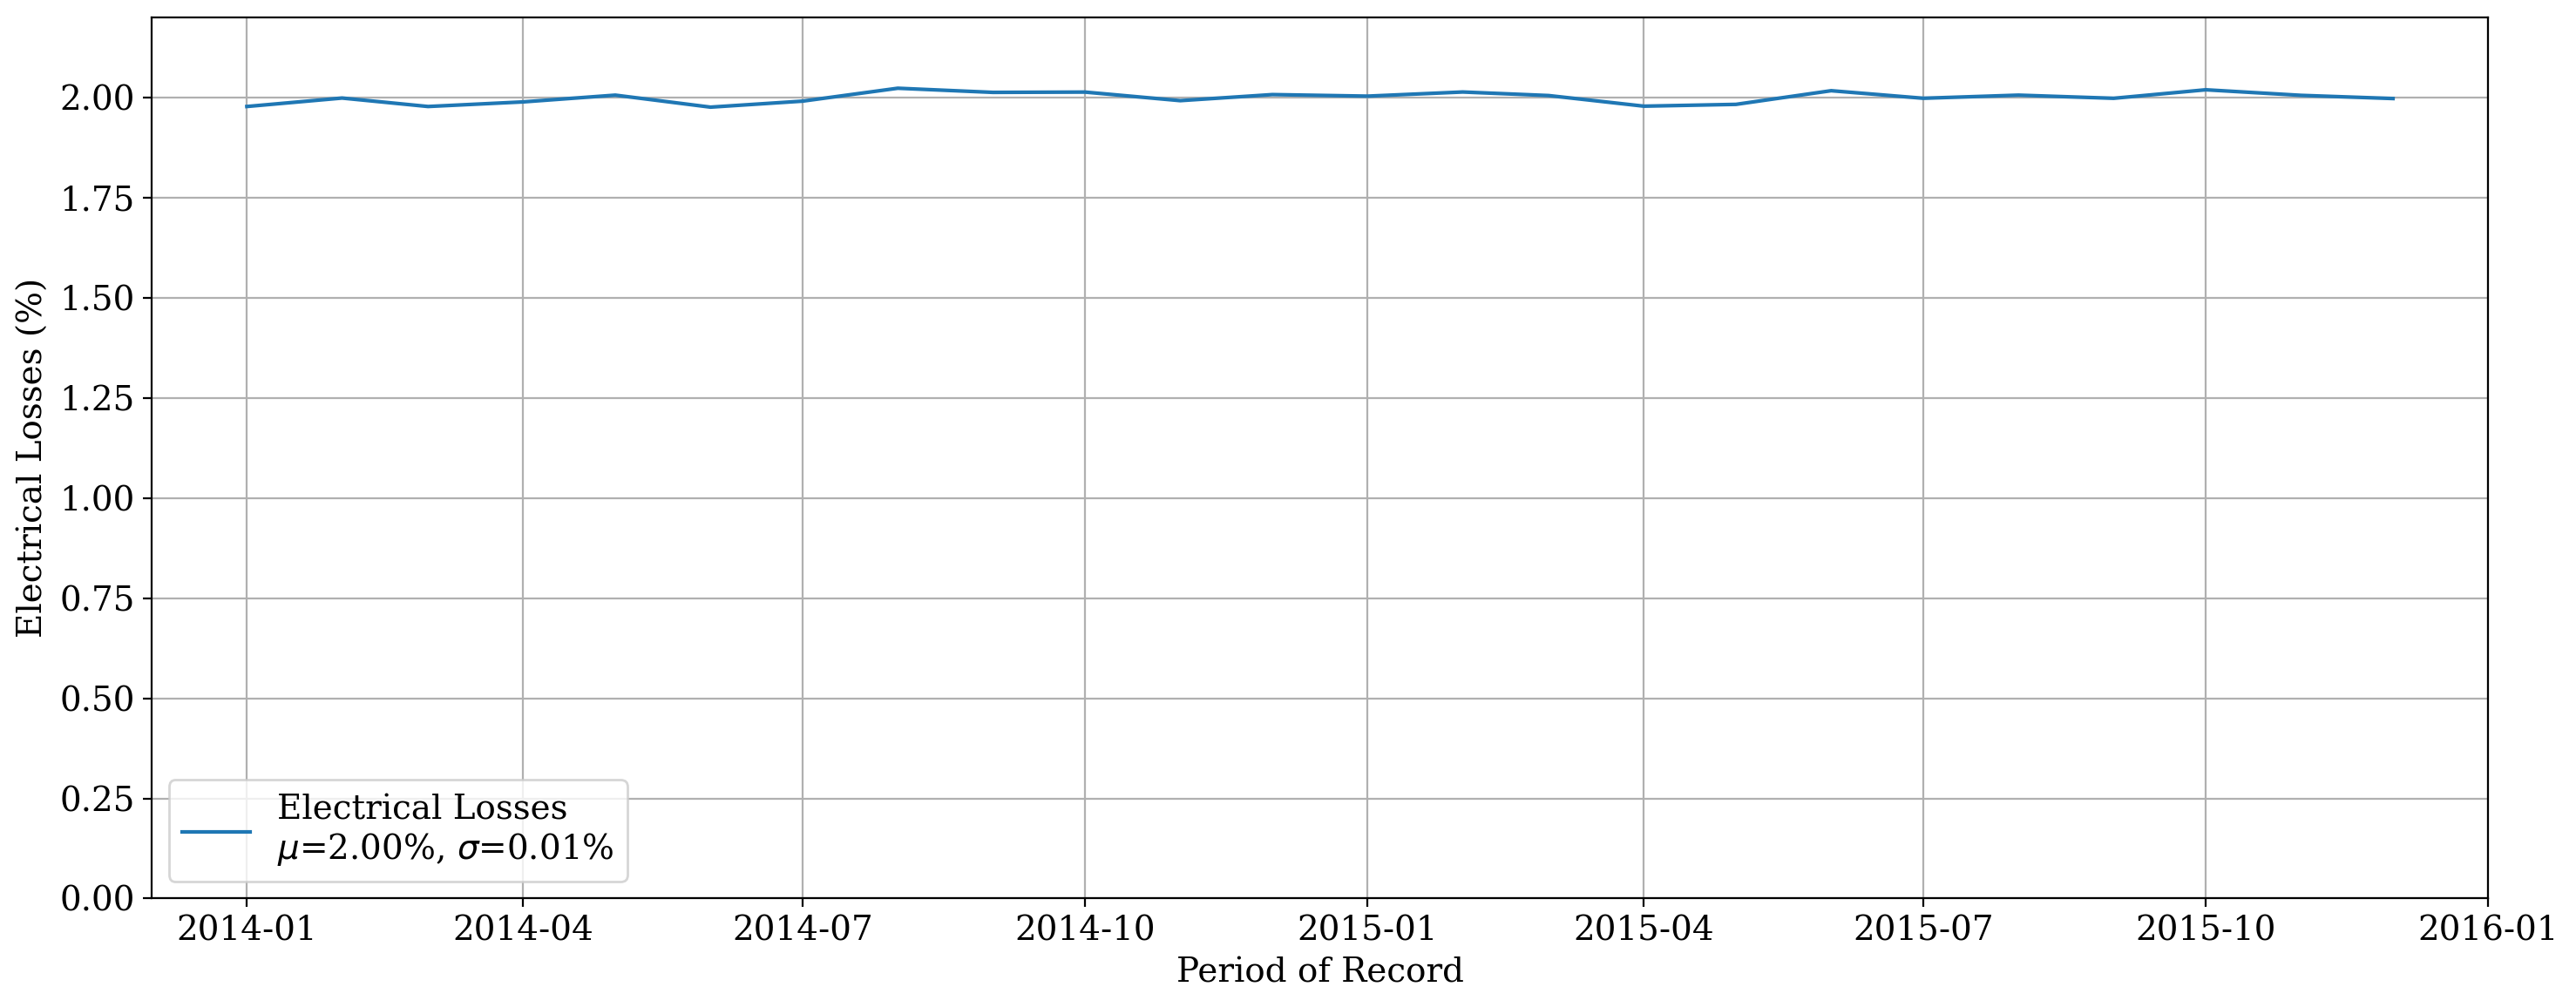

In [8]:
el.plot_monthly_losses(
    xlim=(datetime(month=12, day=1, year=2013), datetime(month=1, day=1, year=2016)),
    ylim=(0, 2.2)
)

We see that electrical losses vary between 1.98 and 2.02%. This is a narrow range, but keep in mind the meter data for La Haute Borne was synthesized by NREL based on the SCADA data and sampling around a 2% electrical loss with a standard deviation of 0.5%. Part of the reason for the very low spread in estimated monthly electrical losses is that uncertainty was introduced to the meter data at the 10-minute level when the data were synthesized. This uncertainty tends to get averaged out over the period of record. Normally electrical losses using actual meter data would not be this consistent and would generally show seasonal trends.

## Electrical loss estimation including uncertainty quantification

Next we create an Electrical Loss object with uncertainty quantification enabled and the number of Monte Carlo simulations set to 3000. This method calculates uncertainty in the electrical losses through a Monte Carlo sampling of power data based on its assumed measurement uncertainty of 0.5%. Furthermore, if dealing with monthly meter data, a range of availabiity thresholds used to remove months with low data coverage is sampled. 

In [9]:
# Create Electrical Loss object
el = ElectricalLosses(
    project, UQ = True, # enable UQ
    num_sim = 3000, # number of Monte Carlo simulations to perform
    uncertainty_meter=0.005, # 0.5% uncertainty in meter data
    uncertainty_scada=0.005,  # 0.5% uncertainty in scada data
    uncertainty_correction_threshold=(0.9, 0.995), # randomly sample between 90% and 99.5% coverage required in a month
)

INFO:openoa.analysis.electrical_losses:Initializing Electrical Losses Object
INFO:openoa.analysis.electrical_losses:Note: uncertainty quantification will be performed in the calculation
INFO:openoa.analysis.electrical_losses:Processing SCADA data
INFO:openoa.analysis.electrical_losses:Processing meter data


In [10]:
# Now we run the analysis using the run() function in the method
el.run()

INFO:openoa.analysis.electrical_losses:Calculating electrical losses
100%|██████████| 3000/3000 [00:10<00:00, 283.19it/s]


Now let's examine the results from the Monte Carlo simulations

In [11]:
# Electrical losses for the wind farm
print(f"Electrical losses are {el.electrical_losses.mean():.2%}")
print(f"Uncertainty in the electrical loss estimate is {el.electrical_losses.std():.2%}")

Electrical losses are 1.97%
Uncertainty in the electrical loss estimate is 0.69%


Again, the expected electrical losses are 2.0 percent. The uncertainty in the calculated losses is estimated to be 0.7%. This uncertainty value is given by the standard deviation of electrical losses over all Monte Carlo iterations and is primarily driven by the assumed 0.5% uncertainty for meter and SCADA power values. 

# Gap Analysis Step 4: Compare the Energy Yield Assessment to the Operational Assessment (Gap Analysis)

This notebook will explore the use of the energy yield assessment (EYA) gap analysis method in OpenOA. This method attributes differences in an EYA-estimate and an operational assessment (OA) estimate of annual energy production (AEP; or net energy, P50). Differences in availability loss estimates, electrical loss estimates, and turbine ideal energy estimates are analyzed. The latter metric incorporates many aspects of an EYA, including the wind resource estimate, wake loss estimate, turbine performance, and blade degradation. 

The gap analysis is based on comparing the following three key metrics:

1. Availability loss
2. Electrical loss
3. Sum of turbine ideal energy

Here turbine ideal energy is defined as the energy produced during 'normal' or 'ideal' turbine operation, 
i.e., no downtime or considerable underperformance events. This value encompasses several different aspects 
of an EYA (wind resource estimate, wake losses, turbine performance, and blade degradation) and in most cases
should have the largest impact in a gap analysis relative to the first two metrics.

This gap analysis method is fairly straighforward. Relevant EYA and OA metrics are passed in when defining
the class, differences in EYA estimates and OA results are calculated, and then a 'waterfall' plot is created
showing the differences between the EYA and OA-estimated AEP values and how they are linked from differences in 
the three key metrics.

In [1]:
# Import required packages
from openoa.analysis import MonteCarloAEP, TurbineLongTermGrossEnergy, ElectricalLosses, EYAGapAnalysis
from openoa.utils import plot

import project_ENGIE

%load_ext autoreload
%autoreload 2

In [2]:
# Load plant object and process plant data
project = project_ENGIE.prepare('./data/la_haute_borne')

# Add the analysis workflow validations needed below and re-validate
project.analysis_type.extend(["TurbineLongTermGrossEnergy", "ElectricalLosses"])
project.validate()

INFO:root:Loading SCADA data
INFO:root:SCADA data loaded
INFO:root:Timestamp conversion to datetime and UTC
INFO:root:Removing out of range of temperature readings
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:root:Flagging unresponsive sensors
INFO:root:Converting pitch to the range [-180, 180]
INFO:root:Calculating energy production
INFO:root:Reading in the meter data
INFO:root:Reading in the curtailment data
INFO:root:Reading in the reanalysis data and calculating the extra fields
INFO:root:Reading in the asset data
/opt/miniconda3/envs/openoa/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:112: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  values = construct_1d_object_array_from_listlike(values)


## Calculate AEP, TIE, and electrical losses from operational data

The first step is to calculate annual energy production (AEP) for the wind farm (Example 02), turbine ideal energy (TIE) for the wind farm (Example 03) and calculate electrical losses (Example 04). Please refer to detailed documentation of these methods in the previous example notebooks. 

In [3]:
# Calculate AEP
pa = MonteCarloAEP(project, reanalysis_products = ['era5', 'merra2'])
pa.run(num_sim=20000, reanalysis_subset=['era5', 'merra2'])

INFO:openoa.analysis.aep:Initializing MonteCarloAEP Analysis Object
INFO:openoa.analysis.aep:Running with parameters: {'uncertainty_meter': 0.005, 'uncertainty_losses': 0.05, 'uncertainty_loss_max': array([10., 20.]), 'uncertainty_windiness': array([10., 20.]), 'uncertainty_nan_energy': 0.01, 'num_sim': 20000, 'reanalysis_subset': ['era5', 'merra2']}
100%|██████████| 20000/20000 [03:18<00:00, 100.61it/s]
INFO:openoa.analysis.aep:Run completed


In [4]:
# Calculate TIE
ta = TurbineLongTermGrossEnergy(
    project,
    UQ=True,
    num_sim=100,
    max_power_filter=(0.8, 0.9), 
    wind_bin_threshold=(1.0, 3.0),
    correction_threshold=(0.85, 0.95),
)
ta.run(reanalysis_subset = ['era5', 'merra2'])

INFO:openoa.analysis.turbine_long_term_gross_energy:Initializing TurbineLongTermGrossEnergy Object
INFO:openoa.analysis.turbine_long_term_gross_energy:Note: uncertainty quantification will be performed in the calculation
INFO:openoa.analysis.turbine_long_term_gross_energy:Processing SCADA data into dictionaries by turbine (this can take a while)
INFO:openoa.analysis.turbine_long_term_gross_energy:Running the long term gross energy analysis
100%|██████████| 100/100 [30:18<00:00, 18.19s/it]
INFO:openoa.analysis.turbine_long_term_gross_energy:Run completed


In [5]:
# Calculate electrical losses
el = ElectricalLosses(project)
el.run()

INFO:openoa.analysis.electrical_losses:Initializing Electrical Losses Object
INFO:openoa.analysis.electrical_losses:Note: uncertainty quantification will NOT be performed in the calculation
INFO:openoa.analysis.electrical_losses:Processing SCADA data
INFO:openoa.analysis.electrical_losses:Processing meter data
INFO:openoa.analysis.electrical_losses:Calculating electrical losses
100%|██████████| 1/1 [00:00<00:00, 184.84it/s]


Now that we've calculated the key operational metrics, we setup some arrays that the gap analysis method needs to run.

## Summarize operational results and create EYA data for comparison

In [6]:
# First summarize key operational results
aep = pa.results.aep_GWh.mean()
avail = pa.results.avail_pct.mean()
elec = el.electrical_losses[0][0]
tie = ta.plant_gross[0][0]/1e6

print(f"AEP = {aep:21.2f} GWh/yr")
print(f"Availability Losses = {avail:.2%}")
print(f"Electrical Losses = {elec:7.2%}")
print(f"TIE = {tie:21.2f} GWh/yr")

AEP =                 12.28 GWh/yr
Availability Losses = 1.17%
Electrical Losses =   2.00%
TIE =                 13.84 GWh/yr


In [7]:
# Define operational data
oa_results = dict(
    aep=aep,  # AEP (GWh/yr)
    availability_losses=avail,  # Availability loss (fraction)
    electrical_losses=elec,  # Electrical loss (fraction)
    turbine_ideal_energy=tie  # Turbine ideal energy (GWh/yr)
)

# Define EYA data (we are fabricating these data as an example)
eya_estimates = dict(
    aep=16.46,  # AEP (GWh/yr)
    gross_energy=20.0,  # Gross energy (GWh/yr)
    availability_losses=0.04,  # Availability loss (fraction)
    electrical_losses=0.014,  # Electrical loss (Fraction)
    turbine_losses=0.037,  # Turbine performance loss (fraction)
    blade_degradation_losses=0.011,  # Blade degradation loss (fraction)
    wake_losses=0.087,  # Wake loss (fraction)
)

## Perform gap analysis

Now that we have the data we need, we first create a gap analysis object

In [8]:
eya_gap = EYAGapAnalysis(eya_estimates=eya_estimates, oa_results=oa_results)

INFO:openoa.analysis.eya_gap_analysis:Initialized EYA Gap Analysis Object


Now we run the analysis, which by default outputs a waterfall plot showing how the gap between EYA-reported AEP and plant-measured AEP can be explained:

In [9]:
eya_gap.run()

INFO:openoa.analysis.eya_gap_analysis:Gap analysis complete


In this example, they EYA estimate of AEP was about 4 GWh/yr higher than the OA result. This difference is largely explained by a large difference in turbine ideal energy (overestimated in EYA), and smaller differences in availability (underestimated in EYA) and electrical losses (overestimated in EYA). A total of 1 GWh/yr is left unexplained or uncertain using this method.

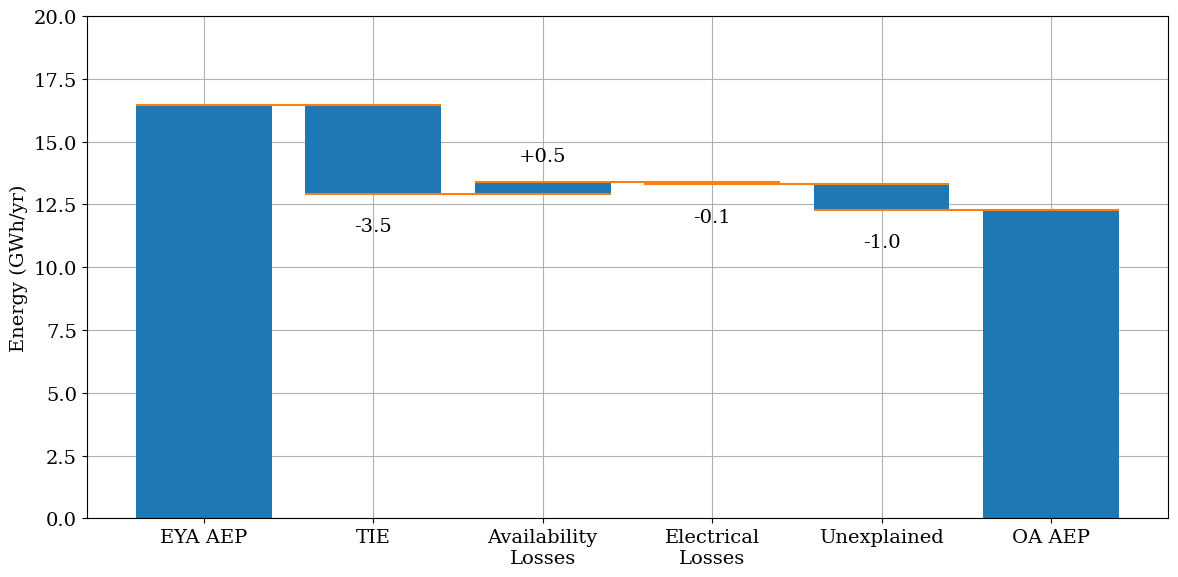

In [10]:
eya_gap.plot_waterfall(ylim=(0, 20))

# # Notice that we can also use the plotting library to get the same results!
# plot.plot_waterfall(
#     eya_gap.compiled_data,
#     index=["EYA AEP", "TIE",  "Availability\nLosses", "Electrical\nLosses", "Unexplained", "OA AEP"],
#     ylim=(0, 20),
# )